In [2]:
import pandas as pd

# Caminho do arquivo Excel
caminho_arquivo = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'

# Ler a aba "Planilha1"
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

# Mostrar as primeiras linhas para conferir
print(df.head())

         Data                Parametro        Valor
0  31/07/2008     Nitrogênio Amoniacal  28,20000000
1  31/07/2008                       OD   0,07000000
2  31/07/2008  Sólido Dissolvido Total          414
3  31/07/2008            Fósforo Total   2,57000000
4  31/07/2008   Chuvas nas últimas 24h            0


In [4]:
import pandas as pd

# Caminho do arquivo
caminho_arquivo = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'

# Ler a aba
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

# Converter coluna Data para datetime (ajustando formato dd/mm/yyyy)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Filtrar dados entre 2010 e 2025
df_filtrado = df[(df['Data'].dt.year >= 2010) & (df['Data'].dt.year <= 2025)]

# Contar quantos dados para cada parâmetro nesse período
contagem = df_filtrado['Parametro'].value_counts()

print(contagem)

Parametro
OD                         84
pH                         84
Condutividade              84
Chuvas nas últimas 24h     83
Nitrogênio Amoniacal       82
Fósforo Total              82
Sólido Dissolvido Total    81
Name: count, dtype: int64


In [5]:
# -*- coding: utf-8 -*-
# TABELA ESTATÍSTICA POR PARÂMETRO (para colar no chat)
# Dados longos: colunas ['Data','Parametro','Valor']
# Recorte: 2019 até o último dado

import numpy as np
import pandas as pd

# ===== CONFIG =====
CAMINHO_ARQUIVO = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'
ABA        = 'Planilha1'
COL_DATA   = 'Data'
COL_PARAM  = 'Parametro'
COL_VALOR  = 'Valor'
ANO_INICIO = 2019
# ==================

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 220)
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

def to_numeric_robusto(s: pd.Series) -> pd.Series:
    s2 = pd.to_numeric(s, errors='coerce')
    if s2.isna().mean() > 0.2:
        s2 = pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')
    return s2

def qtile(s: pd.Series, p: float):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.percentile(s, p)) if len(s) else np.nan

def safe_min(s): 
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.min(s)) if len(s) else np.nan

def safe_max(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.max(s)) if len(s) else np.nan

def safe_mean(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.mean(s)) if len(s) else np.nan

def safe_std(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(np.std(s, ddof=1)) if len(s) > 1 else np.nan

# ===== Leitura e recorte =====
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)
df = df.rename(columns={COL_DATA: 'Data', COL_PARAM: 'Parametro', COL_VALOR: 'Valor'})
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Data']).copy()
df['Ano'] = df['Data'].dt.year
df = df[df['Ano'] >= ANO_INICIO].copy()

# valor numérico robusto
df['Valor_num'] = to_numeric_robusto(df['Valor'])

# considera somente parâmetros que têm ao menos 1 valor numérico válido no recorte
params_validos = (df.groupby('Parametro')['Valor_num'].apply(lambda s: s.notna().any()))
params_validos = params_validos[params_validos].index.tolist()
dfv = df[df['Parametro'].isin(params_validos)].copy()

# ===== Estatística por parâmetro com named aggregations =====
g = dfv.groupby('Parametro')['Valor_num']

tabela = g.agg(
    N           = 'size',                                # total de linhas (inclui NaN)
    N_valid     = lambda s: int(s.notna().sum()),
    Missing     = lambda s: int(s.isna().sum()),
    Min         = safe_min,
    Q1          = lambda s: qtile(s, 25),
    Mediana     = lambda s: qtile(s, 50),
    Média       = safe_mean,
    Q3          = lambda s: qtile(s, 75),
    Máx         = safe_max,
    Desvio_Padrão = safe_std,
    p10         = lambda s: qtile(s, 10),
    p90         = lambda s: qtile(s, 90),
)

# colunas derivadas
tabela['Missing_%'] = np.where(tabela['N'] > 0, (tabela['Missing'] / tabela['N'] * 100).round(2), np.nan)
tabela['IQR'] = (tabela['Q3'] - tabela['Q1']).astype(float)

# ordena colunas na sequência desejada
cols_ordem = ['N','N_valid','Missing','Missing_%','Min','Q1','Mediana','Média','Q3','Máx','Desvio_Padrão','IQR','p10','p90']
tabela = tabela[cols_ordem].reset_index()

# ordena linhas por nome do parâmetro (opcional)
tabela = tabela.sort_values('Parametro').reset_index(drop=True)

print("\n=== TABELA ESTATÍSTICA (2019+ até o último dado) ===")
print(tabela.round(3).to_string(index=False))




=== TABELA ESTATÍSTICA (2019+ até o último dado) ===
              Parametro  N  N_valid  Missing  Missing_%     Min      Q1  Mediana   Média      Q3     Máx  Desvio_Padrão     IQR     p10     p90
 Chuvas nas últimas 24h 29       29        0      0.000   0.000   0.000    0.000   0.414   1.000   1.000          0.501   1.000   0.000   1.000
          Condutividade 30       30        0      0.000 236.000 457.000  596.000 572.267 693.250 810.000        158.975 236.250 335.200 753.000
          Fósforo Total 28       28        0      0.000   0.290   0.958    1.615   1.750   2.412   4.330          0.971   1.455   0.558   2.753
   Nitrogênio Amoniacal 28       28        0      0.000   3.630   9.242   16.500  15.862  21.975  29.900          7.339  12.733   5.720  24.660
                     OD 30       30        0      0.000   0.210   0.228    0.540   0.939   0.830   8.110          1.466   0.602   0.210   1.915
Sólido Dissolvido Total 28       28        0      0.000 140.000 229.500  288.000 2

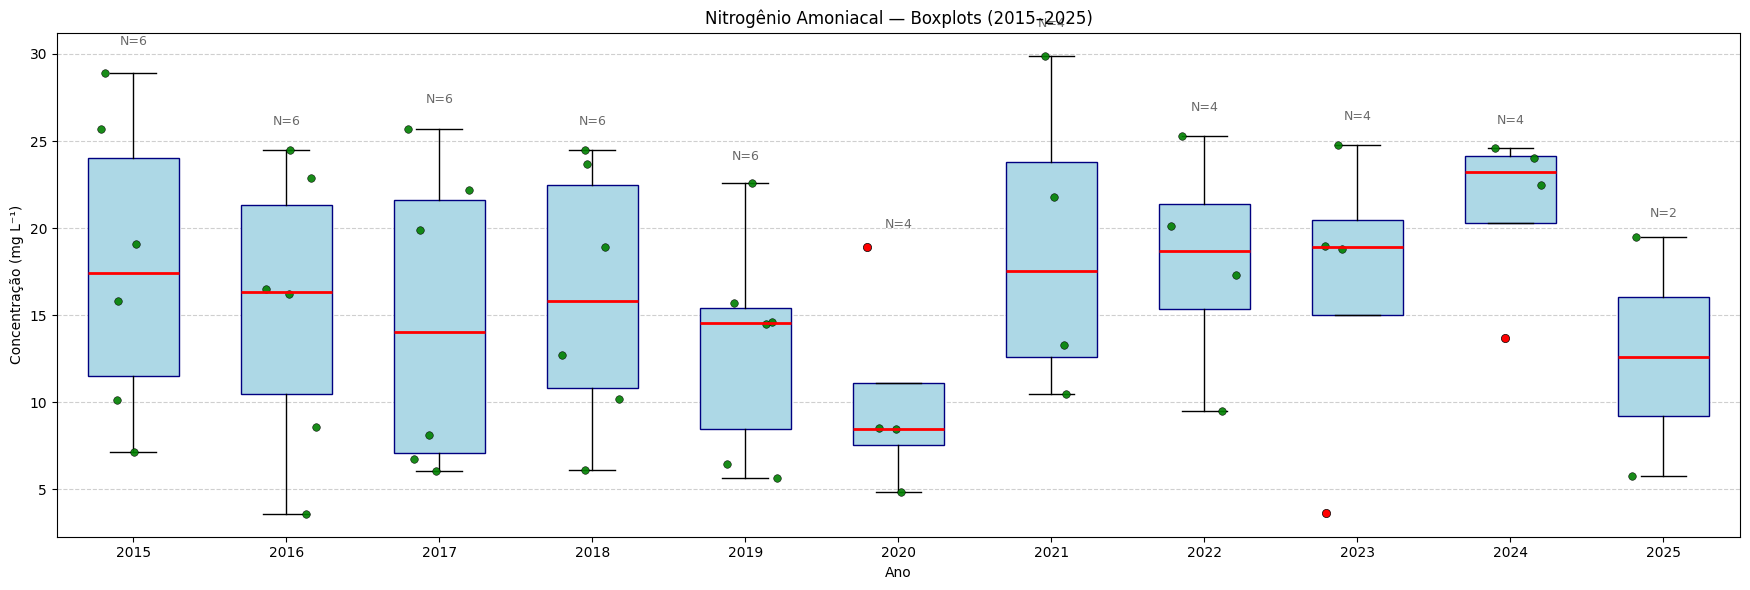

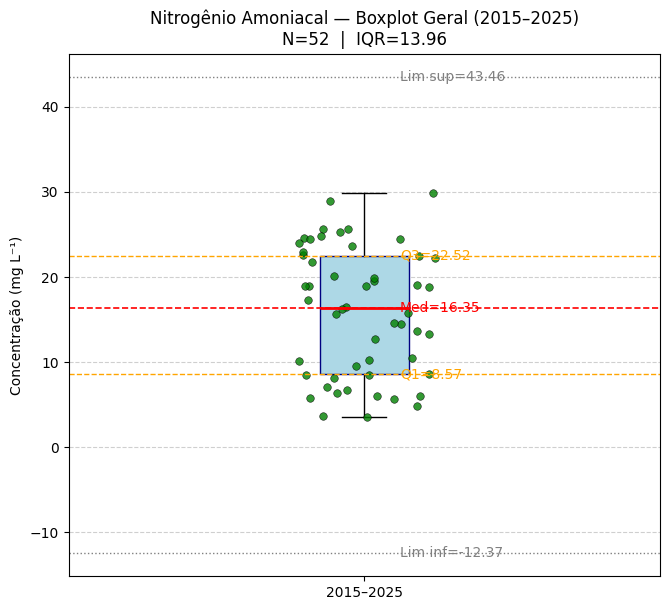


Resumo geral (2015–2025):
N=52, Min=3.59, Q1=8.57, Mediana=16.35, Q3=22.52, Max=29.90, IQR=13.96
Limites de Tukey: inferior=-12.37, superior=43.46
Outliers detectados: 0 (em vermelho)


In [8]:
# -*- coding: utf-8 -*-
"""
Boxplots do Nitrogênio Amoniacal com frequência e destaque (2010–2025):
- Pontos verdes = valores dentro dos limites (normais)
- Pontos vermelhos = outliers (Tukey)
- Boxplots por ano e geral (intervalo definido por ANO_INICIO e ANO_FIM)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== CONFIGURAÇÕES ==============
CAMINHO_ARQUIVO = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'
ABA         = 'Planilha1'
COL_DATA    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALOR   = 'Valor'
PARAM_ALVO  = 'nitrogênio amoniacal'  # filtro case-insensitive por "contém"
ANO_INICIO  = 2015
ANO_FIM     = 2025
# ===========================================

def to_num(s):
    """Converte strings com vírgula decimal para float (coerce)."""
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def tukey_limits(arr):
    """Calcula Q1, Q3, IQR e limites de Tukey."""
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return q1, q3, iqr, low, high

# ---------- Leitura e preparo ----------
df = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=ABA)

# Datas
df[COL_DATA] = pd.to_datetime(df[COL_DATA], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATA])

# Janela de anos 2010–2025 (inclusive)
df = df[(df[COL_DATA].dt.year >= ANO_INICIO) & (df[COL_DATA].dt.year <= ANO_FIM)].copy()

# Parâmetro alvo
mask_alvo = df[COL_PARAM].astype(str).str.lower().str.contains(PARAM_ALVO)
df_nh4 = df.loc[mask_alvo, [COL_DATA, COL_VALOR]].copy()

# Valor numérico
df_nh4['Valor_num'] = to_num(df_nh4[COL_VALOR])
df_nh4 = df_nh4.dropna(subset=['Valor_num']).copy()
df_nh4['Ano'] = df_nh4[COL_DATA].dt.year

if df_nh4.empty:
    raise ValueError(f"Sem dados numéricos de Nitrogênio Amoniacal no recorte {ANO_INICIO}–{ANO_FIM}.")

# =================== FIGURA 1: por ANO ===================
anos = sorted(df_nh4['Ano'].unique().tolist())
data_by_year = [df_nh4.loc[df_nh4['Ano'] == a, 'Valor_num'].values for a in anos]

plt.figure(figsize=(max(10, 1.6*len(anos)), 6))

bp = plt.boxplot(
    data_by_year,
    positions=np.arange(1, len(anos)+1),
    widths=0.6,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# Pontos (verdes = normais) e outliers (vermelhos)
for i, a in enumerate(anos, start=1):
    yvals = df_nh4.loc[df_nh4['Ano'] == a, 'Valor_num'].values
    if len(yvals) == 0:
        continue

    q1, q3, iqr, low, high = tukey_limits(yvals)
    out_mask = (yvals < low) | (yvals > high)
    norm_mask = ~out_mask

    # Dispersão horizontal para evitar sobreposição
    jitter_norm = np.random.uniform(low=i-0.22, high=i+0.22, size=norm_mask.sum())
    jitter_out  = np.random.uniform(low=i-0.22, high=i+0.22, size=out_mask.sum())

    # Pontos normais (verde)
    if norm_mask.any():
        plt.scatter(jitter_norm, yvals[norm_mask], s=30, alpha=0.9,
                    color='green', edgecolors='black', linewidths=0.4, zorder=2)

    # Pontos outliers (vermelho)
    if out_mask.any():
        plt.scatter(jitter_out, yvals[out_mask], s=35,
                    color='red', edgecolors='black', linewidths=0.5, zorder=3)

    # Rótulo com N por ano
    y_top = np.nanmax(yvals)
    y_label = y_top*1.05 if y_top > 0 else y_top + (abs(y_top) * 0.05 + 0.1)
    plt.text(i, y_label, f'N={len(yvals)}', ha='center', va='bottom',
             fontsize=9, color='dimgray')

plt.title(f'Nitrogênio Amoniacal — Boxplots ({ANO_INICIO}–{ANO_FIM})')
plt.xlabel('Ano')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks(ticks=np.arange(1, len(anos)+1), labels=anos, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# =================== FIGURA 2: GERAL ===================
vals = df_nh4['Valor_num'].values
q1, q3, iqr, low, high = tukey_limits(vals)
q2 = np.percentile(vals, 50)
out_mask = (vals < low) | (vals > high)
norm_mask = ~out_mask

plt.figure(figsize=(6.8, 6.2))
plt.boxplot(
    vals,
    vert=True,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='lightblue', edgecolor='navy'),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
)

# Pontos normais (verde) e outliers (vermelho)
x0 = 1.0
if norm_mask.any():
    x_norm = np.random.uniform(low=x0-0.12, high=x0+0.12, size=norm_mask.sum())
    plt.scatter(x_norm, vals[norm_mask], s=30, alpha=0.8,
                color='green', edgecolors='black', linewidths=0.4, zorder=2)

if out_mask.any():
    x_out = np.random.uniform(low=x0-0.12, high=x0+0.12, size=out_mask.sum())
    plt.scatter(x_out, vals[out_mask], s=35,
                color='red', edgecolors='black', linewidths=0.5, zorder=3)

# Linhas de quartis e limites
plt.axhline(q1,  color='orange', linestyle='--', linewidth=1)
plt.axhline(q2,  color='red',    linestyle='--', linewidth=1.2)
plt.axhline(q3,  color='orange', linestyle='--', linewidth=1)
plt.axhline(low, color='gray',   linestyle=':',  linewidth=1)
plt.axhline(high,color='gray',   linestyle=':',  linewidth=1)

# Anotações
plt.text(1.06, q1,   f'Q1={q1:.2f}',        va='center', color='orange')
plt.text(1.06, q2,   f'Med={q2:.2f}',       va='center', color='red')
plt.text(1.06, q3,   f'Q3={q3:.2f}',        va='center', color='orange')
plt.text(1.06, low,  f'Lim inf={low:.2f}',  va='center', color='gray')
plt.text(1.06, high, f'Lim sup={high:.2f}', va='center', color='gray')

plt.title(f'Nitrogênio Amoniacal — Boxplot Geral ({ANO_INICIO}–{ANO_FIM})'
          f'\nN={len(vals)}  |  IQR={iqr:.2f}')
plt.ylabel('Concentração (mg L⁻¹)')
plt.xticks([1], [f'{ANO_INICIO}–{ANO_FIM}'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- Resumo ----------
print(f"\nResumo geral ({ANO_INICIO}–{ANO_FIM}):")
print(f"N={len(vals)}, Min={np.min(vals):.2f}, Q1={q1:.2f}, Mediana={q2:.2f}, "
      f"Q3={q3:.2f}, Max={np.max(vals):.2f}, IQR={iqr:.2f}")
print(f"Limites de Tukey: inferior={low:.2f}, superior={high:.2f}")
print(f"Outliers detectados: {out_mask.sum()} (em vermelho)")


Period: 2010-01-07 to 2025-05-06
N=82, mean=15.01, median=14.55


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_18220\3288777962.py:159: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(


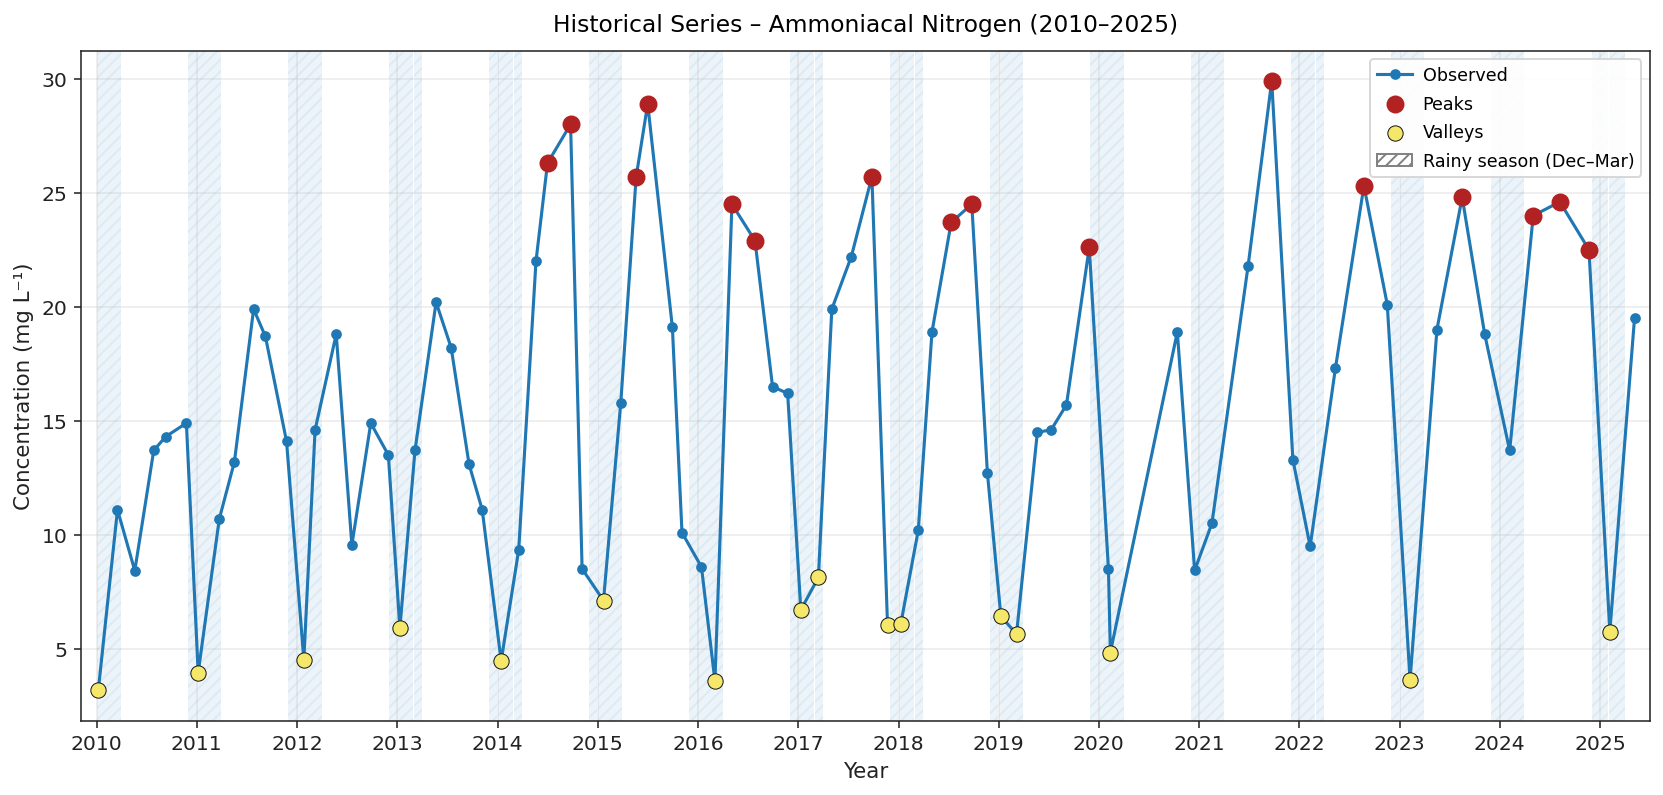

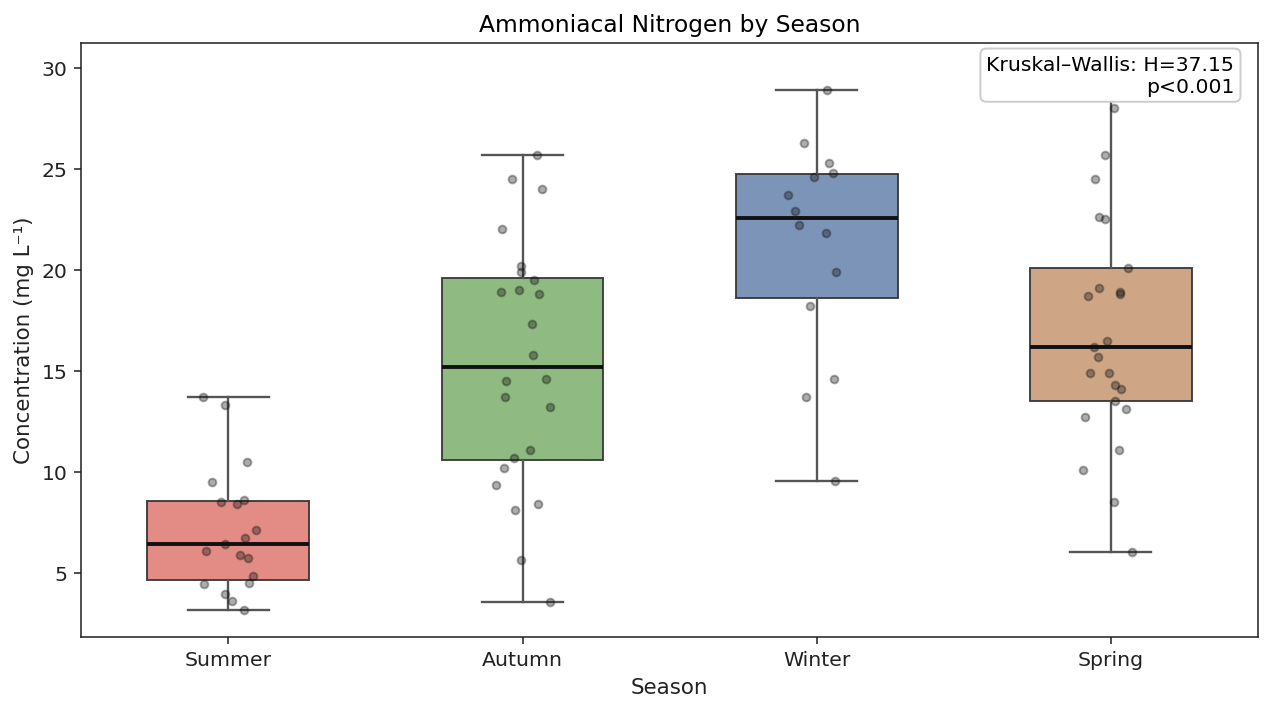

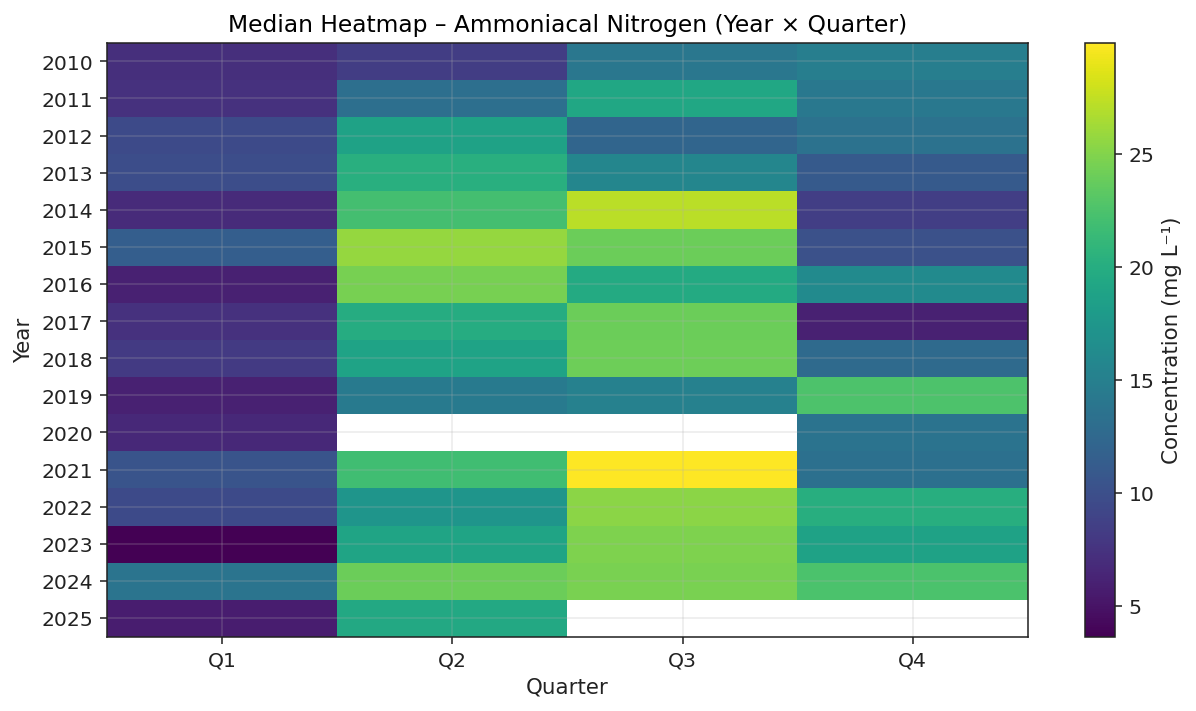

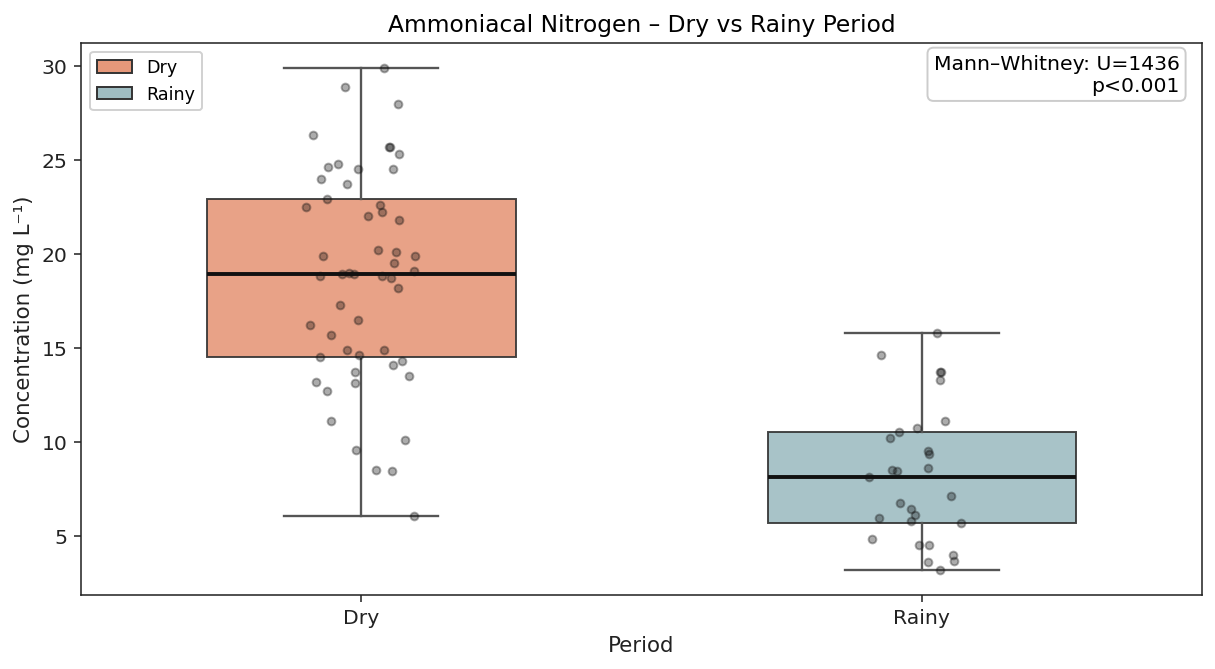

In [2]:
# -*- coding: utf-8 -*-
"""
Historical Series – Ammoniacal Nitrogen (2010–2025)
Modern visual + peaks/valleys + seasonal hatching (rainy season)
+ Boxplot by season (Kruskal–Wallis) [styled, no mean/no n/no grid]
+ Year × Quarter heatmap (medians)
+ Rainy × Dry boxplot (Mann–Whitney) [styled, no mean/no n/no grid, custom legend]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.stats import kruskal, mannwhitneyu

# =================== SETTINGS ===================
FILE_PATH   = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'
SHEET_NAME  = 'Planilha1'

# IMPORTANT:
# Keep these column names exactly as they appear in your Excel file.
# If your Excel headers are in Portuguese (e.g., "Data", "Parametro", "Valor"), keep them as-is.
COL_DATE    = 'Data'
COL_PARAM   = 'Parametro'
COL_VALUE   = 'Valor'

# Target parameter (search is performed in lower case)
# If your parameter names in Excel are in Portuguese, keep the Portuguese string.
TARGET_PARAM = 'nitrogênio amoniacal'   # searched in lower()

START_YEAR  = 2010

# Seasonal shading (Dec–Mar = rainy)
ENABLE_RAINY_SHADING = True
RAINY_MONTHS = {12, 1, 2, 3}

# Modern style (grid kept only for the time series plot)
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.edgecolor": "#222",
    "axes.labelcolor": "#222",
    "xtick.color": "#222",
    "ytick.color": "#222",
    "font.size": 10.5,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.facecolor": "white",
    "legend.edgecolor": "#ccc",
})

# Time series colors
SERIES_COLOR      = "#1f77b4"
PEAKS_COLOR       = "#b22222"
VALLEYS_COLOR     = "#f5e769"
VALLEYS_EDGE      = "#111"
HATCH_COLOR       = "#1f77b4"

# ======= BOXPLOT PALETTE =======
PALETTE = {
    'Summer':  "#E07F78",
    'Autumn':  "#83B474",
    'Winter':  "#6E88AF",
    'Spring':  "#C99D79",
    'Dry':     "#E6987A",
    'Rainy':   "#9FBDC2",
}

def styled_boxplot(ax, groups, colors, title, xlabel, labels=None, ylabel='Concentration (mg L⁻¹)'):
    """Boxplot with colored boxes, bold median, jittered points, fixed x labels, and NO grid."""
    bp = ax.boxplot(
        groups, patch_artist=True, widths=0.55, notch=False, showmeans=False,
        medianprops=dict(color='#111', linewidth=2.0),
        whiskerprops=dict(color='#555', linewidth=1.2),
        capprops=dict(color='#555', linewidth=1.2),
        flierprops=dict(marker='o', markersize=3.5, markerfacecolor='#999',
                        markeredgecolor='#777', alpha=0.5)
    )
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)
        patch.set_edgecolor('#333')
        patch.set_linewidth(1.0)

    # Jittered points
    rng = np.random.default_rng(42)
    for i, arr in enumerate(groups, start=1):
        if len(arr) == 0:
            continue
        x = i + (rng.random(len(arr)) - 0.5) * 0.2
        ax.scatter(x, arr, s=16, alpha=0.35, color='#111', zorder=2)

    # X-axis labels
    if labels is not None:
        ax.set_xticks(range(1, len(labels) + 1))
        ax.set_xticklabels(labels)

    ax.grid(False)  # no grid for boxplots
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_axisbelow(True)
    return bp

def to_num(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.', regex=False), errors='coerce')

def season_of_year(month):
    # Summer: Dec–Feb | Autumn: Mar–May | Winter: Jun–Aug | Spring: Sep–Nov
    if month in (12, 1, 2):  return 'Summer'
    if month in (3, 4, 5):   return 'Autumn'
    if month in (6, 7, 8):   return 'Winter'
    return 'Spring'

def wet_or_dry(month):
    return 'Rainy' if month in RAINY_MONTHS else 'Dry'

# ---------- Read & prepare ----------
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
df[COL_DATE] = pd.to_datetime(df[COL_DATE], dayfirst=True, errors='coerce')
df = df.dropna(subset=[COL_DATE])
df = df[df[COL_DATE].dt.year >= START_YEAR].copy()

# Target series (NH4)
mask_target = df[COL_PARAM].astype(str).str.lower().str.contains(TARGET_PARAM)
df_nh4 = df.loc[mask_target, [COL_DATE, COL_VALUE]].copy()
df_nh4['Value_num'] = to_num(df_nh4[COL_VALUE])
df_nh4 = df_nh4.dropna(subset=['Value_num']).sort_values(COL_DATE).reset_index(drop=True)

if df_nh4.empty:
    raise ValueError("No ammoniacal nitrogen data found for the requested period.")

# ---------- Basic stats ----------
print(f"Period: {df_nh4[COL_DATE].min().date()} to {df_nh4[COL_DATE].max().date()}")
print(f"N={len(df_nh4)}, mean={df_nh4['Value_num'].mean():.2f}, median={df_nh4['Value_num'].median():.2f}")

# ---------- Peaks & valleys ----------
n_total = len(df_nh4)
n_peaks = max(5, int(0.2 * n_total))
n_valleys = max(5, int(0.2 * n_total))
peaks = df_nh4.nlargest(n_peaks, 'Value_num')
valleys = df_nh4.nsmallest(n_valleys, 'Value_num')

# ======================================================================
# 0) Time series (grid ON)
# ======================================================================
fig, ax = plt.subplots(figsize=(12, 5.8))

if ENABLE_RAINY_SHADING:
    start = df_nh4[COL_DATE].min().to_period('M').to_timestamp()
    end   = df_nh4[COL_DATE].max().to_period('M').to_timestamp() + pd.offsets.MonthEnd(0)
    months = pd.date_range(start, end, freq='MS')
    for m in months:
        if m.month in RAINY_MONTHS:
            ax.axvspan(
                m, m + pd.offsets.MonthEnd(1),
                facecolor='none', edgecolor='none',
                hatch='////', linewidth=0, alpha=0.08,
                color=HATCH_COLOR, zorder=0
            )

ax.plot(
    df_nh4[COL_DATE], df_nh4['Value_num'],
    color=SERIES_COLOR, marker='o', markersize=4.5, linewidth=1.6, label='Observed'
)

ax.scatter(peaks[COL_DATE], peaks['Value_num'], color=PEAKS_COLOR, s=68, zorder=5, label='Peaks')
ax.scatter(
    valleys[COL_DATE], valleys['Value_num'],
    color=VALLEYS_COLOR, edgecolor=VALLEYS_EDGE, linewidths=0.5,
    s=62, zorder=5, label='Valleys'
)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=0)

ax.set_title('Historical Series – Ammoniacal Nitrogen (2010–2025)', loc='center', pad=10)
ax.set_xlabel('Year')
ax.set_ylabel('Concentration (mg L⁻¹)')

handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor='none', edgecolor='gray', hatch='////', label='Rainy season (Dec–Mar)'))
ax.legend(
    handles=handles, loc='upper right', fontsize=9,
    frameon=True, framealpha=0.9, facecolor='white', edgecolor='lightgray',
    labelspacing=0.6, handletextpad=0.6
)

ax.margins(x=0.01)
ax.grid(which='major', alpha=0.25)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# ======================================================================
# 1) Boxplot by season + Kruskal–Wallis (styled, no grid)
# ======================================================================
tmp = df_nh4.copy()
tmp['Month'] = tmp[COL_DATE].dt.month
tmp['Season'] = tmp['Month'].map(season_of_year)
season_order = ['Summer', 'Autumn', 'Winter', 'Spring']

season_groups = [tmp.loc[tmp['Season'] == s, 'Value_num'].values for s in season_order]
season_colors = [PALETTE[s] for s in season_order]

fig, ax = plt.subplots(figsize=(9.2, 5.2))
styled_boxplot(
    ax, season_groups, season_colors,
    title='Ammoniacal Nitrogen by Season',
    xlabel='Season',
    labels=season_order
)

valid_groups = [g for g in season_groups if len(g) > 0]
if len(valid_groups) >= 2:
    H, p = kruskal(*valid_groups)
    ax.text(
        0.98, 0.98,
        f"Kruskal–Wallis: H={H:.2f}\n" + ("p<0.001" if p < 0.001 else f"p={p:.3f}"),
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc')
    )
else:
    ax.text(
        0.98, 0.98, "Kruskal–Wallis not applied",
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc')
    )

plt.tight_layout()
plt.show()

# ======================================================================
# 2) Year × Quarter heatmap (medians)
# ======================================================================
tmp2 = df_nh4.copy()
tmp2['Year'] = tmp2[COL_DATE].dt.year
tmp2['Quarter'] = ((tmp2[COL_DATE].dt.month - 1) // 3 + 1)  # 1..4
mat = tmp2.pivot_table(index='Year', columns='Quarter', values='Value_num', aggfunc='median')

years = np.arange(tmp2['Year'].min(), tmp2['Year'].max() + 1)
mat = mat.reindex(index=years, columns=[1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(9.2, 5.2))
im = ax.imshow(mat.values, aspect='auto')
ax.set_yticks(np.arange(len(mat.index)))
ax.set_yticklabels(mat.index.astype(int))
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax.set_xlabel('Quarter')
ax.set_ylabel('Year')
ax.set_title('Median Heatmap – Ammoniacal Nitrogen (Year × Quarter)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Concentration (mg L⁻¹)')
plt.tight_layout()
plt.show()

# ======================================================================
# 3) Dry vs Rainy boxplot + Mann–Whitney (styled, no grid)
# ======================================================================
tmp3 = df_nh4.copy()
months = tmp3[COL_DATE].dt.month
tmp3['Period'] = np.where(months.isin(RAINY_MONTHS), 'Rainy', 'Dry')
period_order = ['Dry', 'Rainy']

period_groups = [tmp3.loc[tmp3['Period'] == p, 'Value_num'].values for p in period_order]
period_colors = [PALETTE[p] for p in period_order]

fig, ax = plt.subplots(figsize=(8.8, 4.9))
styled_boxplot(
    ax, period_groups, period_colors,
    title='Ammoniacal Nitrogen – Dry vs Rainy Period',
    xlabel='Period',
    labels=period_order
)

# Custom legend (avoid "1" and "2")
legend_patches = [Patch(facecolor=PALETTE[name], edgecolor='#333', label=name) for name in period_order]
ax.legend(handles=legend_patches, loc='upper left', frameon=True, framealpha=0.9, edgecolor='#ccc', fontsize=9)

# Mann–Whitney + p-value annotation
if all(len(g) > 0 for g in period_groups):
    U, p_mw = mannwhitneyu(period_groups[0], period_groups[1], alternative='two-sided')
    ax.text(
        0.98, 0.98,
        f"Mann–Whitney: U={U:.0f}\n" + ("p<0.001" if p_mw < 0.001 else f"p={p_mw:.3f}"),
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc')
    )
else:
    ax.text(
        0.98, 0.98, "Mann–Whitney not applied",
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ccc')
    )

plt.tight_layout()
plt.show()



In [12]:
import pandas as pd

caminho_arquivo = r'C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx'
df = pd.read_excel(caminho_arquivo, sheet_name='Planilha1')

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Filtrar intervalo
df_filtrado = df[(df['Data'].dt.year >= 2010) & (df['Data'].dt.year <= 2025)]

# Corrigir valores numéricos
df_filtrado['Valor'] = df_filtrado['Valor'].astype(str).str.replace(',', '.', regex=False).astype(float)

# Pivotar
df_wide = df_filtrado.pivot(index='Data', columns='Parametro', values='Valor')

# Calcular correlação
correlacoes = df_wide.corr()

print(correlacoes)


Parametro                Chuvas nas últimas 24h  Condutividade  Fósforo Total  Nitrogênio Amoniacal     OD  Sólido Dissolvido Total     pH
Parametro                                                                                                                                 
Chuvas nas últimas 24h                    1.000         -0.706         -0.581                -0.709  0.265                   -0.681 -0.145
Condutividade                            -0.706          1.000          0.858                 0.951 -0.361                    0.912  0.254
Fósforo Total                            -0.581          0.858          1.000                 0.892 -0.316                    0.806  0.232
Nitrogênio Amoniacal                     -0.709          0.951          0.892                 1.000 -0.372                    0.863  0.316
OD                                        0.265         -0.361         -0.316                -0.372  1.000                   -0.256 -0.348
Sólido Dissolvido Total    

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13180\57866829.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Valor'] = df_filtrado['Valor'].astype(str).str.replace(',', '.', regex=False).astype(float)


SÉRIE COMPLETA AQUI

[INFO] Data (MODEL, after MIN_YEAR=2019 and non-null target): 2019-01-09 to 2025-05-06
[INFO] OOF series plots (Observed context): from 2015-01-01 (illustration only)
[INFO] Backtesting plots (Observed context): from 2020-01-01 (visual only; training unchanged)
[INFO] Other plots (residuals/monthly error): from 2019-01-01


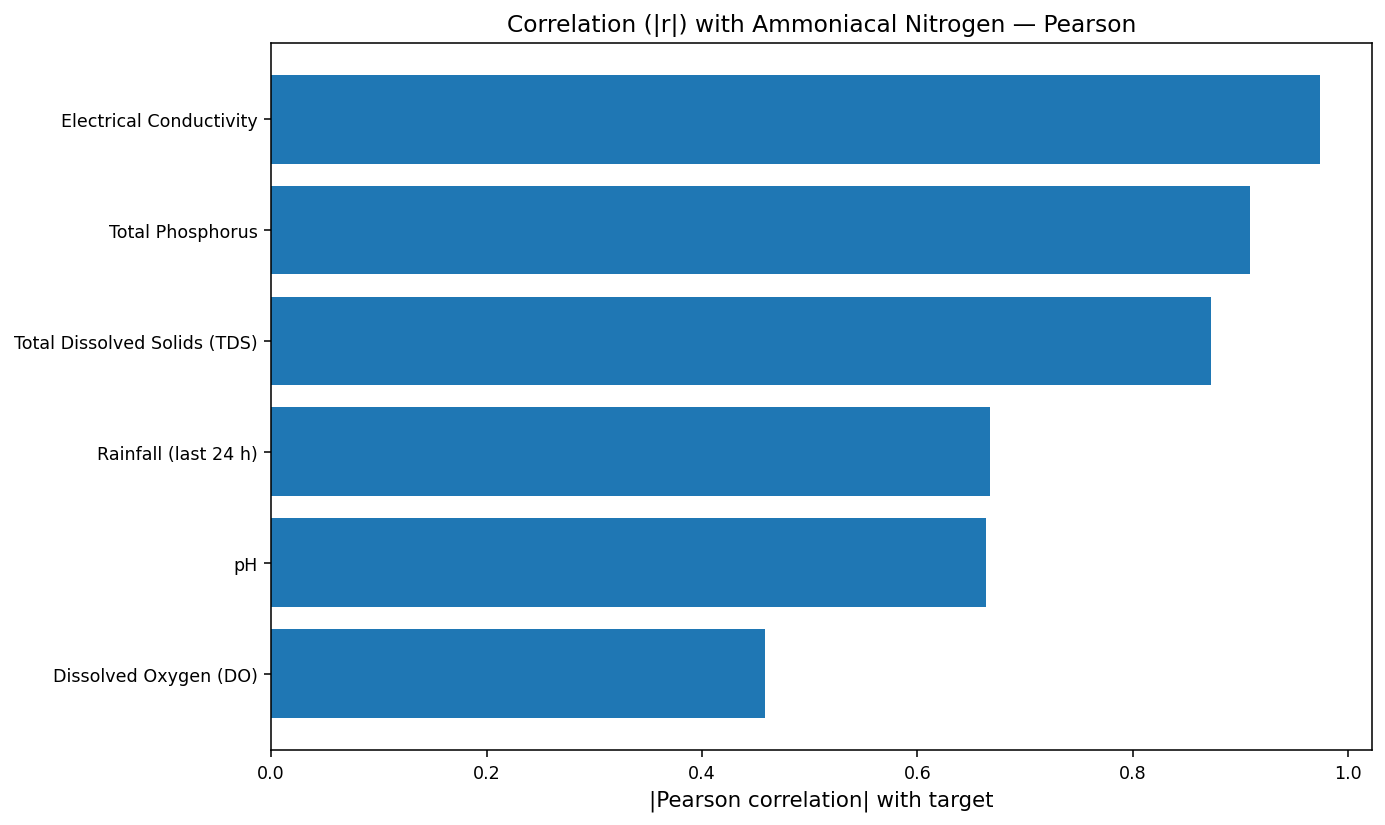

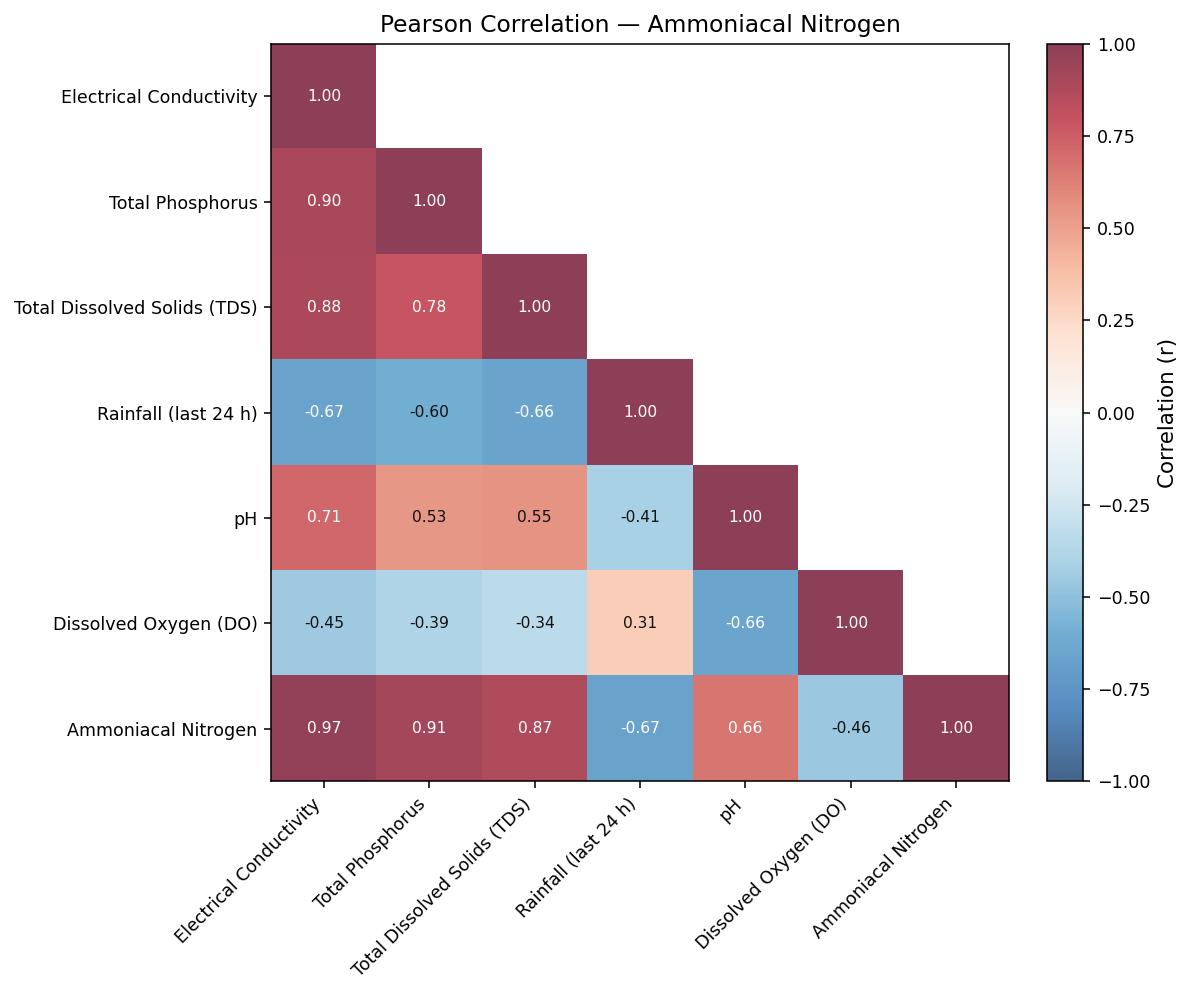

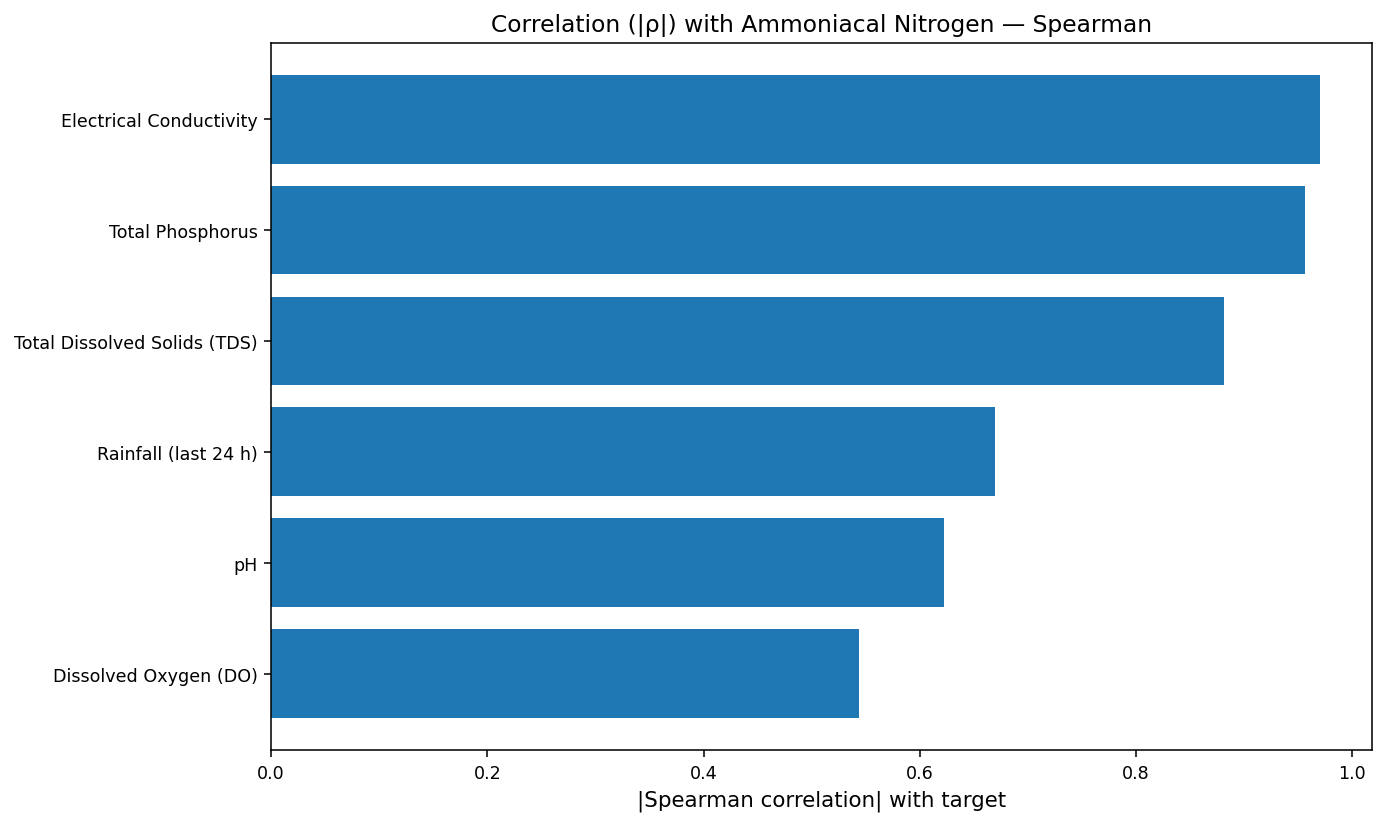

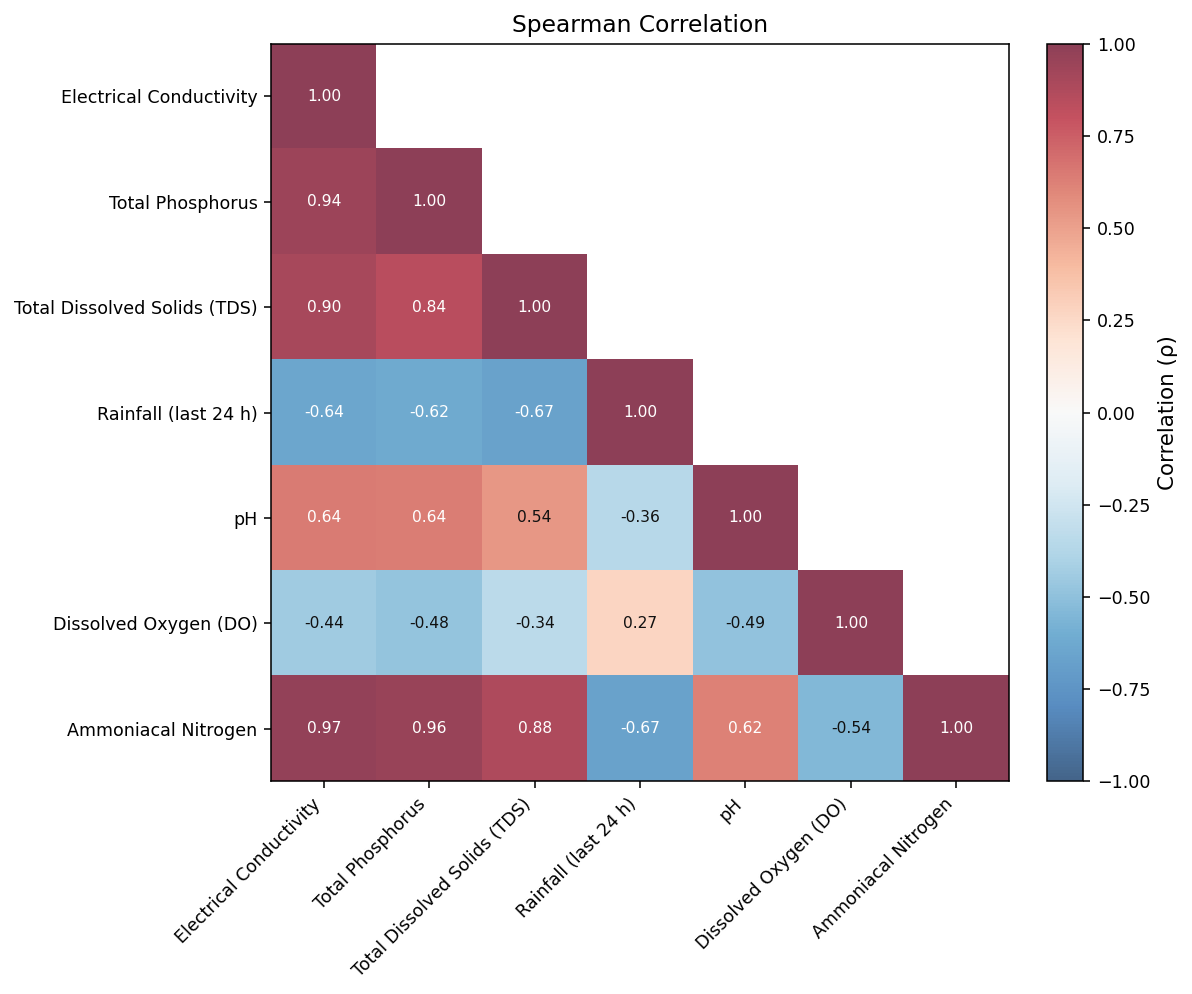


=== TIME SERIES SPLITS (DATES) ===
Total modeling window: 2019-01-09 to 2025-05-06
Total samples used (after non-null target): 28

Fold 1:
  Train: 2019-01-09 -> 2020-02-12  (n=8)
  Test : 2020-10-13  -> 2021-06-28   (n=4)

Fold 2:
  Train: 2019-01-09 -> 2021-06-28  (n=12)
  Test : 2021-09-22  -> 2022-05-12   (n=4)

Fold 3:
  Train: 2019-01-09 -> 2022-05-12  (n=16)
  Test : 2022-08-24  -> 2023-05-17   (n=4)

Fold 4:
  Train: 2019-01-09 -> 2023-05-17  (n=20)
  Test : 2023-08-17  -> 2024-05-02   (n=4)

Fold 5:
  Train: 2019-01-09 -> 2024-05-02  (n=24)
  Test : 2024-08-07  -> 2025-05-06   (n=4)



C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\1989465379.py:582: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\1989465379.py:582: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\1989465379.py:582: FutureWarning: The behavior of array concatenation with


=== METRICS (mean ± std; and OOF) ===
  Model Selector_corr  R2_mean  R2_std    R2_OOF  RMSE_mean  RMSE_std  \
1    RF      spearman      NaN     NaN  0.843174        NaN       NaN   
2   XGB      spearman      NaN     NaN  0.807873        NaN       NaN   
0   MLP      spearman      NaN     NaN  0.774721        NaN       NaN   

   RMSE_OOF  MAE_mean  MAE_std  ...  MAPE_OOF(%)  R_mean(Pearson)  \
1  2.769846       NaN      NaN  ...    12.665261              NaN   
2  3.065785       NaN      NaN  ...    15.893500              NaN   
0  3.319768       NaN      NaN  ...    25.659471              NaN   

   R_std(Pearson)  R_OOF(Pearson)  R_mean(Spearman)  R_std(Spearman)  \
1             NaN        0.946775               NaN              NaN   
2             NaN        0.951184               NaN              NaN   
0             NaN        0.884699               NaN              NaN   

   R_OOF(Spearman)  CCC_mean  CCC_std   CCC_OOF  
1         0.950376       NaN      NaN  0.910410  
2 

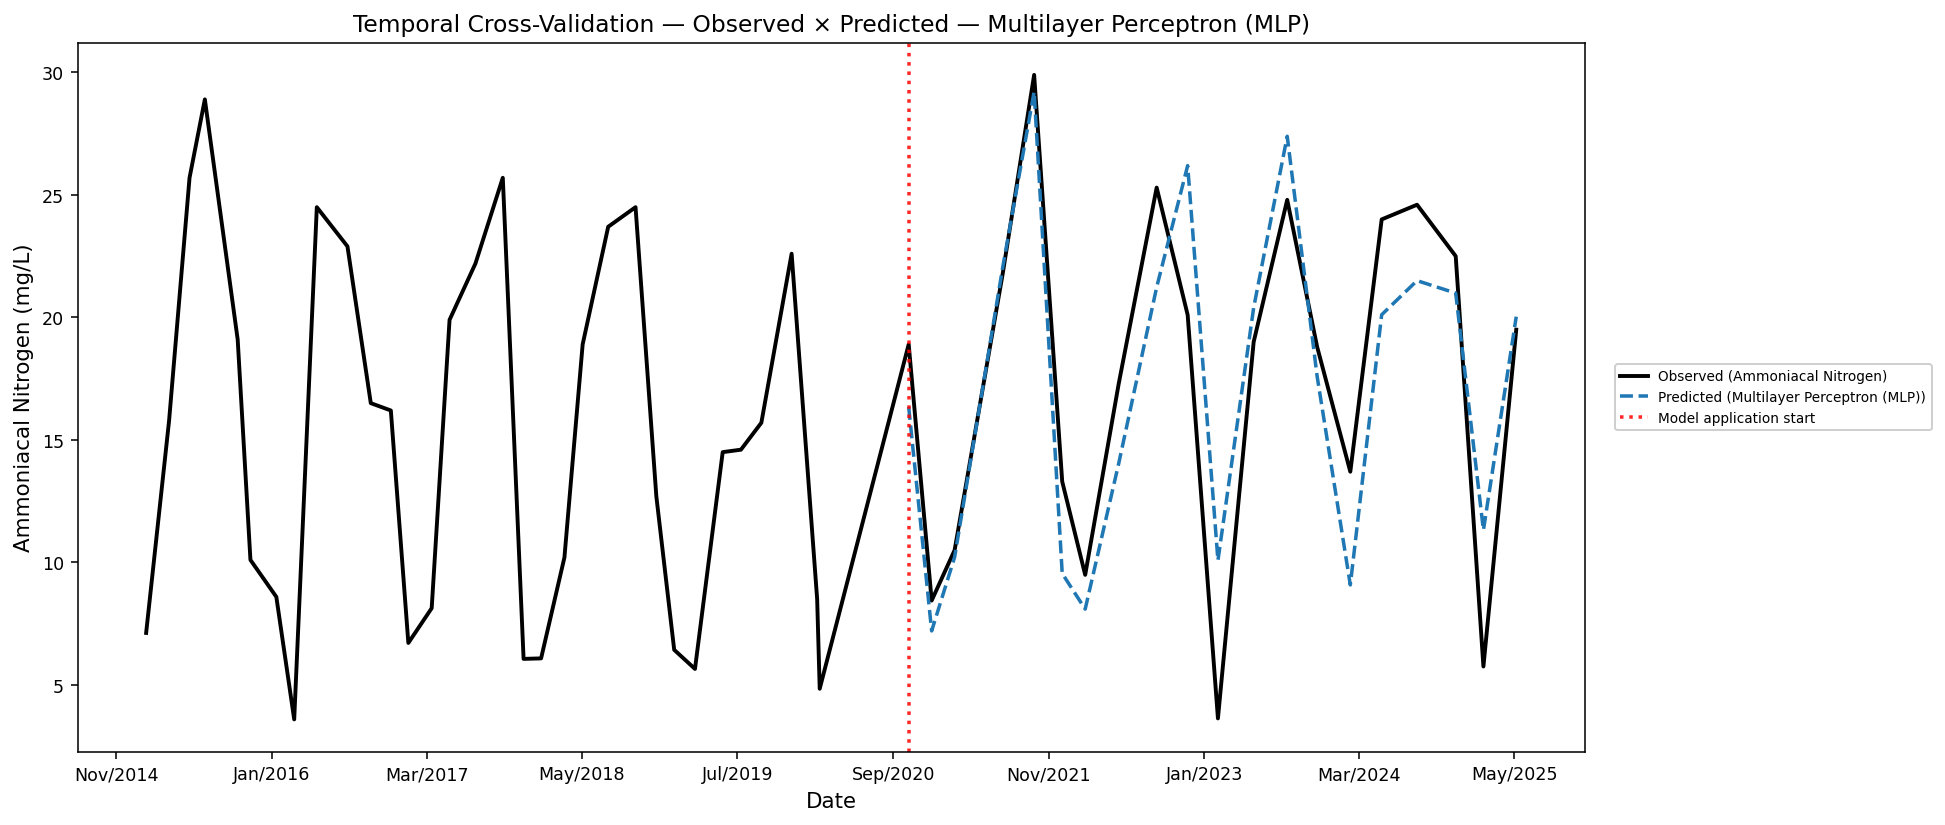

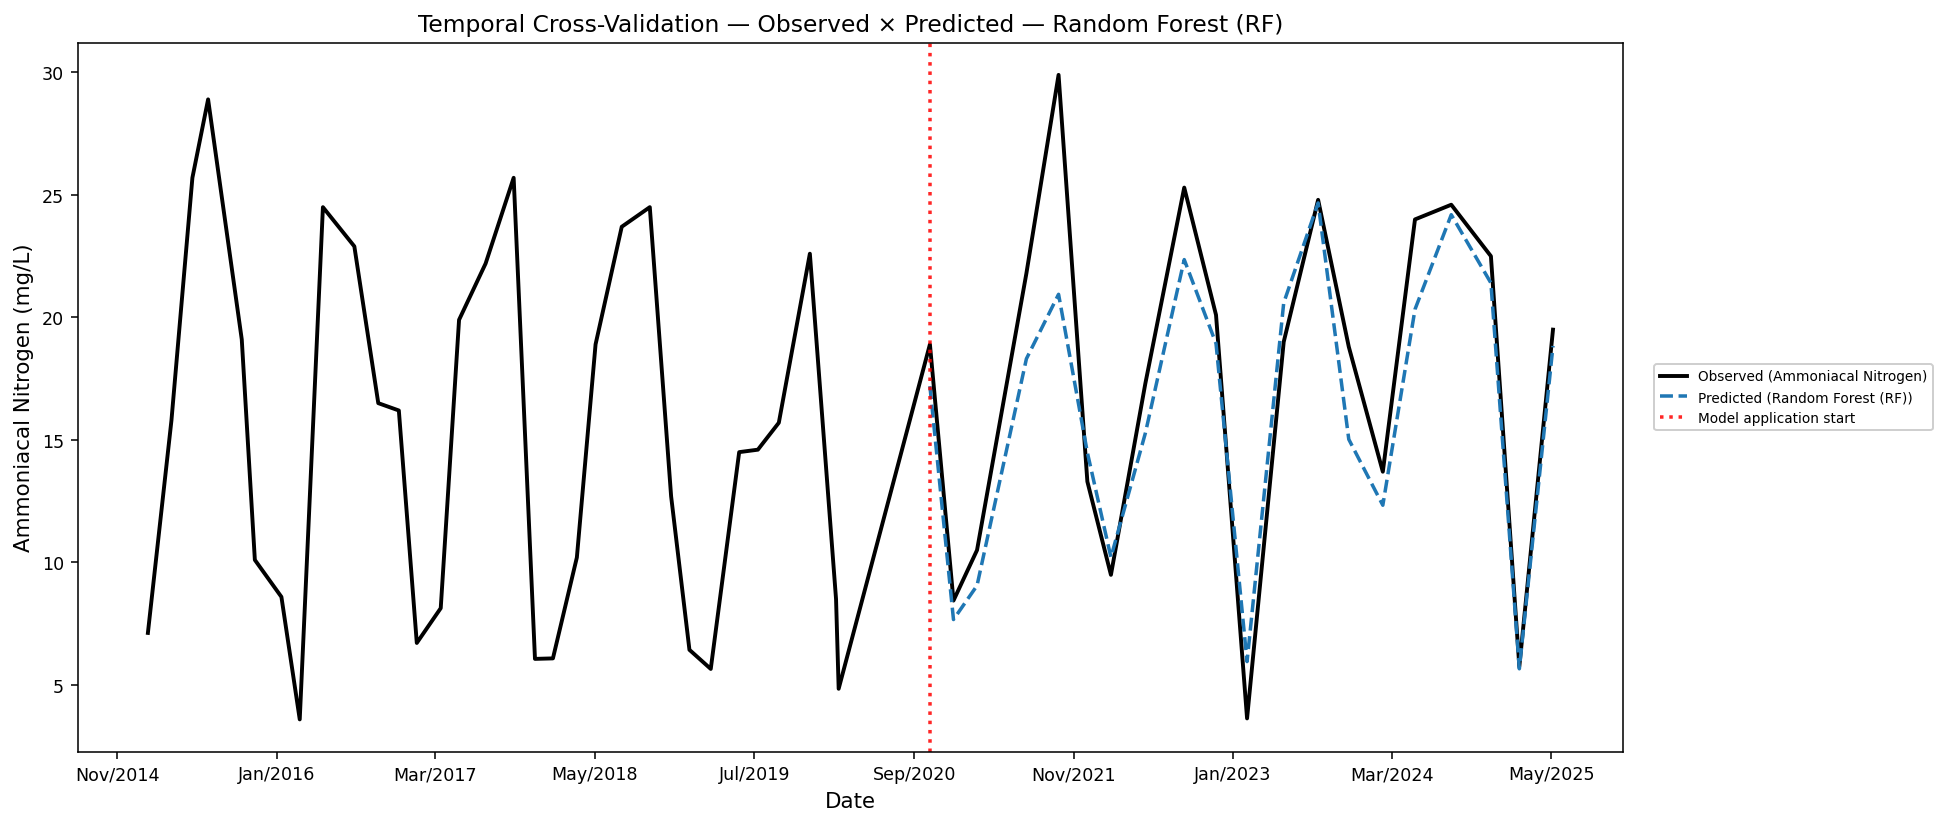

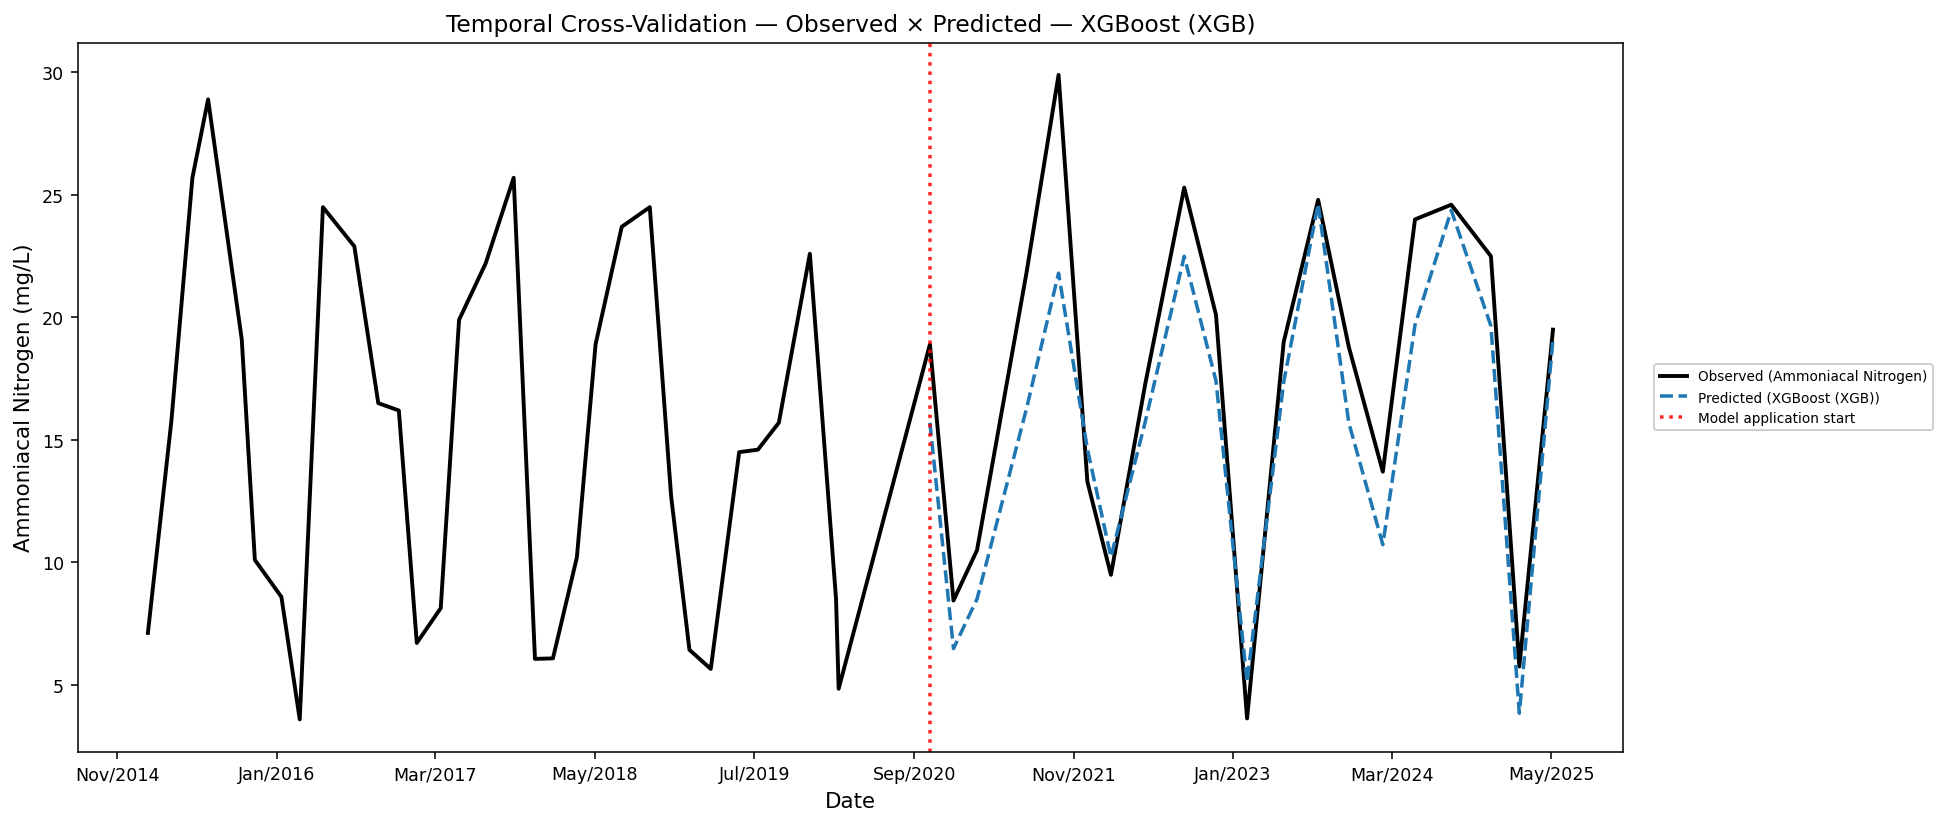

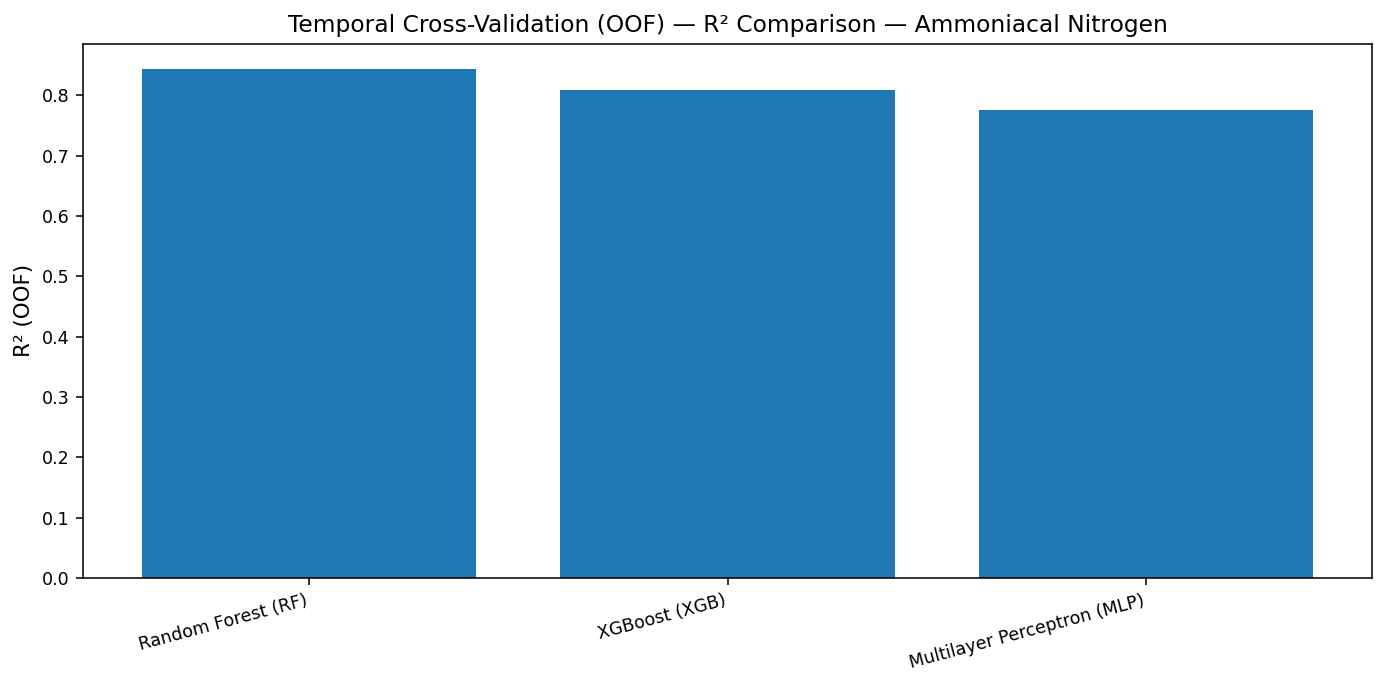

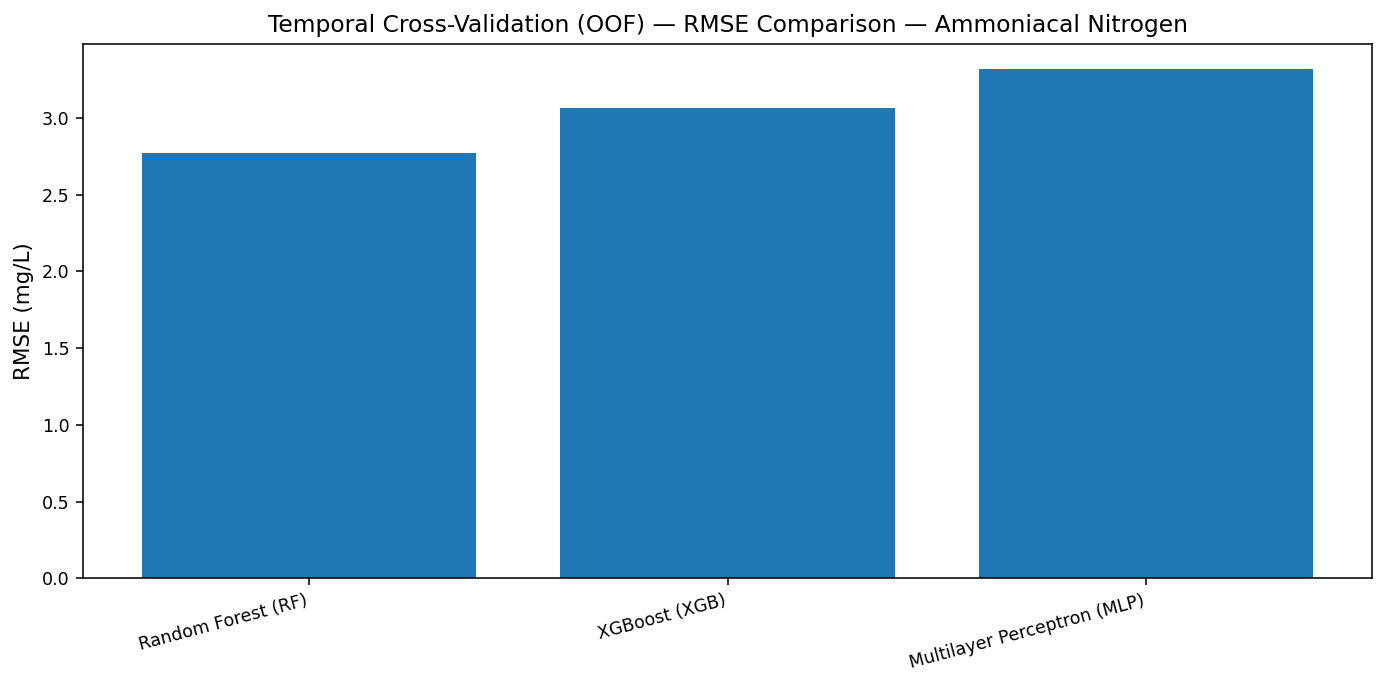

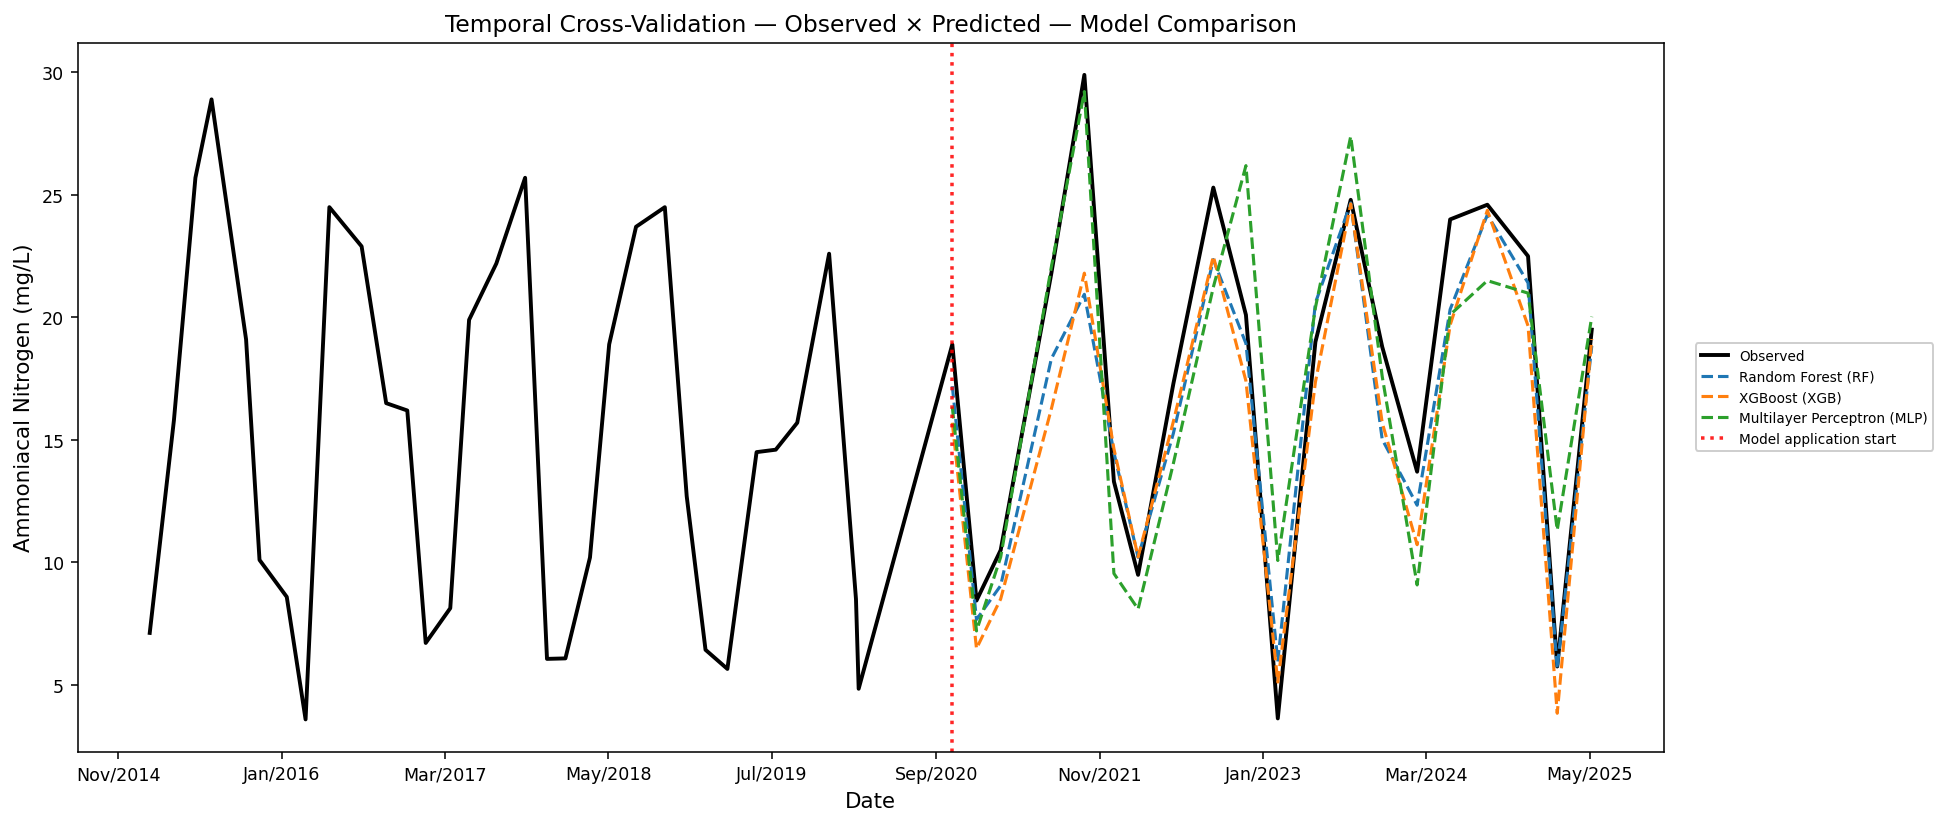

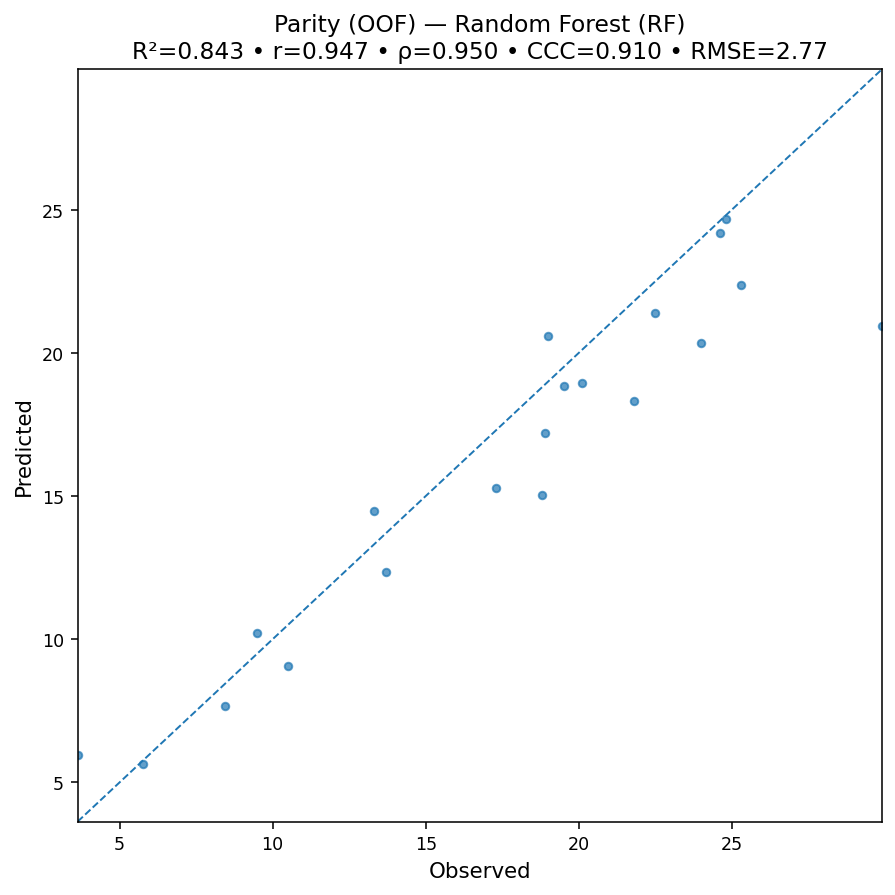

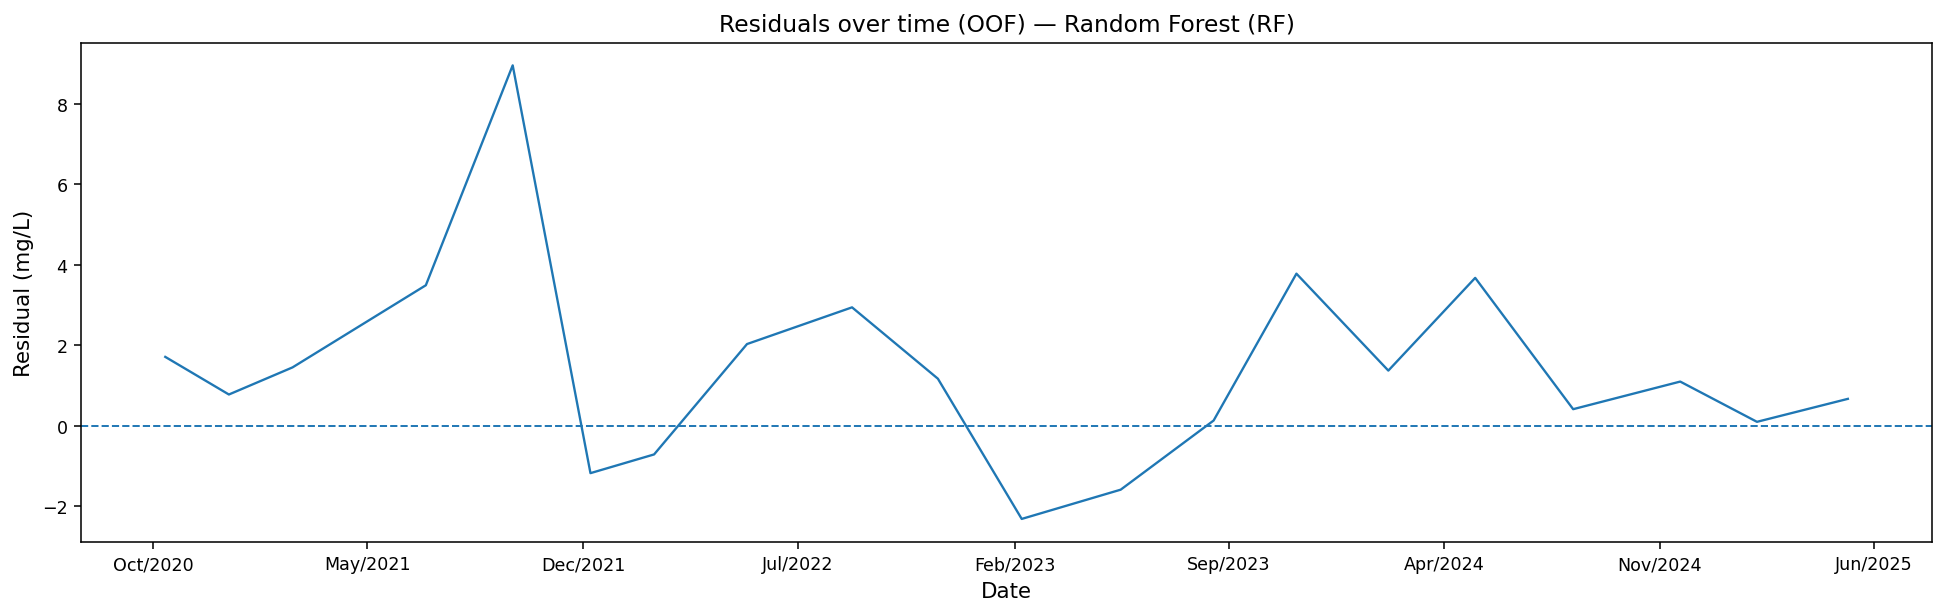

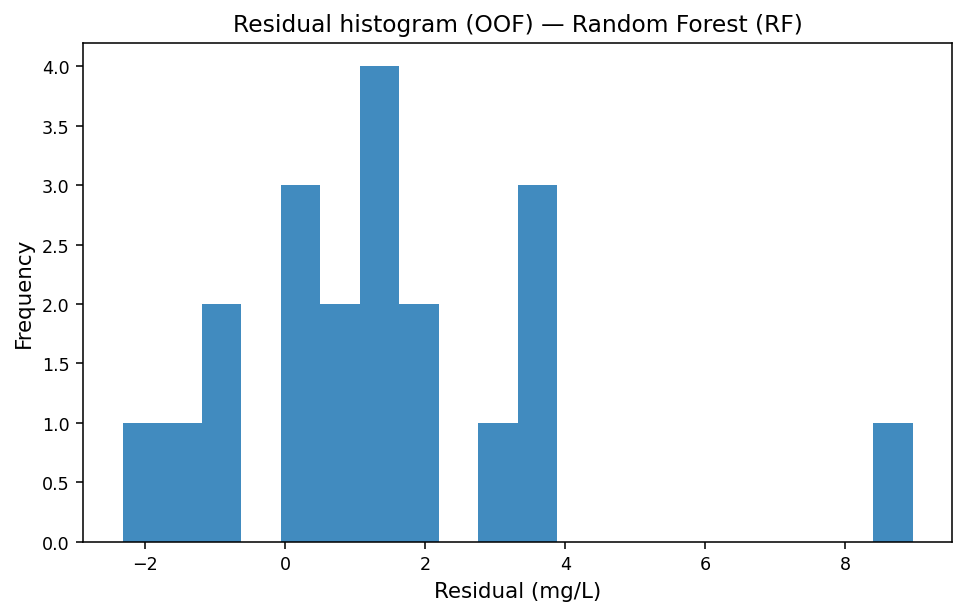

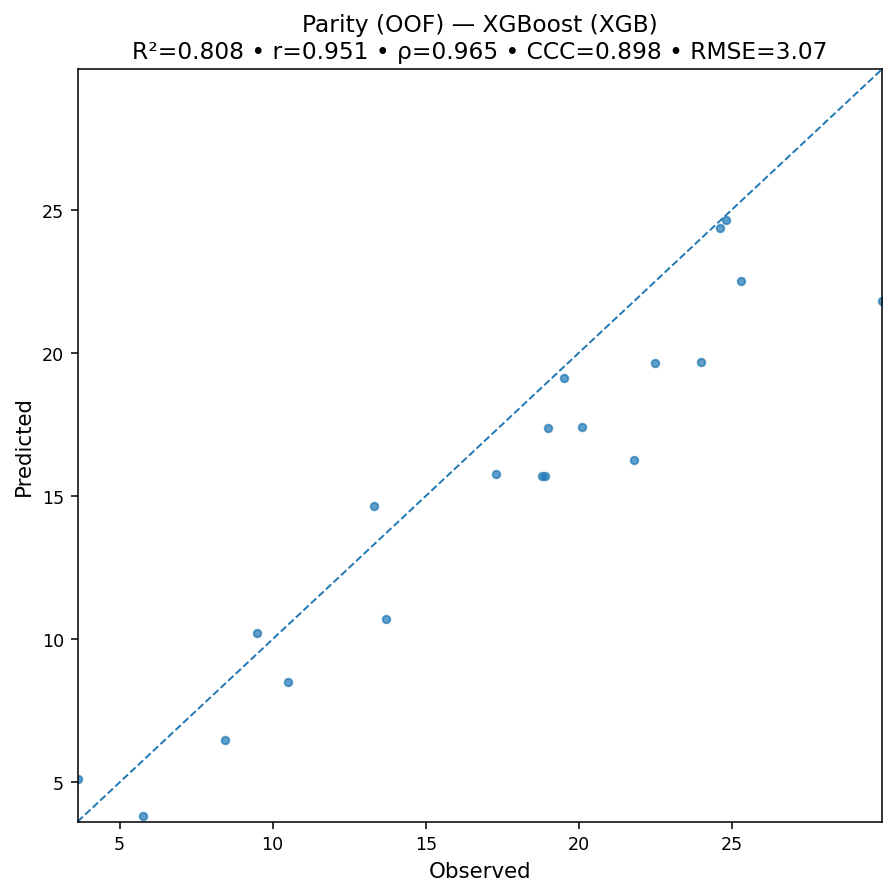

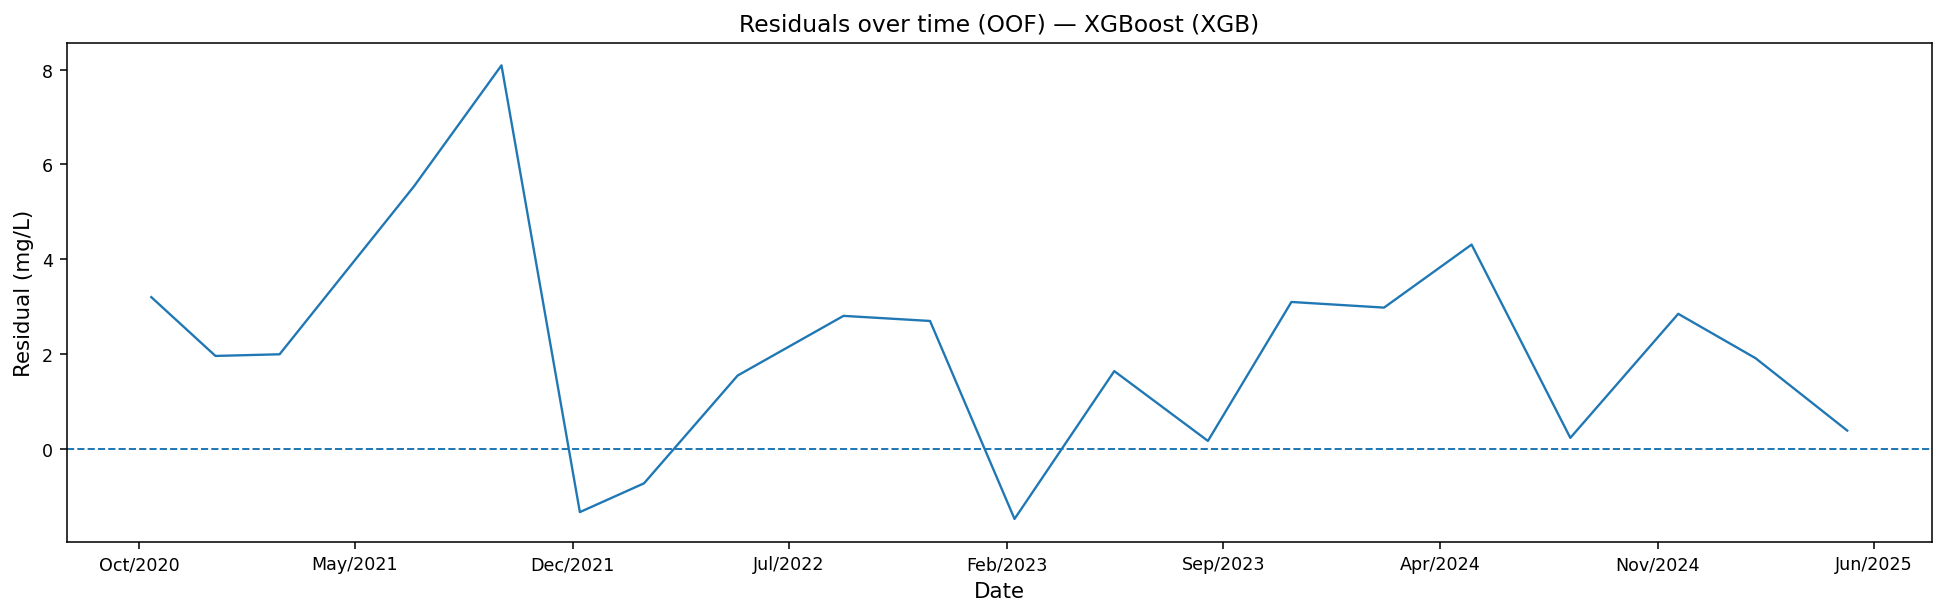

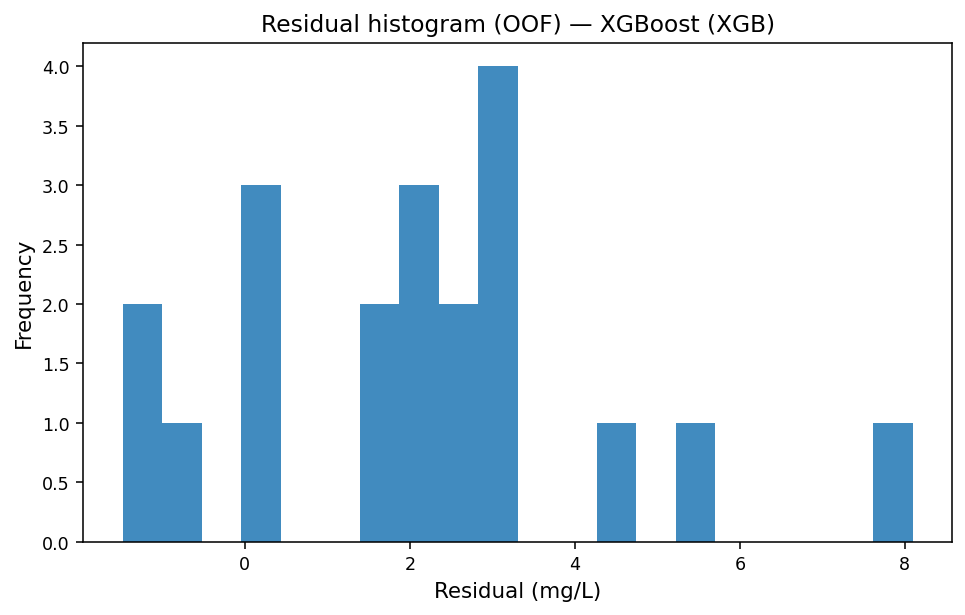

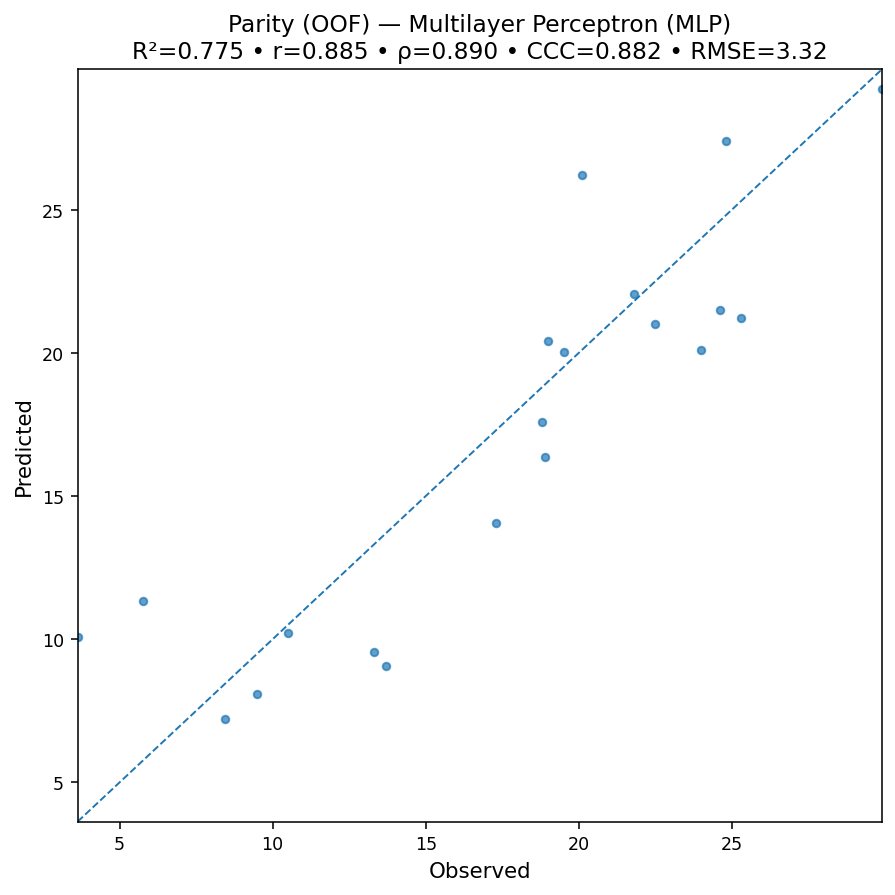

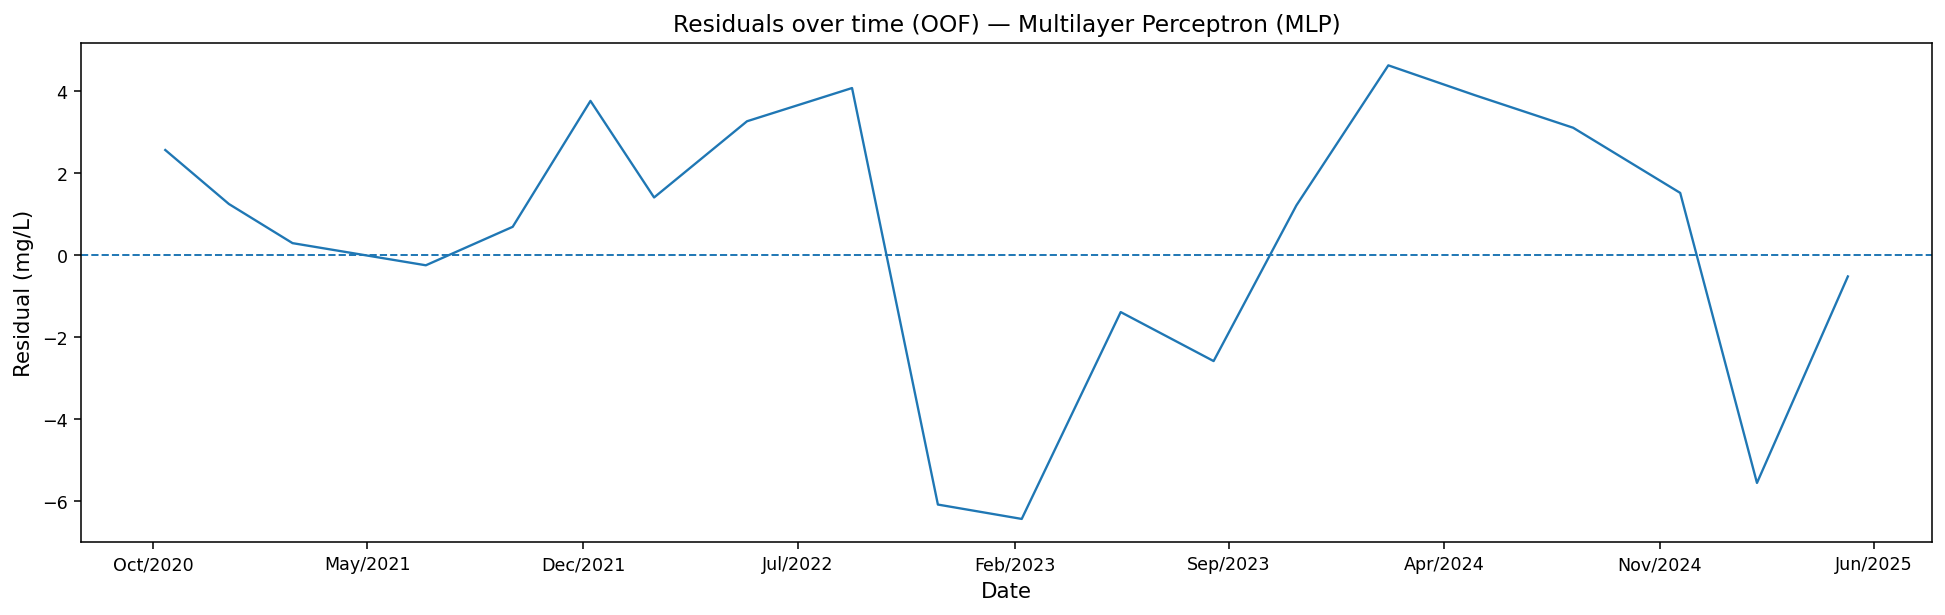

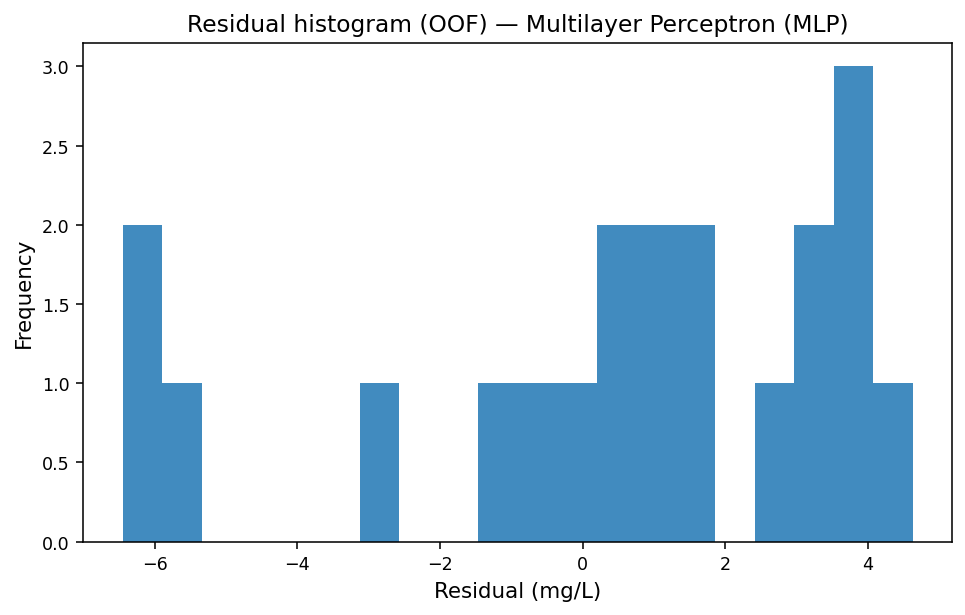

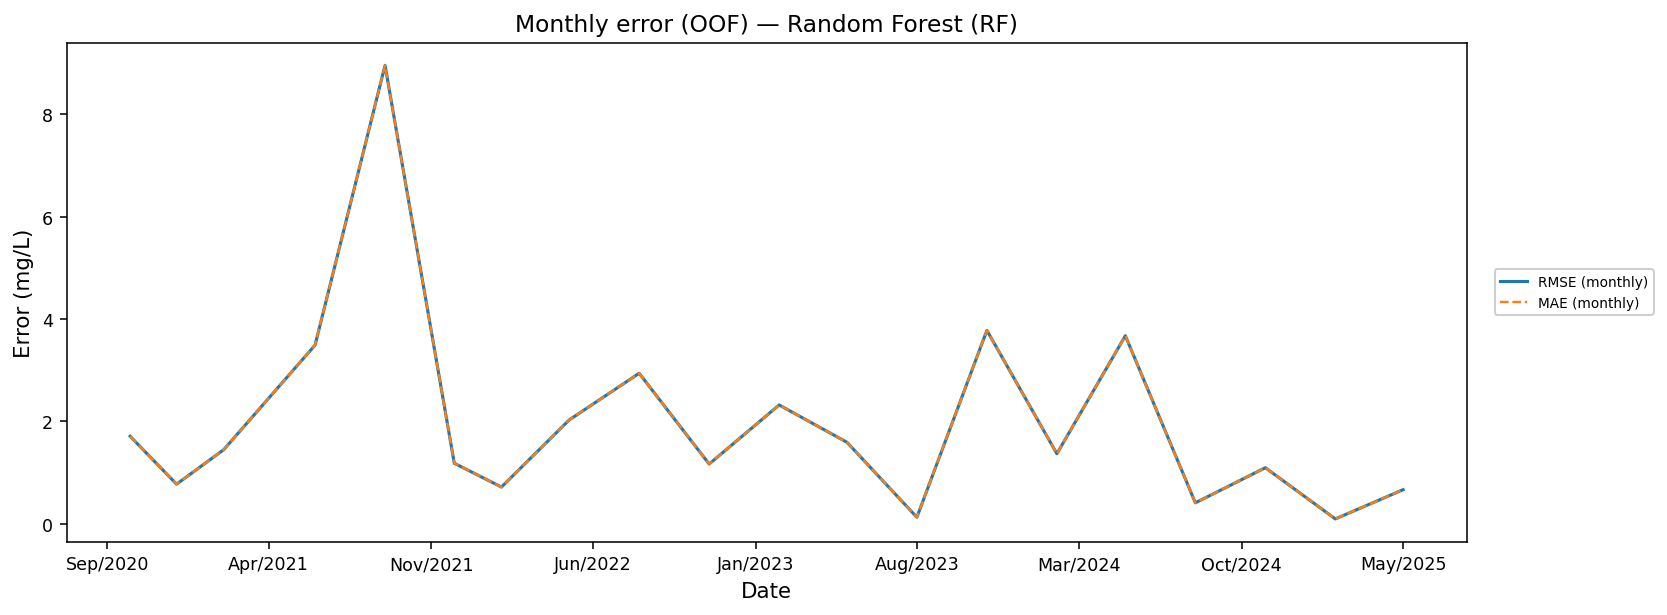

[INFO] Dynamic backtesting — Window 1: train up to 2023-02-07 and predict from 2023-02-08 to 2025-05-06


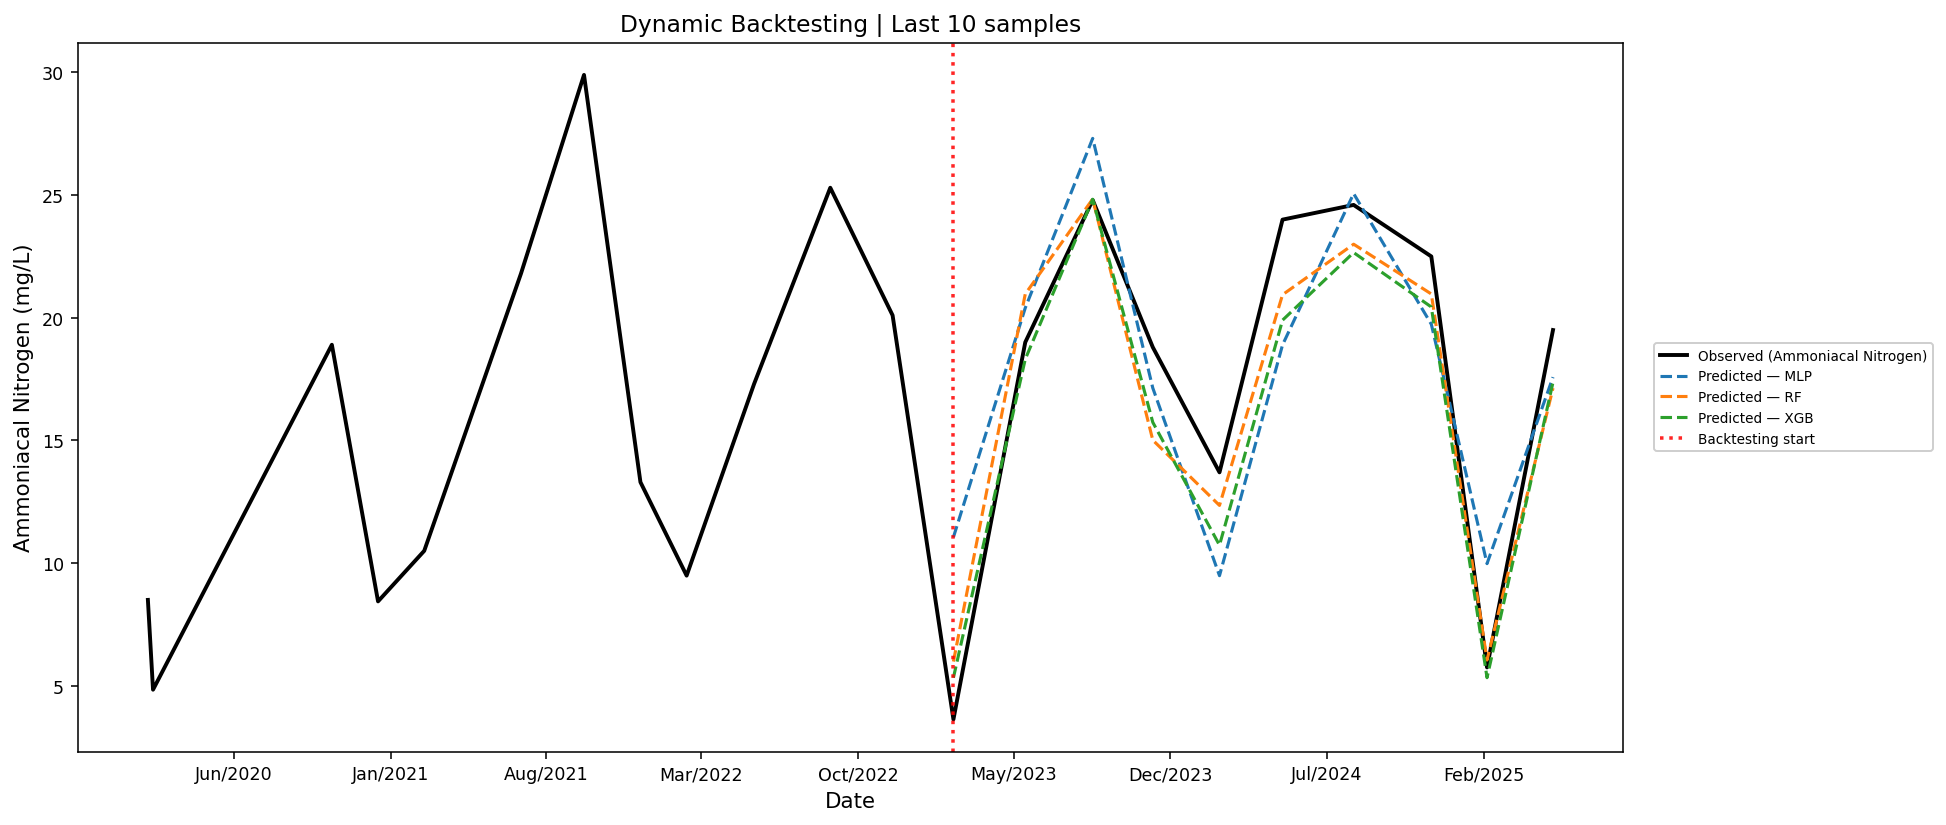

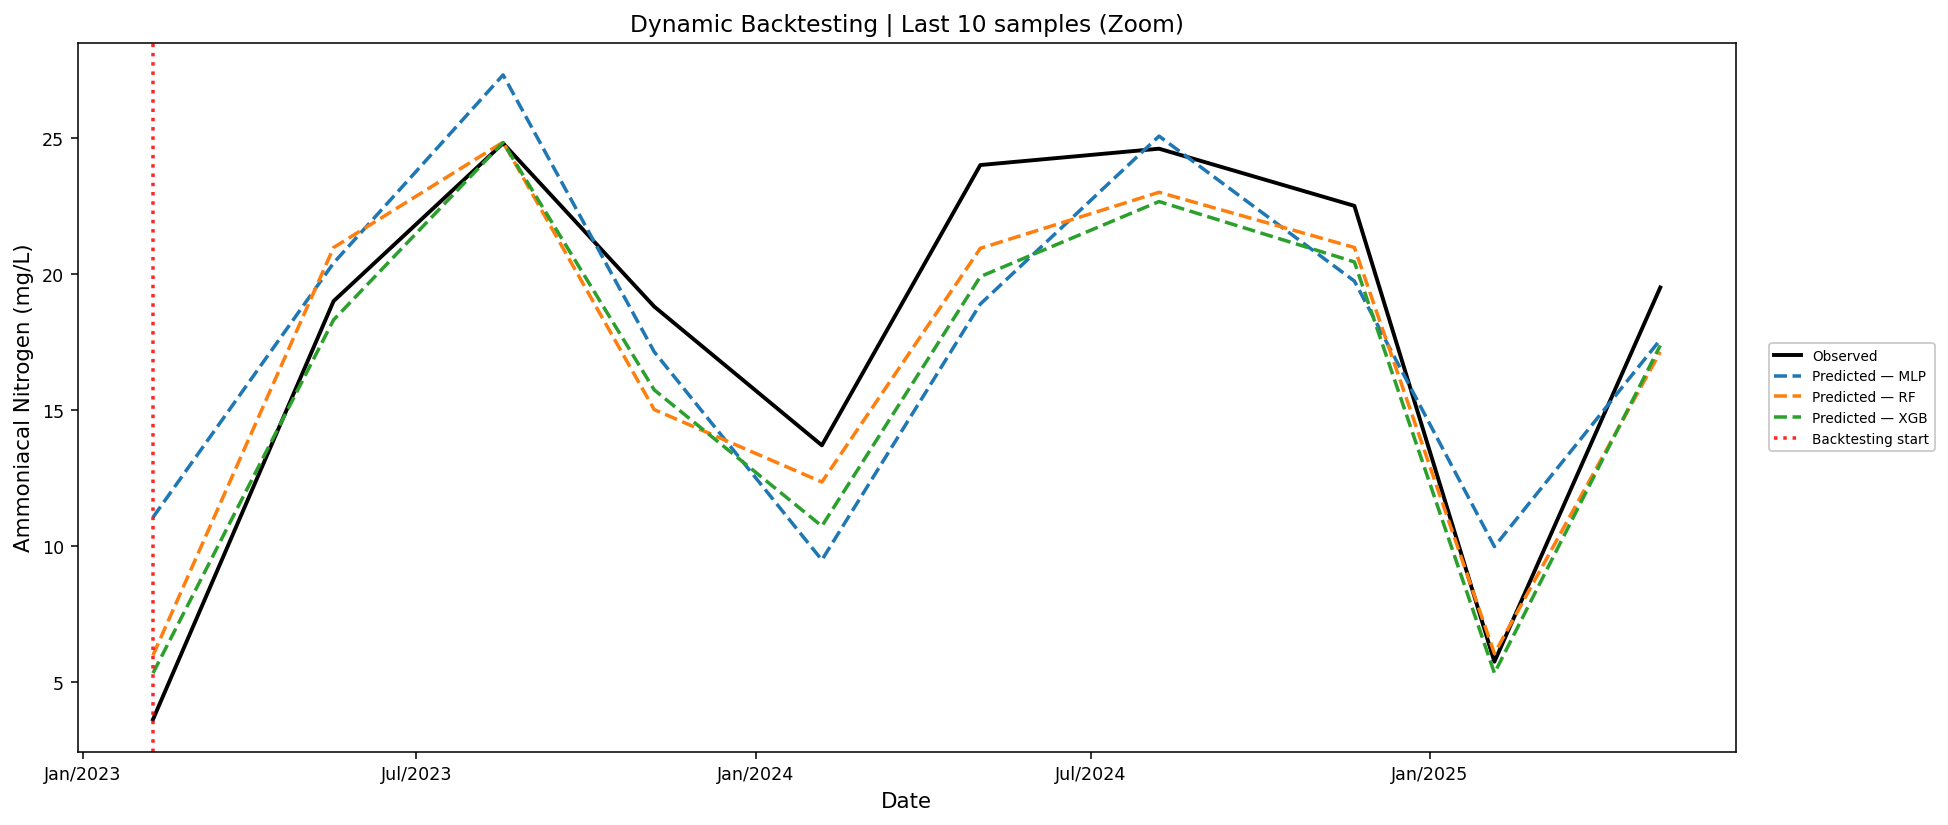

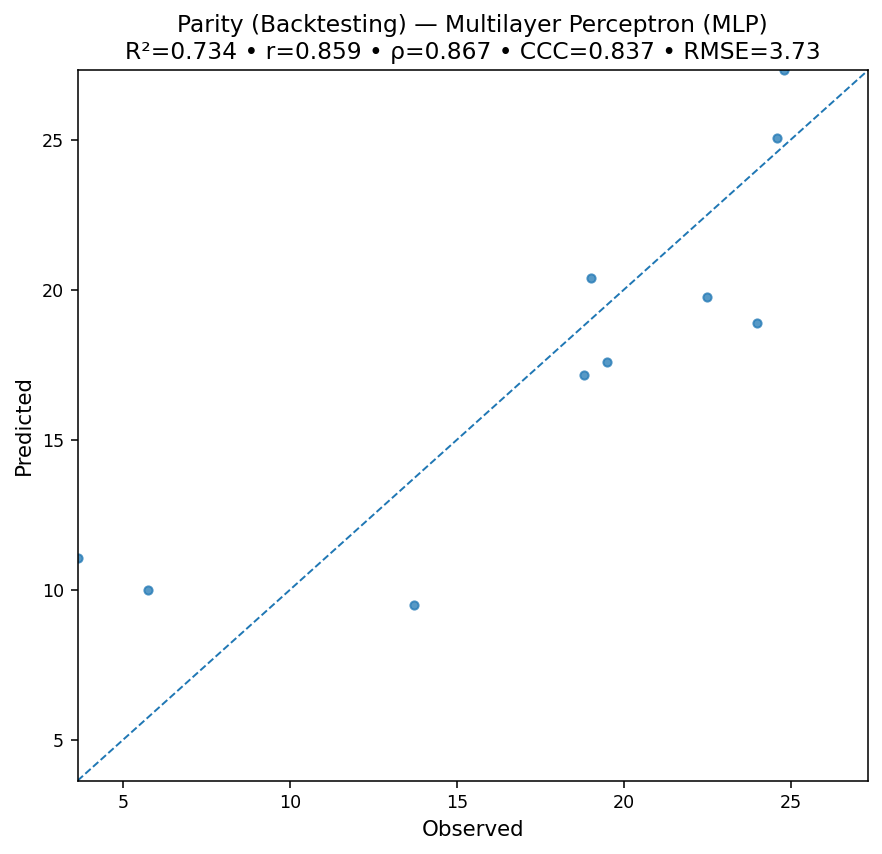

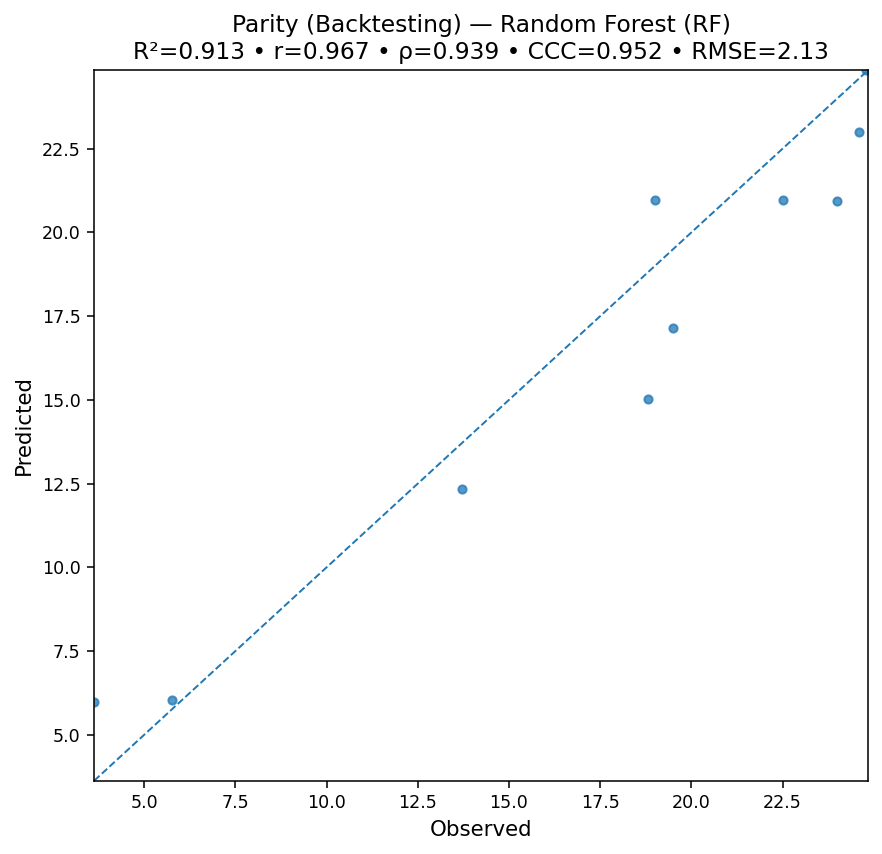

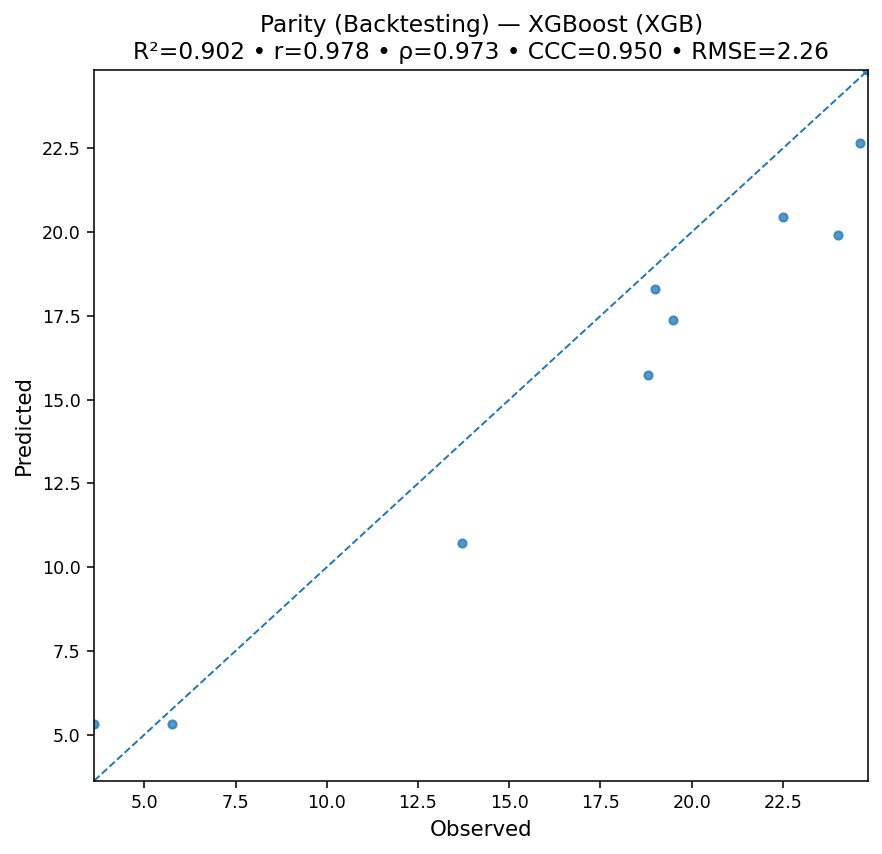


=== BACKTESTING METRICS (dynamic — last points) ===
   Window       Start         End Model        R2         R   R_spear  \
0       1  2023-02-08  2025-05-06   MLP  0.733704  0.858959  0.866667   
1       1  2023-02-08  2025-05-06    RF  0.912996  0.967073  0.939394   
2       1  2023-02-08  2025-05-06   XGB  0.902474  0.977712  0.972649   

        CCC      RMSE       MAE       MAPE        MSE  
0  0.836847  3.734085  3.169589  38.049296  13.943391  
1  0.952477  2.134383  1.835985  14.884852   4.555593  
2  0.949650  2.259755  1.909845  14.087133   5.106490  


In [5]:
# -*- coding: utf-8 -*-
"""
TCC/Thesis – Ammoniacal Nitrogen Prediction (TIET04200)
RF / XGB (optional) / MLP + leakage-free temporal pipeline
Pearson + Spearman + Dynamic backtesting (last N points)

All labels (titles, axes, legends) are in ENGLISH.
Parameter names coming from Excel remain in PT (as in your sheet), but are DISPLAYED in English via label_param().

LATEST ADJUSTMENTS (requested):
1) Backtesting plots: VISUAL context only since 2020 (training unchanged).
2) Remove gray gridlines (no axes grid).
3) Red vertical line: more visible (higher alpha + slightly thicker).
4) Legend font smaller (at least -2) and ALWAYS on the right side.
"""

import os, warnings, re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# =========================
# XGBoost (optional)
# =========================
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    warnings.warn("xgboost not found. The XGB model will be skipped.")

# =========================
# PARAMETERS
# =========================
FILE_PATH   = r"C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx"
SHEET_NAME  = "Planilha1"

TARGET_PARAM_PT = "Nitrogênio Amoniacal"          # as in Excel
TARGET_LABEL_EN = "Ammoniacal Nitrogen"           # display label

# Modeling starts here (UNCHANGED)
MIN_YEAR = 2019

# ---- PLOTTING ONLY: OOF/series show observed since 2015 (illustration)
PLOT_SERIES_START_DATE = "2015-01-01"

# Backtesting visual context (ONLY) since 2020
BACKTEST_VIS_START_DATE = "2020-01-01"

# Other plots (residuals/monthly error etc.) keep as-is
PLOT_START_DATE = "2019-01-01"

N_SPLITS = 5
TOP_K = 5
USE_SEASON_DUMMIES = True

# Feature selector correlation method: 'pearson' or 'spearman'
CORR_SELECTOR_METHOD = "spearman"

# Dynamic backtesting
BACKTEST_POINTS = 10

OUTPUT_DIR = "tcc_results"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

MODEL_NAME_MAP = {
    "MLP": "Multilayer Perceptron (MLP)",
    "RF":  "Random Forest (RF)",
}
if HAS_XGB:
    MODEL_NAME_MAP["XGB"] = "XGBoost (XGB)"

# =========================
# PARAMETER TRANSLATION (PT -> EN) FOR PLOTS
# =========================
def _normalize_key(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s+", " ", s)
    s_nfkd = unicodedata.normalize("NFKD", s)
    s_noacc = "".join(ch for ch in s_nfkd if not unicodedata.combining(ch))
    return s_noacc.lower().strip()

_NORM_TRANSLATIONS = {
    _normalize_key("Chuvas nas últimas 24h"): "Rainfall (last 24 h)",
    _normalize_key("Condutividade"): "Electrical Conductivity",
    _normalize_key("OD"): "Dissolved Oxygen (DO)",
    _normalize_key("pH"): "pH",
    _normalize_key("Fósforo Total"): "Total Phosphorus",
    _normalize_key("Nitrogênio Amoniacal"): "Ammoniacal Nitrogen",
    _normalize_key("Sólido Dissolvido Total"): "Total Dissolved Solids (TDS)",
}

def label_param(name: str) -> str:
    raw = "" if name is None else str(name)
    k = _normalize_key(raw)

    if k in _NORM_TRANSLATIONS:
        return _NORM_TRANSLATIONS[k]

    # Fallbacks
    if ("chuva" in k or "chuvas" in k) and ("24" in k):
        return "Rainfall (last 24 h)"
    if ("solido" in k or "solidos" in k) and ("dissolv" in k):
        return "Total Dissolved Solids (TDS)"
    if k in {"od", "do"}:
        return "Dissolved Oxygen (DO)"

    return raw

# =========================
# FIGURE STYLE (NO GRIDLINES)
# =========================
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "axes.grid": False,      # remove grid
    "grid.alpha": 0.0,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.frameon": True,
    "legend.framealpha": 0.95,
    "legend.facecolor": "white",
})

# Legend font smaller (at least -2 from previous 9 => use 7)
LEGEND_FONTSIZE = 7

# =========================
# Date axis in EN (Month/Year)
# =========================
EN_MONTHS = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def format_time_axis_en(ax, month_interval=3, auto=True, max_ticks=8):
    if auto:
        xmin, xmax = ax.get_xlim()
        dmin = mdates.num2date(xmin)
        dmax = mdates.num2date(xmax)
        months = max(1, (dmax.year - dmin.year) * 12 + (dmax.month - dmin.month) + 1)
        interval = max(1, int(np.ceil(months / max_ticks)))
    else:
        interval = month_interval

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))

    def _fmt(x, pos=None):
        d = mdates.num2date(x)
        return f"{EN_MONTHS[d.month-1]}/{d.year}"

    ax.xaxis.set_major_formatter(FuncFormatter(_fmt))

# =========================
# RED VERTICAL MARKER (more visible)
# =========================
def add_red_marker(ax, x, label="Model application start"):
    if x is None:
        return
    x = pd.to_datetime(x)
    ax.axvline(
        x,
        color="red",
        linewidth=1.8,   # more visible
        alpha=0.85,      # more visible
        linestyle=":",
        label=label
    )

# =========================
# Legend always to the right
# =========================
def legend_right(ax, ncol=1):
    """
    Put legend outside the axes, right side, vertically centered.
    """
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        ncol=ncol,
        fontsize=LEGEND_FONTSIZE
    )

# =========================
# HELPERS
# =========================
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def pearson_r(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size < 2:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def spearman_rho(a, b):
    """Spearman without scipy: Pearson over ranks."""
    a = pd.Series(np.asarray(a, dtype=float))
    b = pd.Series(np.asarray(b, dtype=float))
    if a.size < 2:
        return np.nan
    ra = a.rank(method="average")
    rb = b.rank(method="average")
    return float(np.corrcoef(ra, rb)[0, 1])

def ccc_lin(y_true, y_pred):
    """Concordance Correlation Coefficient (Lin, 1989)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.size < 2:
        return np.nan
    mu_x, mu_y = np.mean(y_true), np.mean(y_pred)
    var_x, var_y = np.var(y_true, ddof=1), np.var(y_pred, ddof=1)
    r = pearson_r(y_true, y_pred)
    denom = var_x + var_y + (mu_x - mu_y) ** 2
    if denom == 0:
        return np.nan
    return float((2 * r * np.sqrt(var_x) * np.sqrt(var_y)) / denom)

def forward_fill_train_test(X_train, X_test):
    X_train = X_train.sort_index()
    X_test = X_test.sort_index()

    X_train_ff = X_train.ffill()
    med = X_train_ff.median(numeric_only=True)
    X_train_ff = X_train_ff.fillna(med)

    if len(X_train_ff) > 0:
        seed = X_train_ff.tail(1)
        X_test_ff = pd.concat([seed, X_test]).ffill().iloc[1:]
    else:
        X_test_ff = X_test.copy()

    X_test_ff = X_test_ff.fillna(med)

    na_cols = list(set(
        X_train_ff.columns[X_train_ff.isna().any()].tolist() +
        X_test_ff.columns[X_test_ff.isna().any()].tolist()
    ))
    if na_cols:
        X_train_ff = X_train_ff.drop(columns=na_cols, errors="ignore")
        X_test_ff  = X_test_ff.drop(columns=na_cols, errors="ignore")

    return X_train_ff, X_test_ff

class RobustClipper(BaseEstimator, TransformerMixin):
    """Column-wise clipping at mean ± lim_std * std (fit on train only)."""
    def __init__(self, lim_std=3.0): self.lim_std = lim_std
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("RobustClipper requires a DataFrame.")
        self.means_ = X.mean()
        stds = X.std().replace(0, 1e-9)
        self.lower_ = self.means_ - self.lim_std * stds
        self.upper_ = self.means_ + self.lim_std * stds
        return self
    def transform(self, X):
        return X.clip(self.lower_, self.upper_, axis=1)

class CorrKSelector(BaseEstimator, TransformerMixin):
    """Select TOP_K base features by |corr| with target (train only). Keeps dummies."""
    def __init__(self, base_cols, dummy_cols, k=5, method="pearson"):
        self.base_cols = base_cols
        self.dummy_cols = dummy_cols
        self.k = k
        self.method = method

    def fit(self, X, y):
        Xb = X[[c for c in self.base_cols if c in X.columns]].copy()
        y_arr = np.asarray(y, dtype=float)
        y_series = pd.Series(y_arr)

        corrs = {}
        for c in Xb.columns:
            x = pd.Series(np.asarray(Xb[c], dtype=float))
            if x.std(ddof=0) < 1e-12:
                corrs[c] = 0.0
            else:
                corrs[c] = spearman_rho(x, y_series) if self.method == "spearman" else pearson_r(x, y_series)

        s = pd.Series(corrs).abs().sort_values(ascending=False)
        self.selected_base_ = s.head(self.k).index.tolist()

        kept_dummies = [c for c in self.dummy_cols if c in X.columns]
        self.out_cols_ = self.selected_base_ + kept_dummies
        return self

    def transform(self, X):
        cols = [c for c in self.out_cols_ if c in X.columns]
        return X[cols]

def build_wide_dataset(filepath, sheet_name, target_param_pt, min_year=2019, use_dummies=True):
    """
    Expected Excel columns (PT):
      - Data (date)
      - Parametro (parameter name)
      - Valor (value)
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    df["Data"] = pd.to_datetime(df["Data"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Data", "Parametro", "Valor"])
    df["Valor"] = df["Valor"].astype(str).str.replace(",", ".", regex=False).astype(float)
    df = df[df["Data"].dt.year >= min_year]

    wide = df.pivot_table(index="Data", columns="Parametro", values="Valor", aggfunc="mean").sort_index()

    if use_dummies:
        wide["Month"] = wide.index.month
        wide["Season"] = wide.index.month % 12 // 3 + 1
        wide = pd.get_dummies(wide, columns=["Month", "Season"], drop_first=True)

    if target_param_pt not in wide.columns:
        raise ValueError(f"Target parameter '{target_param_pt}' not found after pivot.")

    wide = wide.dropna(subset=[target_param_pt])
    y = wide[target_param_pt].copy()
    X = wide.drop(columns=[target_param_pt]).copy()

    dummy_cols = [c for c in X.columns if c.startswith("Month_") or c.startswith("Season_")]
    base_cols = [c for c in X.columns if c not in dummy_cols]

    return X, y, base_cols, dummy_cols

def evaluate_model(y_true, y_pred):
    y_true = pd.Series(y_true).astype(float)
    y_pred = pd.Series(y_pred).astype(float)

    common = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common]
    y_pred = y_pred.loc[common]

    m = y_true.notna() & y_pred.notna()
    y_true = y_true[m].to_numpy()
    y_pred = y_pred[m].to_numpy()

    if y_true.size == 0:
        return dict(MSE=np.nan, RMSE=np.nan, MAE=np.nan, R2=np.nan, MAPE=np.nan,
                    R=np.nan, R_spear=np.nan, CCC=np.nan)

    mse = mean_squared_error(y_true, y_pred)
    return dict(
        MSE=mse,
        RMSE=np.sqrt(mse),
        MAE=mean_absolute_error(y_true, y_pred),
        R2=r2_score(y_true, y_pred),
        MAPE=mape_safe(y_true, y_pred),
        R=pearson_r(y_true, y_pred),
        R_spear=spearman_rho(y_true, y_pred),
        CCC=ccc_lin(y_true, y_pred)
    )

# =========================
# DATA PREP (MODEL DATA) — unchanged
# =========================
X_all, y_all, base_cols_all, dummy_cols_all = build_wide_dataset(
    FILE_PATH, SHEET_NAME, TARGET_PARAM_PT, min_year=MIN_YEAR, use_dummies=USE_SEASON_DUMMIES
)

# =========================
# FULL OBSERVED SERIES (2015+) — context for OOF plots
# =========================
_, y_full_obs, _, _ = build_wide_dataset(
    FILE_PATH, SHEET_NAME, TARGET_PARAM_PT,
    min_year=2015,
    use_dummies=False
)
y_full_obs = y_full_obs.sort_index()

plot_cut_full = pd.to_datetime(PLOT_SERIES_START_DATE)
plot_cut = pd.to_datetime(PLOT_START_DATE)
bt_vis_cut = pd.to_datetime(BACKTEST_VIS_START_DATE)

data_min = pd.to_datetime(y_all.index.min()).date() if len(y_all) else None
data_max = pd.to_datetime(y_all.index.max()).date() if len(y_all) else None
print(f"[INFO] Data (MODEL, after MIN_YEAR={MIN_YEAR} and non-null target): {data_min} to {data_max}")
print(f"[INFO] OOF series plots (Observed context): from {pd.to_datetime(PLOT_SERIES_START_DATE).date()} (illustration only)")
print(f"[INFO] Backtesting plots (Observed context): from {pd.to_datetime(BACKTEST_VIS_START_DATE).date()} (visual only; training unchanged)")
print(f"[INFO] Other plots (residuals/monthly error): from {pd.to_datetime(PLOT_START_DATE).date()}")

# =========================
# CORRELATIONS (Pearson & Spearman) — Top-K + pastel triangular heatmap
# =========================
from matplotlib.colors import ListedColormap
import numpy.ma as ma

def pastelize_cmap(base_cmap="RdBu_r", mix_with=(1,1,1), factor=0.25):
    cmap = plt.get_cmap(base_cmap, 256)
    colors = cmap(np.linspace(0,1,256))
    mix = np.array(list(mix_with) + [1.0])
    colors = (1-factor)*colors + factor*mix
    return ListedColormap(colors)

PASTEL_CMAP = pastelize_cmap("RdBu_r", factor=0.25)

def triangular_corr_plot(df_vars, target_col, method="pearson", top_m=8,
                         title="Correlation", fname="tri_corr.png"):
    corr_full = df_vars.corr(numeric_only=True, method=method)
    if target_col not in corr_full.columns:
        raise ValueError(f"Target '{target_col}' not present in correlation base.")

    abs_corr = corr_full[target_col].drop(index=target_col).abs().sort_values(ascending=False)
    sel = list(abs_corr.head(top_m).index)

    cols_order = sel + [target_col]
    C = df_vars[cols_order].corr(numeric_only=True, method=method).values

    mask = np.triu(np.ones_like(C, dtype=bool), k=1)
    C_masked = ma.array(C, mask=mask)

    disp_labels = [label_param(c) for c in cols_order[:-1]] + [TARGET_LABEL_EN]

    fig, ax = plt.subplots(figsize=(8.8, 7.2))
    im = ax.imshow(C_masked, cmap=PASTEL_CMAP, vmin=-1, vmax=1)

    ax.set_xticks(range(len(cols_order)))
    ax.set_yticks(range(len(cols_order)))
    ax.set_xticklabels(disp_labels, rotation=45, ha="right")
    ax.set_yticklabels(disp_labels)
    ax.set_title(title)
    ax.grid(False)

    n = len(cols_order)
    for i in range(n):
        for j in range(n):
            if j > i:
                continue
            val = C[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8,
                    color="#111" if abs(val) < 0.6 else "white")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation" + (" (r)" if method == "pearson" else " (ρ)"))

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, fname.replace(".png", ".svg")), bbox_inches="tight")
    plt.show()

df_corr_base = pd.concat([X_all[base_cols_all], y_all.rename(TARGET_PARAM_PT)], axis=1).dropna()
top_k_corr = 6

pearson_series = df_corr_base.corr(numeric_only=True, method="pearson")[TARGET_PARAM_PT].drop(TARGET_PARAM_PT)
pearson_abs = pearson_series.abs().sort_values(ascending=False)
top_names_p = pearson_abs.head(top_k_corr).index
top_vals_p = pearson_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed([label_param(n) for n in top_names_p])), list(reversed(top_vals_p)))
ax.set_xlabel("|Pearson correlation| with target")
ax.set_title(f"Correlation (|r|) with {TARGET_LABEL_EN} — Pearson")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "01_pearson_top6_bar.png"), bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "01_pearson_top6_bar.svg"), bbox_inches="tight")
plt.show()

triangular_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM_PT,
    method="pearson",
    top_m=8,
    title=f"Pearson Correlation — {TARGET_LABEL_EN}",
    fname="02_pearson_triangle_pastel.png"
)

spearman_series = df_corr_base.corr(numeric_only=True, method="spearman")[TARGET_PARAM_PT].drop(TARGET_PARAM_PT)
spearman_abs = spearman_series.abs().sort_values(ascending=False)
top_names_s = spearman_abs.head(top_k_corr).index
top_vals_s = spearman_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed([label_param(n) for n in top_names_s])), list(reversed(top_vals_s)))
ax.set_xlabel("|Spearman correlation| with target")
ax.set_title(f"Correlation (|ρ|) with {TARGET_LABEL_EN} — Spearman")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "03_spearman_top6_bar.png"), bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "03_spearman_top6_bar.svg"), bbox_inches="tight")
plt.show()

triangular_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM_PT,
    method="spearman",
    top_m=8,
    title="Spearman Correlation",
    fname="04_spearman_triangle_pastel.png"
)

# =========================
# MODELS
# =========================
models = {
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42),
    "RF": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
}
if HAS_XGB:
    models["XGB"] = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    )

# =========================
# TEMPORAL CV (OOF)
# =========================
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
metrics_by_model = {name: [] for name in models}
oof_preds_by_model = {name: pd.Series(dtype=float) for name in models}
oof_truth = pd.Series(dtype=float)

print("\n=== TIME SERIES SPLITS (DATES) ===")
print(f"Total modeling window: {X_all.index.min().date()} to {X_all.index.max().date()}")
print(f"Total samples used (after non-null target): {len(X_all)}\n")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all), start=1):
    train_dates = X_all.index[train_idx]
    test_dates  = X_all.index[test_idx]
    print(f"Fold {fold}:")
    print(f"  Train: {train_dates.min().date()} -> {train_dates.max().date()}  (n={len(train_dates)})")
    print(f"  Test : {test_dates.min().date()}  -> {test_dates.max().date()}   (n={len(test_dates)})\n")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all), start=1):
    X_train_raw = X_all.iloc[train_idx].copy()
    X_test_raw  = X_all.iloc[test_idx].copy()
    y_train = y_all.iloc[train_idx].copy()
    y_test  = y_all.iloc[test_idx].copy()

    if y_test.isna().any():
        y_test = y_test.dropna()
        X_test_raw = X_test_raw.loc[y_test.index]
    if len(y_test) < 2:
        continue

    X_train_filled, X_test_filled = forward_fill_train_test(X_train_raw, X_test_raw)

    clipper = RobustClipper(lim_std=3.0).fit(X_train_filled)
    X_train_clip = clipper.transform(X_train_filled)
    X_test_clip  = clipper.transform(X_test_filled)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_train_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_train_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_train_clip, y_train)

    X_train_sel = selector.transform(X_train_clip)
    X_test_sel  = selector.transform(X_test_clip)

    scaler = StandardScaler().fit(X_train_sel)
    X_train_scaled = scaler.transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

    for name, model in models.items():
        mdl = clone(model)
        mdl.fit(X_train_scaled, y_train)

        if len(X_test_sel) == 0 or len(y_test) == 0:
            continue

        y_pred = mdl.predict(X_test_scaled)
        fold_metrics = evaluate_model(y_test, y_pred)

        if not np.isnan(fold_metrics["R2"]):
            metrics_by_model[name].append(fold_metrics)

        idx_test = X_test_sel.index
        oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])

    oof_truth = pd.concat([oof_truth, pd.Series(y_test.values, index=y_test.index)])

# =========================
# METRIC AGGREGATION (mean±std + OOF)
# =========================
rows = []
for name in models.keys():
    lst = metrics_by_model.get(name, [])
    def _avg(k): return np.mean([d[k] for d in lst]) if lst else np.nan
    def _std(k): return np.std([d[k] for d in lst]) if lst else np.nan

    y_pred_oof = oof_preds_by_model[name].sort_index()
    y_true_oof = oof_truth.loc[y_pred_oof.index].sort_index()
    oof_metrics = evaluate_model(y_true_oof, y_pred_oof)

    last_topk = ", ".join(getattr(selector, "selected_base_", [])) if "selector" in locals() else ""

    rows.append({
        "Model": name,
        "R2_mean": _avg("R2"), "R2_std": _std("R2"), "R2_OOF": oof_metrics["R2"],
        "RMSE_mean": _avg("RMSE"), "RMSE_std": _std("RMSE"), "RMSE_OOF": oof_metrics["RMSE"],
        "MAE_mean": _avg("MAE"), "MAE_std": _std("MAE"), "MAE_OOF": oof_metrics["MAE"],
        "MSE_mean": _avg("MSE"), "MSE_std": _std("MSE"), "MSE_OOF": oof_metrics["MSE"],
        "MAPE_mean(%)": _avg("MAPE"), "MAPE_std(%)": _std("MAPE"), "MAPE_OOF(%)": oof_metrics["MAPE"],
        "R_mean(Pearson)": _avg("R"), "R_std(Pearson)": _std("R"), "R_OOF(Pearson)": oof_metrics["R"],
        "R_mean(Spearman)": _avg("R_spear"), "R_std(Spearman)": _std("R_spear"), "R_OOF(Spearman)": oof_metrics["R_spear"],
        "CCC_mean": _avg("CCC"), "CCC_std": _std("CCC"), "CCC_OOF": oof_metrics["CCC"],
        "TopK_features(last_fold)": last_topk,
        "Selector_corr": CORR_SELECTOR_METHOD
    })

df_metrics = pd.DataFrame(rows)
sort_key = "RMSE_mean" if ("RMSE_mean" in df_metrics.columns and not df_metrics["RMSE_mean"].isna().all()) else "RMSE_OOF"
df_metrics = df_metrics.sort_values(by=sort_key)

os.makedirs(OUTPUT_DIR, exist_ok=True)
df_metrics.to_csv(os.path.join(OUTPUT_DIR, "model_metrics.csv"), index=False, sep=";")
try:
    df_fmt = df_metrics.copy()
    for c in df_fmt.columns:
        if c not in ["Model", "TopK_features(last_fold)", "Selector_corr"]:
            df_fmt[c] = pd.to_numeric(df_fmt[c], errors="ignore")
            if pd.api.types.is_float_dtype(df_fmt[c]):
                df_fmt[c] = df_fmt[c].round(4)
    df_fmt.to_excel(os.path.join(OUTPUT_DIR, "model_metrics.xlsx"), index=False)
except Exception:
    pass

print("\n=== METRICS (mean ± std; and OOF) ===")
cols_print = [
    "Model","Selector_corr","R2_mean","R2_std","R2_OOF",
    "RMSE_mean","RMSE_std","RMSE_OOF",
    "MAE_mean","MAE_std","MAE_OOF",
    "MAPE_mean(%)","MAPE_std(%)","MAPE_OOF(%)",
    "R_mean(Pearson)","R_std(Pearson)","R_OOF(Pearson)",
    "R_mean(Spearman)","R_std(Spearman)","R_OOF(Spearman)",
    "CCC_mean","CCC_std","CCC_OOF"
]
print(df_metrics[cols_print])

# =========================
# OOF PLOTS — Observed × Predicted (Observed since 2015 + red marker)
# Legend always on the right; no gridlines.
# =========================
def plot_model_series_oof(model_key, pred_series):
    if pred_series.empty:
        return

    dfp = pd.DataFrame({"Predicted": pred_series}).sort_index()
    dfp = dfp[dfp.index >= plot_cut_full]
    if dfp.empty:
        return

    y_plot = y_full_obs[y_full_obs.index >= plot_cut_full]
    if y_plot.empty:
        return

    full_name = MODEL_NAME_MAP.get(model_key, model_key)
    title = f"Temporal Cross-Validation — Observed × Predicted — {full_name}"

    pred_start = dfp.index.min()

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(y_plot.index, y_plot.values, label=f"Observed ({TARGET_LABEL_EN})", linewidth=2, color="black")
    ax.plot(dfp.index, dfp["Predicted"], label=f"Predicted ({full_name})", linewidth=1.8, linestyle="--")

    add_red_marker(ax, pred_start, label="Model application start")

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
    format_time_axis_en(ax, auto=True, max_ticks=10)

    legend_right(ax, ncol=1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{model_key}_observed_vs_predicted_OOF.png"), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, f"{model_key}_observed_vs_predicted_OOF.svg"), bbox_inches="tight")
    plt.show()

for name, preds in oof_preds_by_model.items():
    plot_model_series_oof(name, preds)

# =========================
# COMPARATIVE PLOTS (OOF): R² and RMSE
# =========================
if not df_metrics.empty:
    df_plot = df_metrics.sort_values("R2_OOF", ascending=False).copy()
    df_plot["Model_full"] = df_plot["Model"].map(MODEL_NAME_MAP).fillna(df_plot["Model"])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(df_plot["Model_full"], df_plot["R2_OOF"])
    ax.set_title(f"Temporal Cross-Validation (OOF) — R² Comparison — {TARGET_LABEL_EN}")
    ax.set_ylabel("R² (OOF)")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "08_comparison_R2_OOF.png"), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, "08_comparison_R2_OOF.svg"), bbox_inches="tight")
    plt.show()

    df_plot2 = df_metrics.sort_values("RMSE_OOF", ascending=True).copy()
    df_plot2["Model_full"] = df_plot2["Model"].map(MODEL_NAME_MAP).fillna(df_plot2["Model"])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(df_plot2["Model_full"], df_plot2["RMSE_OOF"])
    ax.set_title(f"Temporal Cross-Validation (OOF) — RMSE Comparison — {TARGET_LABEL_EN}")
    ax.set_ylabel("RMSE (mg/L)")
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "09_comparison_RMSE_OOF.png"), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, "09_comparison_RMSE_OOF.svg"), bbox_inches="tight")
    plt.show()

# =========================
# OOF — Model Comparison (Observed since 2015 + red marker)
# =========================
preds_dict = {k: v for k, v in oof_preds_by_model.items() if not v.empty}
if preds_dict:
    base = pd.DataFrame({"Observed": y_full_obs}).sort_index()
    for name in df_metrics["Model"]:
        if name in preds_dict:
            base[name] = preds_dict[name]
    base = base[base.index >= plot_cut_full]

    if not base.empty and base["Observed"].notna().any():
        pred_start_all = min([s.index.min() for s in preds_dict.values() if len(s) > 0])

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(base.index, base["Observed"], label="Observed", linewidth=2, color="black")
        for name in df_metrics["Model"]:
            if name in base.columns:
                ax.plot(base.index, base[name], label=MODEL_NAME_MAP.get(name, name),
                        linewidth=1.6, linestyle="--")

        add_red_marker(ax, pred_start_all, label="Model application start")

        ax.set_title("Temporal Cross-Validation — Observed × Predicted — Model Comparison")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
        format_time_axis_en(ax, auto=True, max_ticks=10)

        legend_right(ax, ncol=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, "10_OOF_model_comparison_observed_vs_predicted.png"), bbox_inches="tight")
        plt.savefig(os.path.join(FIG_DIR, "10_OOF_model_comparison_observed_vs_predicted.svg"), bbox_inches="tight")
        plt.show()

# =========================
# EXTRA PLOTS — OOF: Parity / Residuals / Monthly Error (unchanged data logic)
# =========================
if preds_dict:
    for name in df_metrics["Model"]:
        if name not in preds_dict:
            continue

        full_name = MODEL_NAME_MAP.get(name, name)
        dfp = pd.DataFrame({"Observed": oof_truth, "Predicted": preds_dict[name]}).dropna()
        if dfp.empty:
            continue

        r2 = r2_score(dfp["Observed"], dfp["Predicted"])
        rmse = mean_squared_error(dfp["Observed"], dfp["Predicted"])**0.5
        r = pearson_r(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())
        rs = spearman_rho(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())
        ccc = ccc_lin(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())

        fig, ax = plt.subplots(figsize=(6.5, 6.5))
        ax.scatter(dfp["Observed"], dfp["Predicted"], s=15, alpha=0.7)
        lims = [min(dfp.min().min(), dfp.max().max()), max(dfp.min().min(), dfp.max().max())]
        ax.plot(lims, lims, linestyle="--", linewidth=1)
        ax.set_xlim(lims); ax.set_ylim(lims)
        ax.set_xlabel("Observed")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Parity (OOF) — {full_name}\nR²={r2:.3f} • r={r:.3f} • ρ={rs:.3f} • CCC={ccc:.3f} • RMSE={rmse:.2f}")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"parity_OOF_{name}.png"), bbox_inches="tight")
        plt.savefig(os.path.join(FIG_DIR, f"parity_OOF_{name}.svg"), bbox_inches="tight")
        plt.show()

        dfres = dfp.copy()
        dfres["Residual"] = dfres["Observed"] - dfres["Predicted"]
        dfres = dfres[dfres.index >= plot_cut]
        if not dfres.empty:
            fig, ax = plt.subplots(figsize=(14, 4.5))
            ax.plot(dfres.index, dfres["Residual"], linewidth=1.2)
            ax.axhline(0, linestyle="--", linewidth=1)
            format_time_axis_en(ax, auto=True, max_ticks=10)
            ax.set_title(f"Residuals over time (OOF) — {full_name}")
            ax.set_xlabel("Date"); ax.set_ylabel("Residual (mg/L)")
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"residuals_time_OOF_{name}.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"residuals_time_OOF_{name}.svg"), bbox_inches="tight")
            plt.show()

            fig, ax = plt.subplots(figsize=(7, 4.5))
            ax.hist(dfres["Residual"], bins=20, alpha=0.85)
            ax.set_title(f"Residual histogram (OOF) — {full_name}")
            ax.set_xlabel("Residual (mg/L)")
            ax.set_ylabel("Frequency")
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"residuals_hist_OOF_{name}.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"residuals_hist_OOF_{name}.svg"), bbox_inches="tight")
            plt.show()

    best_name = df_metrics.sort_values("R2_OOF", ascending=False)["Model"].iloc[0] if not df_metrics.empty else None
    if best_name and best_name in preds_dict:
        full_best = MODEL_NAME_MAP.get(best_name, best_name)
        dfm = pd.DataFrame({"Observed": oof_truth, "Pred": preds_dict[best_name]}).dropna()
        dfm = dfm[dfm.index >= plot_cut]
        if not dfm.empty:
            dfm["abs_err"] = (dfm["Observed"] - dfm["Pred"]).abs()
            dfm["sq_err"]  = (dfm["Observed"] - dfm["Pred"])**2
            idx_month = dfm.index.to_period("M").to_timestamp()
            g = dfm.groupby(idx_month).agg(
                RMSE=("sq_err", lambda s: np.sqrt(np.mean(s))),
                MAE=("abs_err", "mean")
            )

            fig, ax = plt.subplots(figsize=(12, 4.5))
            ax.plot(g.index, g["RMSE"], label="RMSE (monthly)", linewidth=1.6)
            ax.plot(g.index, g["MAE"], label="MAE (monthly)", linewidth=1.2, linestyle="--")
            format_time_axis_en(ax, auto=True, max_ticks=10)
            ax.set_title(f"Monthly error (OOF) — {full_best}")
            ax.set_xlabel("Date"); ax.set_ylabel("Error (mg/L)")
            legend_right(ax, ncol=1)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"monthly_error_OOF_{best_name}.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"monthly_error_OOF_{best_name}.svg"), bbox_inches="tight")
            plt.show()

# =========================
# BACKTESTING — Dynamic (last N points)
# Training unchanged; VISUAL context since 2020 only.
# Legend always on the right; no gridlines.
# =========================
def fit_predict_window(X_all, y_all, start, end, models, base_cols_all, dummy_cols_all):
    """Train up to (start - 1) and predict within [start, end]."""
    X_all = X_all.sort_index()
    y_all = y_all.sort_index()

    train_mask = (X_all.index < start)
    test_mask  = (X_all.index >= start) & (X_all.index <= end)

    X_tr_raw, X_te_raw = X_all.loc[train_mask].copy(), X_all.loc[test_mask].copy()
    y_tr, y_te = y_all.loc[train_mask].copy(), y_all.loc[test_mask].copy()

    if y_te.isna().any():
        y_te = y_te.dropna()
        X_te_raw = X_te_raw.loc[y_te.index]

    if len(X_tr_raw) == 0 or len(X_te_raw) == 0:
        return {}, y_te

    X_tr_ff, X_te_ff = forward_fill_train_test(X_tr_raw, X_te_raw)

    clipper = RobustClipper(3.0).fit(X_tr_ff)
    X_tr_clip = clipper.transform(X_tr_ff)
    X_te_clip = clipper.transform(X_te_ff)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_tr_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_tr_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_tr_clip, y_tr)

    X_tr_sel = selector.transform(X_tr_clip)
    X_te_sel = selector.transform(X_te_clip)

    scaler = StandardScaler().fit(X_tr_sel)
    X_tr_scaled = scaler.transform(X_tr_sel)
    X_te_scaled = scaler.transform(X_te_sel)

    preds = {}
    for name, model in models.items():
        mdl = clone(model)
        mdl.fit(X_tr_scaled, y_tr)
        preds[name] = pd.Series(mdl.predict(X_te_scaled), index=X_te_sel.index)

    return preds, y_te

def build_backtest_window_last_points(idx, n_points=5):
    ts = pd.to_datetime(pd.Index(idx)).sort_values()
    ts_unique = pd.Index(ts).unique()
    if len(ts_unique) == 0:
        return []
    n = min(n_points, len(ts_unique))
    start = pd.Timestamp(ts_unique[-n])
    end   = pd.Timestamp(ts_unique[-1])
    title = f"Dynamic Backtesting | Last {n} samples"
    return [(1, start, end, title)]

bt_windows_info = build_backtest_window_last_points(X_all.index, n_points=BACKTEST_POINTS)

bt_rows = []
for (i, w_start, w_end, _) in bt_windows_info:
    day_before = (pd.to_datetime(w_start) - pd.Timedelta(days=1)).date()
    print(f"[INFO] Dynamic backtesting — Window {i}: train up to {day_before} and predict from {w_start.date()} to {w_end.date()}")

    preds_bt, y_true = fit_predict_window(X_all, y_all, w_start, w_end, models, base_cols_all, dummy_cols_all)

    if preds_bt and len(y_true) > 0:
        df_bt = pd.DataFrame({"Observed": y_true}).sort_index()
        for name, s in preds_bt.items():
            df_bt[name] = s

        os.makedirs(OUTPUT_DIR, exist_ok=True)
        df_bt.to_csv(os.path.join(OUTPUT_DIR, f"backtest_{i}_predictions.csv"), sep=";", index=True)

        for name, s in preds_bt.items():
            met = evaluate_model(y_true.loc[s.index], s)
            met.update({
                "Window": i,
                "Start": str(pd.to_datetime(w_start).date()),
                "End": str(pd.to_datetime(w_end).date()),
                "Model": name
            })
            bt_rows.append(met)

        # Context plot: observed since 2020 only (visual), predictions in window
        y_ctx = y_full_obs[y_full_obs.index >= bt_vis_cut]
        y_ctx = y_ctx[y_ctx.index <= w_end]

        if not y_ctx.empty:
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(y_ctx.index, y_ctx.values, label=f"Observed ({TARGET_LABEL_EN})", linewidth=2, color="black")

            for name, s in preds_bt.items():
                ax.plot(s.index, s.values, label=f"Predicted — {name}", linewidth=1.6, linestyle="--")

            add_red_marker(ax, w_start, label="Backtesting start")

            ax.set_title(f"Dynamic Backtesting | Last {BACKTEST_POINTS} samples")
            ax.set_xlabel("Date")
            ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
            format_time_axis_en(ax, auto=True, max_ticks=10)

            legend_right(ax, ncol=1)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_context.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_context.svg"), bbox_inches="tight")
            plt.show()

        # Zoom plot: only window
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(y_true.index, y_true.values, label="Observed", linewidth=2, color="black")
        for name, s in preds_bt.items():
            ax.plot(s.index, s.values, label=f"Predicted — {name}", linewidth=1.8, linestyle="--")

        add_red_marker(ax, w_start, label="Backtesting start")

        ax.set_title(f"Dynamic Backtesting | Last {BACKTEST_POINTS} samples (Zoom)")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
        format_time_axis_en(ax, auto=True, max_ticks=6)

        legend_right(ax, ncol=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_zoom.png"), bbox_inches="tight")
        plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_zoom.svg"), bbox_inches="tight")
        plt.show()

        # Parity (Backtesting) — unchanged
        for name, s in preds_bt.items():
            dfp = pd.DataFrame({"Observed": y_true.loc[s.index], "Predicted": s}).dropna()
            if dfp.empty:
                continue

            r2 = r2_score(dfp["Observed"], dfp["Predicted"])
            rmse = mean_squared_error(dfp["Observed"], dfp["Predicted"])**0.5
            r = pearson_r(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())
            rs = spearman_rho(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())
            ccc = ccc_lin(dfp["Observed"].to_numpy(), dfp["Predicted"].to_numpy())

            fig, ax = plt.subplots(figsize=(6.4, 6.2))
            ax.scatter(dfp["Observed"], dfp["Predicted"], s=18, alpha=0.75)
            lims = [min(dfp.min().min(), dfp.max().max()), max(dfp.min().min(), dfp.max().max())]
            ax.plot(lims, lims, linestyle="--", linewidth=1)
            ax.set_xlim(lims); ax.set_ylim(lims)
            ax.set_xlabel("Observed")
            ax.set_ylabel("Predicted")
            ax.set_title(f"Parity (Backtesting) — {MODEL_NAME_MAP.get(name, name)}\nR²={r2:.3f} • r={r:.3f} • ρ={rs:.3f} • CCC={ccc:.3f} • RMSE={rmse:.2f}")
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_parity_{name}.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_parity_{name}.svg"), bbox_inches="tight")
            plt.show()

# Backtesting summary
if bt_rows:
    df_bt = pd.DataFrame(bt_rows)[[
        "Window", "Start", "End", "Model",
        "R2", "R", "R_spear", "CCC", "RMSE", "MAE", "MAPE", "MSE"
    ]].sort_values(["Window", "Model"])

    df_bt.to_csv(os.path.join(OUTPUT_DIR, "backtesting_metrics.csv"), index=False, sep=";")
    try:
        df_bt.to_excel(os.path.join(OUTPUT_DIR, "backtesting_metrics.xlsx"), index=False)
    except Exception:
        pass

    print("\n=== BACKTESTING METRICS (dynamic — last points) ===")
    print(df_bt)


[INFO] Data (MODEL, after MIN_YEAR=2019 and non-null target): 2019-01-09 to 2025-05-06
[INFO] OOF series plots (Observed context): from 2015-01-01 (visual only)
[INFO] Backtesting plots (Observed context): from 2019-01-01 (visual only; training unchanged)
[INFO] Other plots (residuals/monthly error): from 2019-01-01


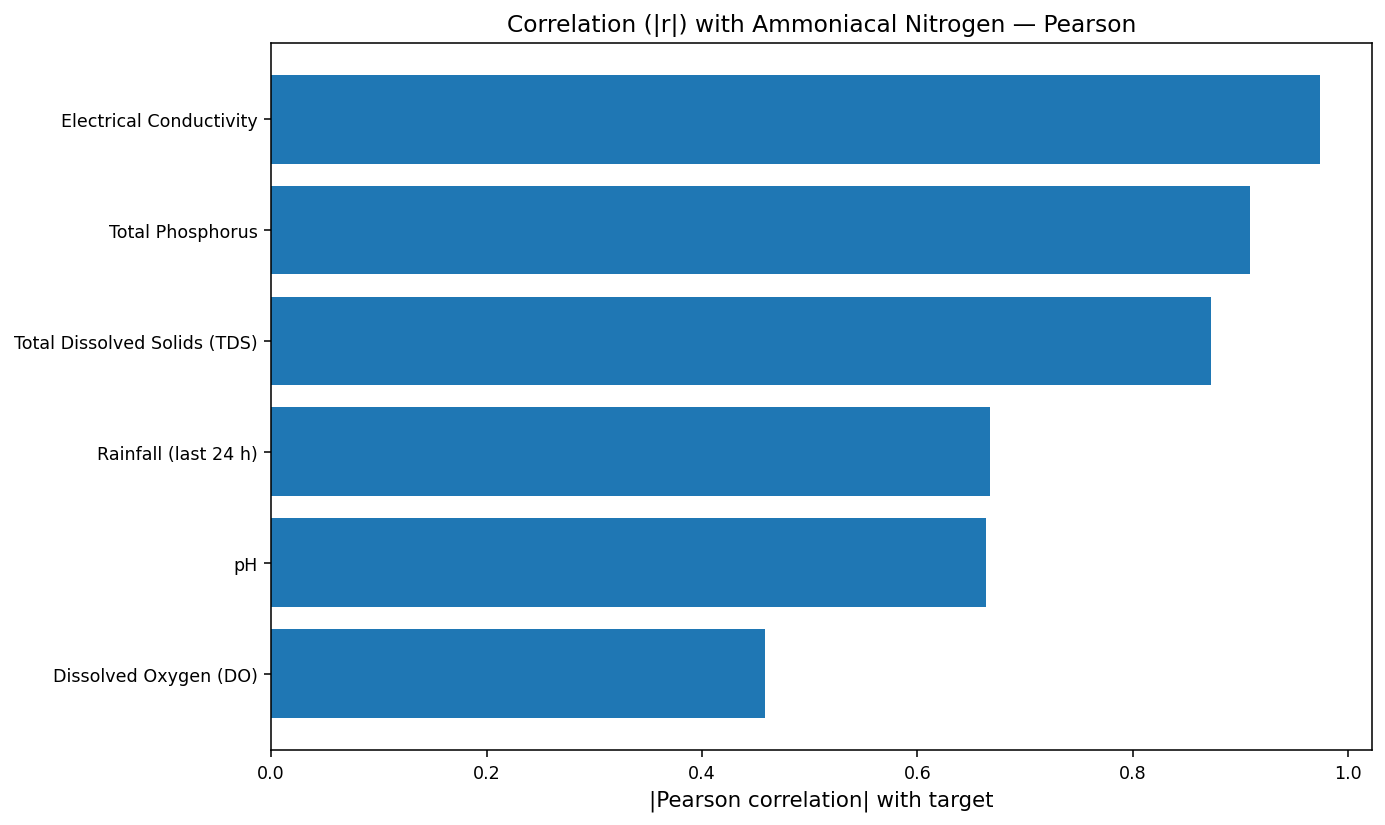

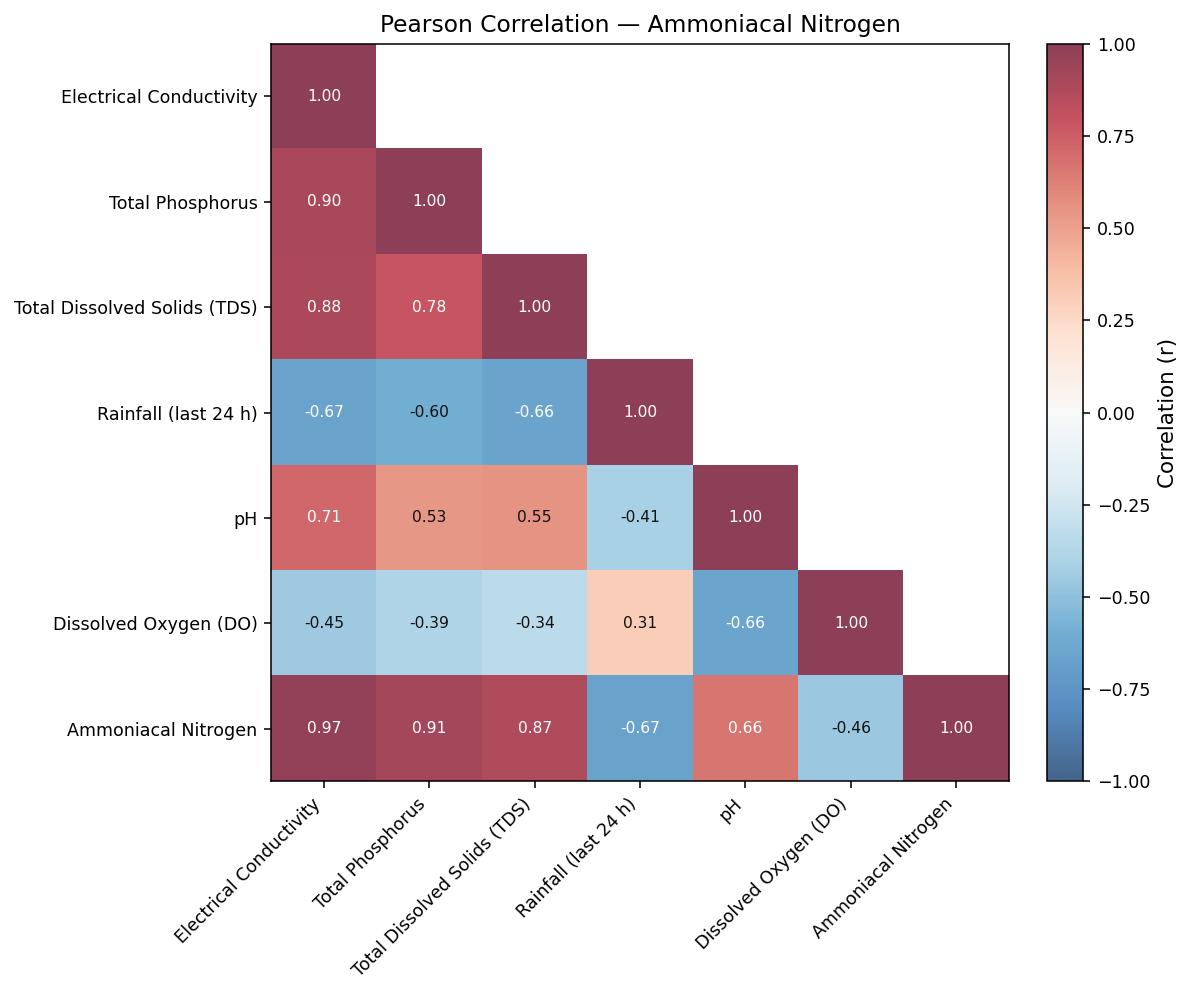

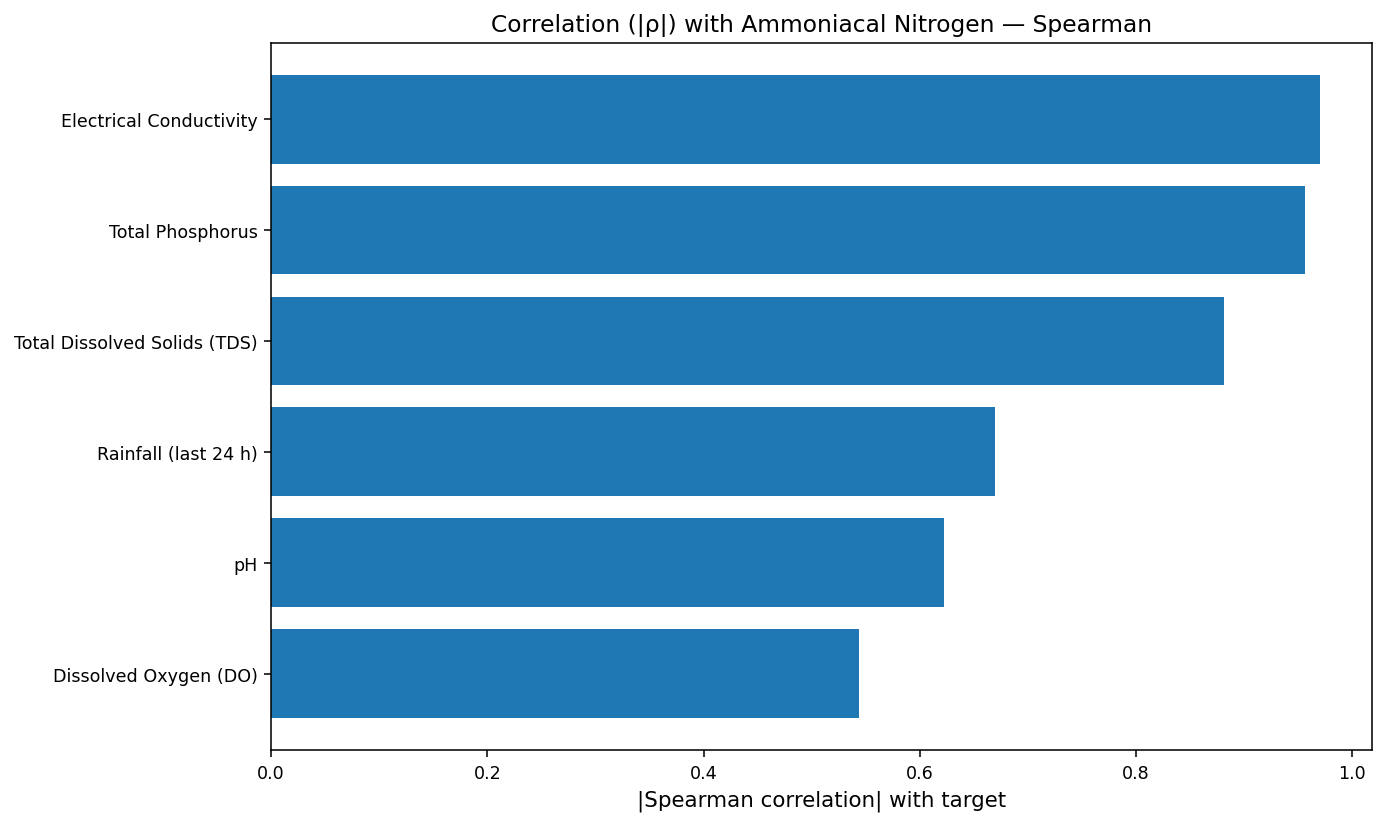

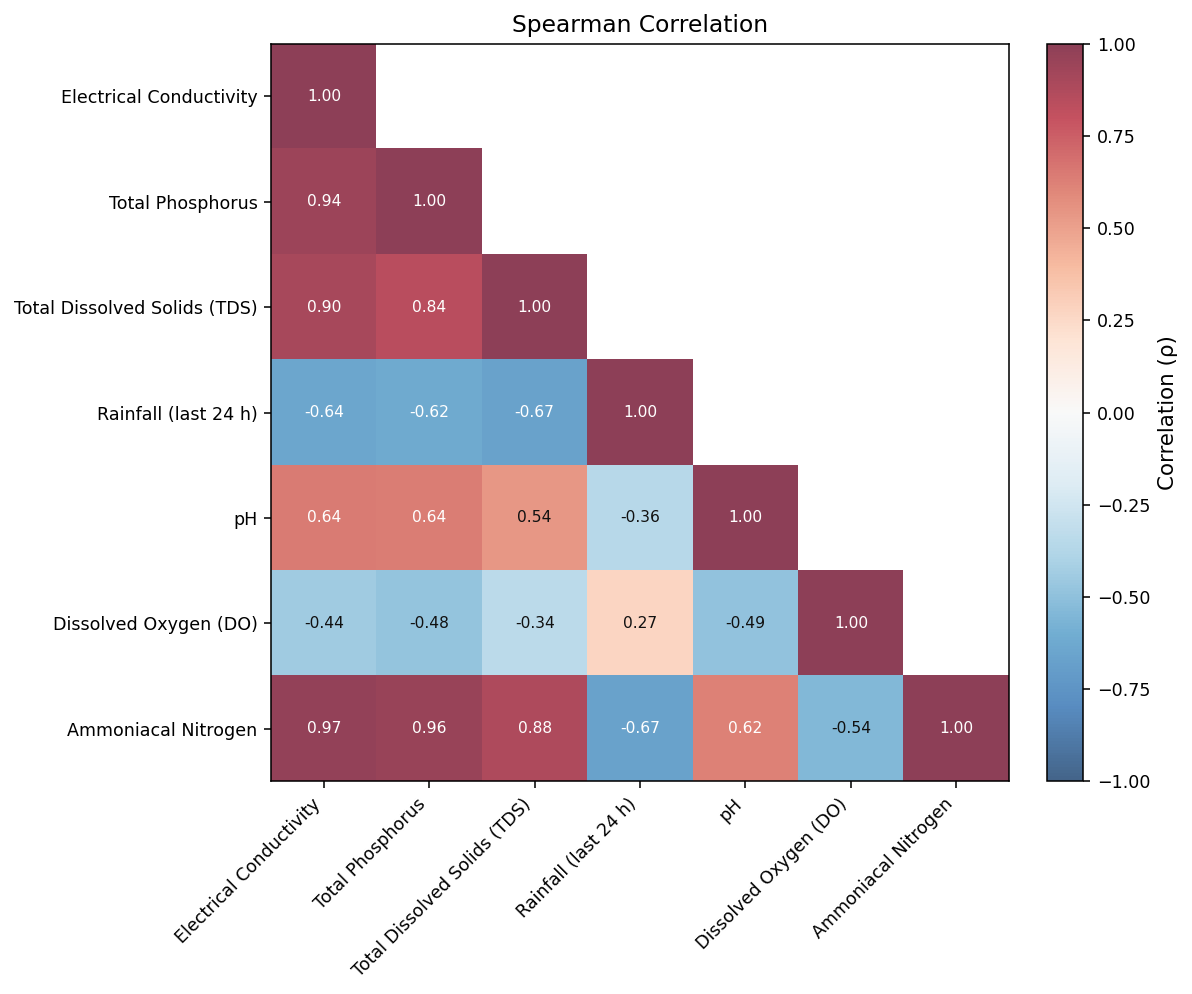


=== TIME SERIES SPLITS (DATES) ===
Total modeling window: 2019-01-09 to 2025-05-06
Total samples used (after non-null target): 28

Fold 1:
  Train: 2019-01-09 -> 2020-02-12  (n=8)
  Test : 2020-10-13  -> 2021-06-28   (n=4)

Fold 2:
  Train: 2019-01-09 -> 2021-06-28  (n=12)
  Test : 2021-09-22  -> 2022-05-12   (n=4)

Fold 3:
  Train: 2019-01-09 -> 2022-05-12  (n=16)
  Test : 2022-08-24  -> 2023-05-17   (n=4)

Fold 4:
  Train: 2019-01-09 -> 2023-05-17  (n=20)
  Test : 2023-08-17  -> 2024-05-02   (n=4)

Fold 5:
  Train: 2019-01-09 -> 2024-05-02  (n=24)
  Test : 2024-08-07  -> 2025-05-06   (n=4)



C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\3122276511.py:585: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\3122276511.py:585: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_13400\3122276511.py:585: FutureWarning: The behavior of array concatenation with


=== METRICS (mean ± std; and OOF) ===
  Model Selector_corr  R2_mean  R2_std    R2_OOF  RMSE_mean  RMSE_std  \
1    RF      spearman      NaN     NaN  0.843174        NaN       NaN   
2   XGB      spearman      NaN     NaN  0.807873        NaN       NaN   
0   MLP      spearman      NaN     NaN  0.774721        NaN       NaN   

   RMSE_OOF  MAE_mean  MAE_std  ...  MAPE_OOF(%)  R_mean(Pearson)  \
1  2.769846       NaN      NaN  ...    12.665261              NaN   
2  3.065785       NaN      NaN  ...    15.893500              NaN   
0  3.319768       NaN      NaN  ...    25.659471              NaN   

   R_std(Pearson)  R_OOF(Pearson)  R_mean(Spearman)  R_std(Spearman)  \
1             NaN        0.946775               NaN              NaN   
2             NaN        0.951184               NaN              NaN   
0             NaN        0.884699               NaN              NaN   

   R_OOF(Spearman)  CCC_mean  CCC_std   CCC_OOF  
1         0.950376       NaN      NaN  0.910410  
2 

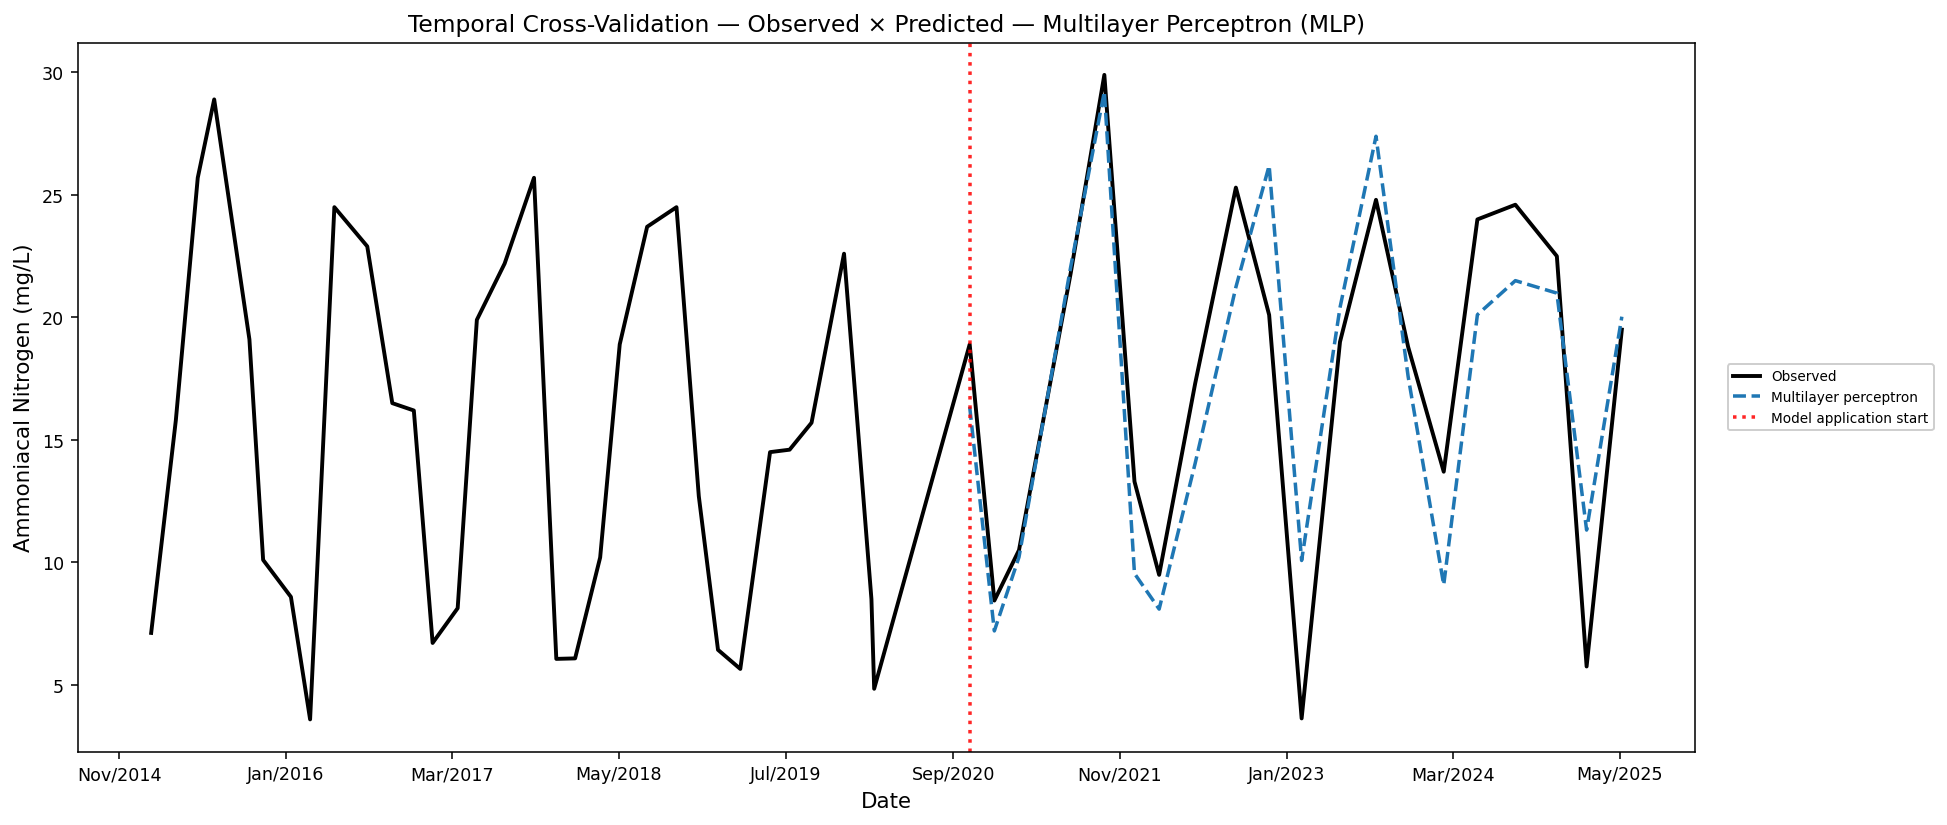

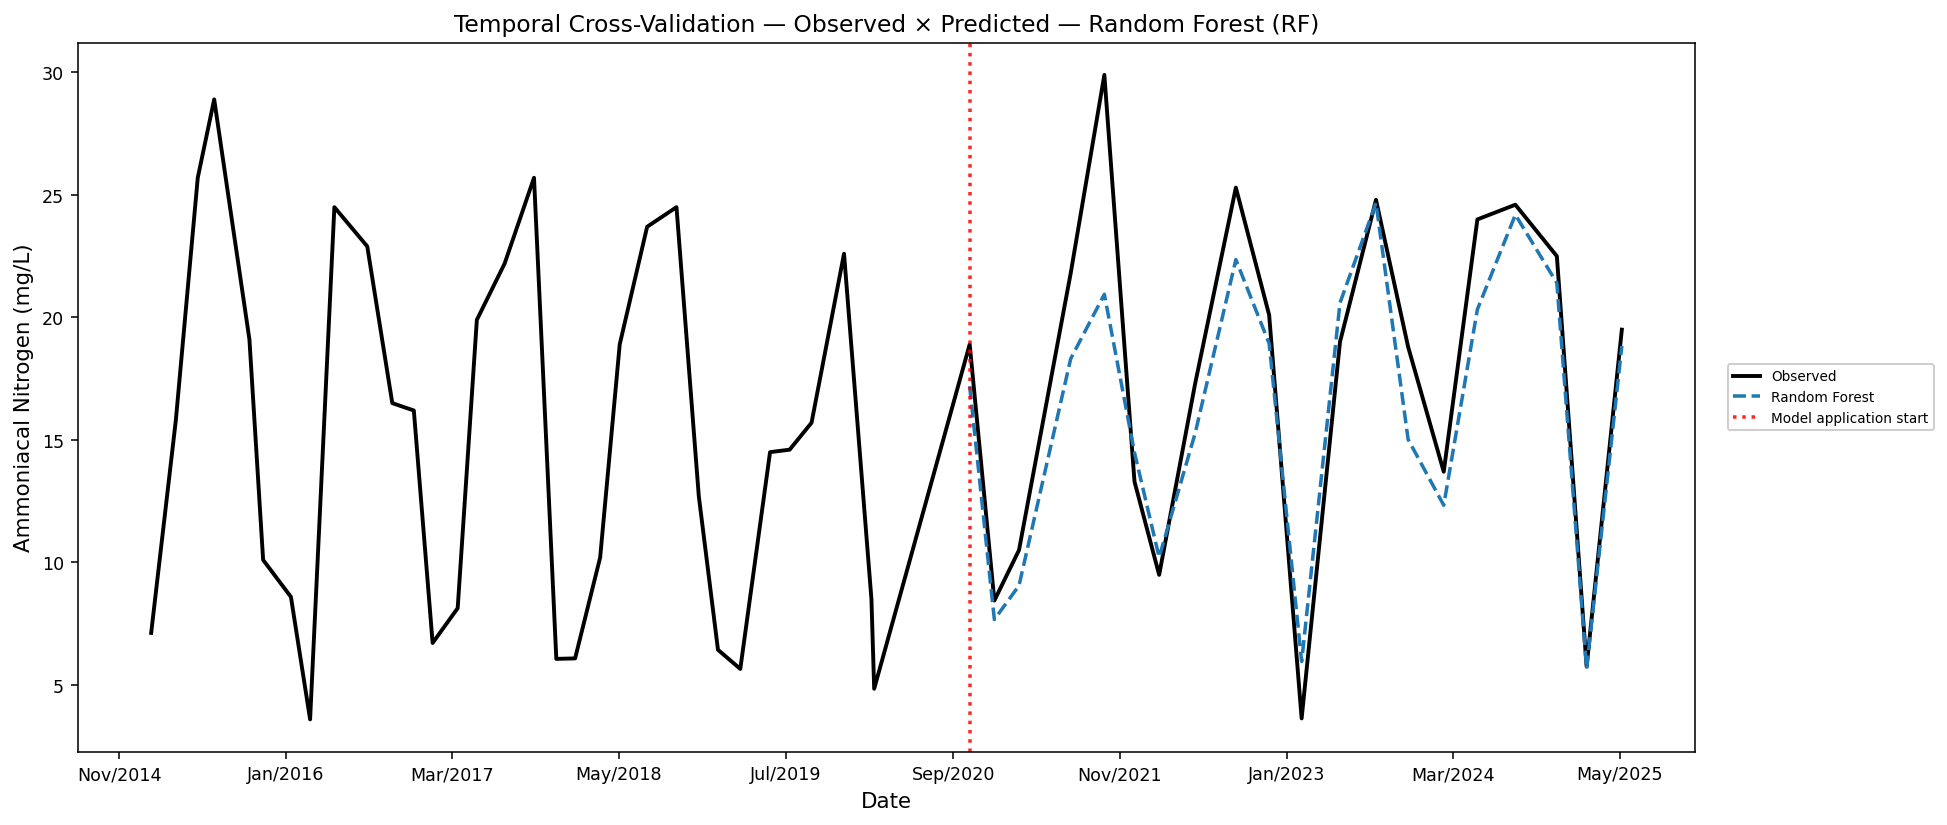

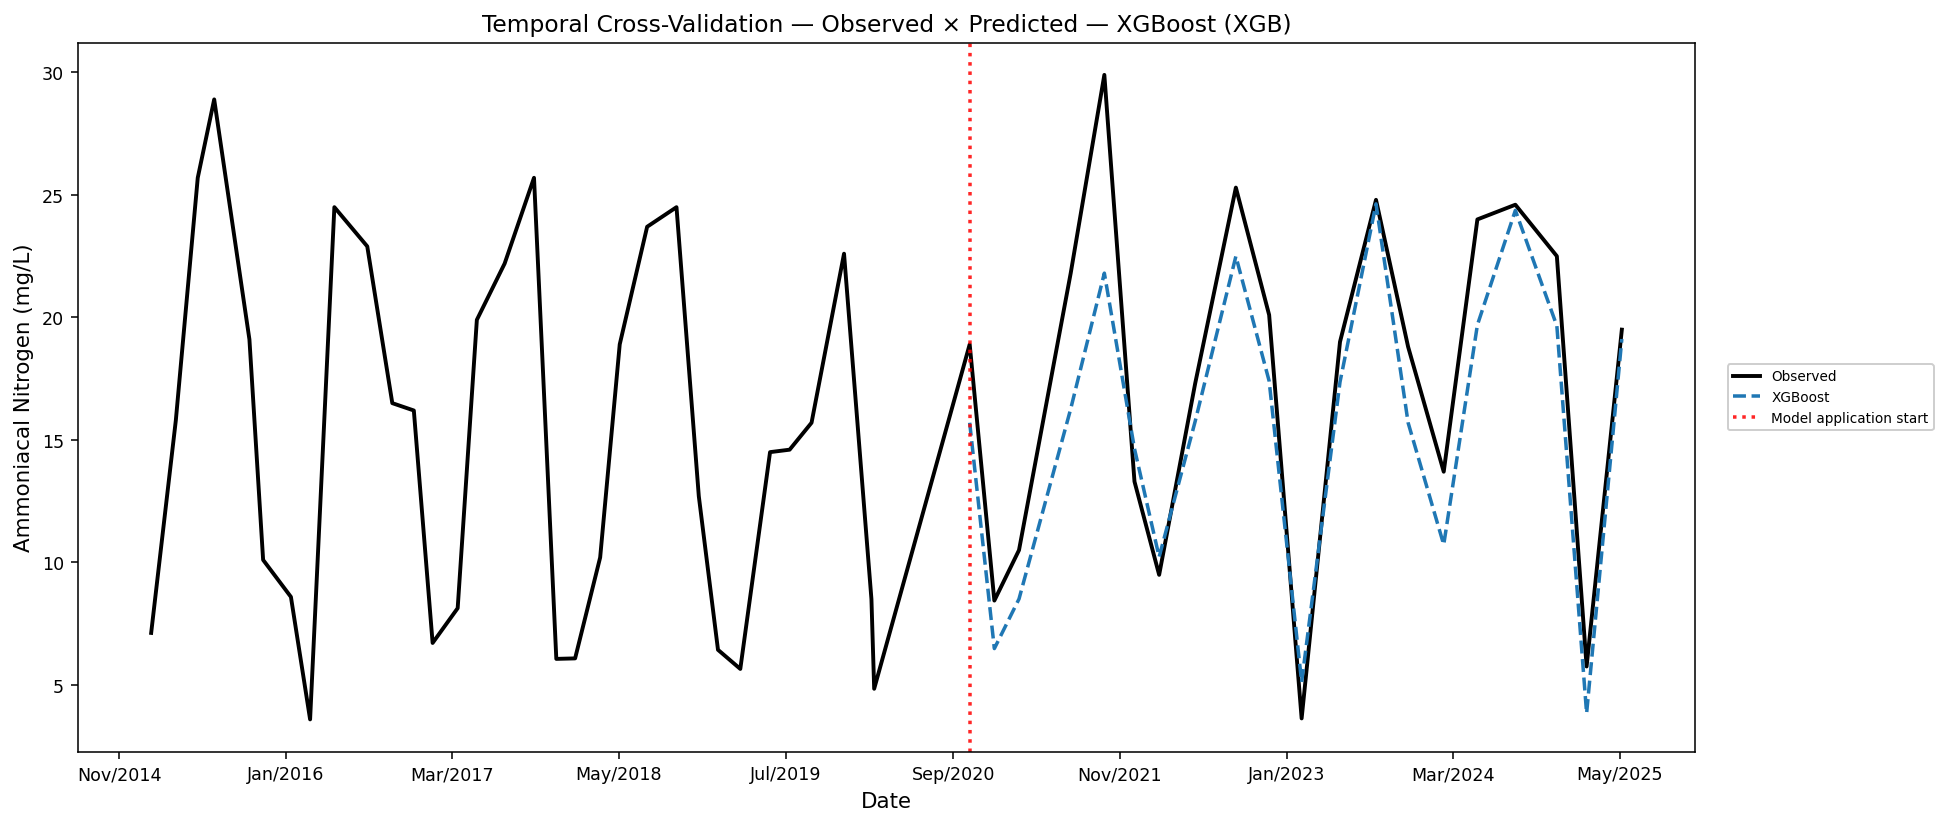

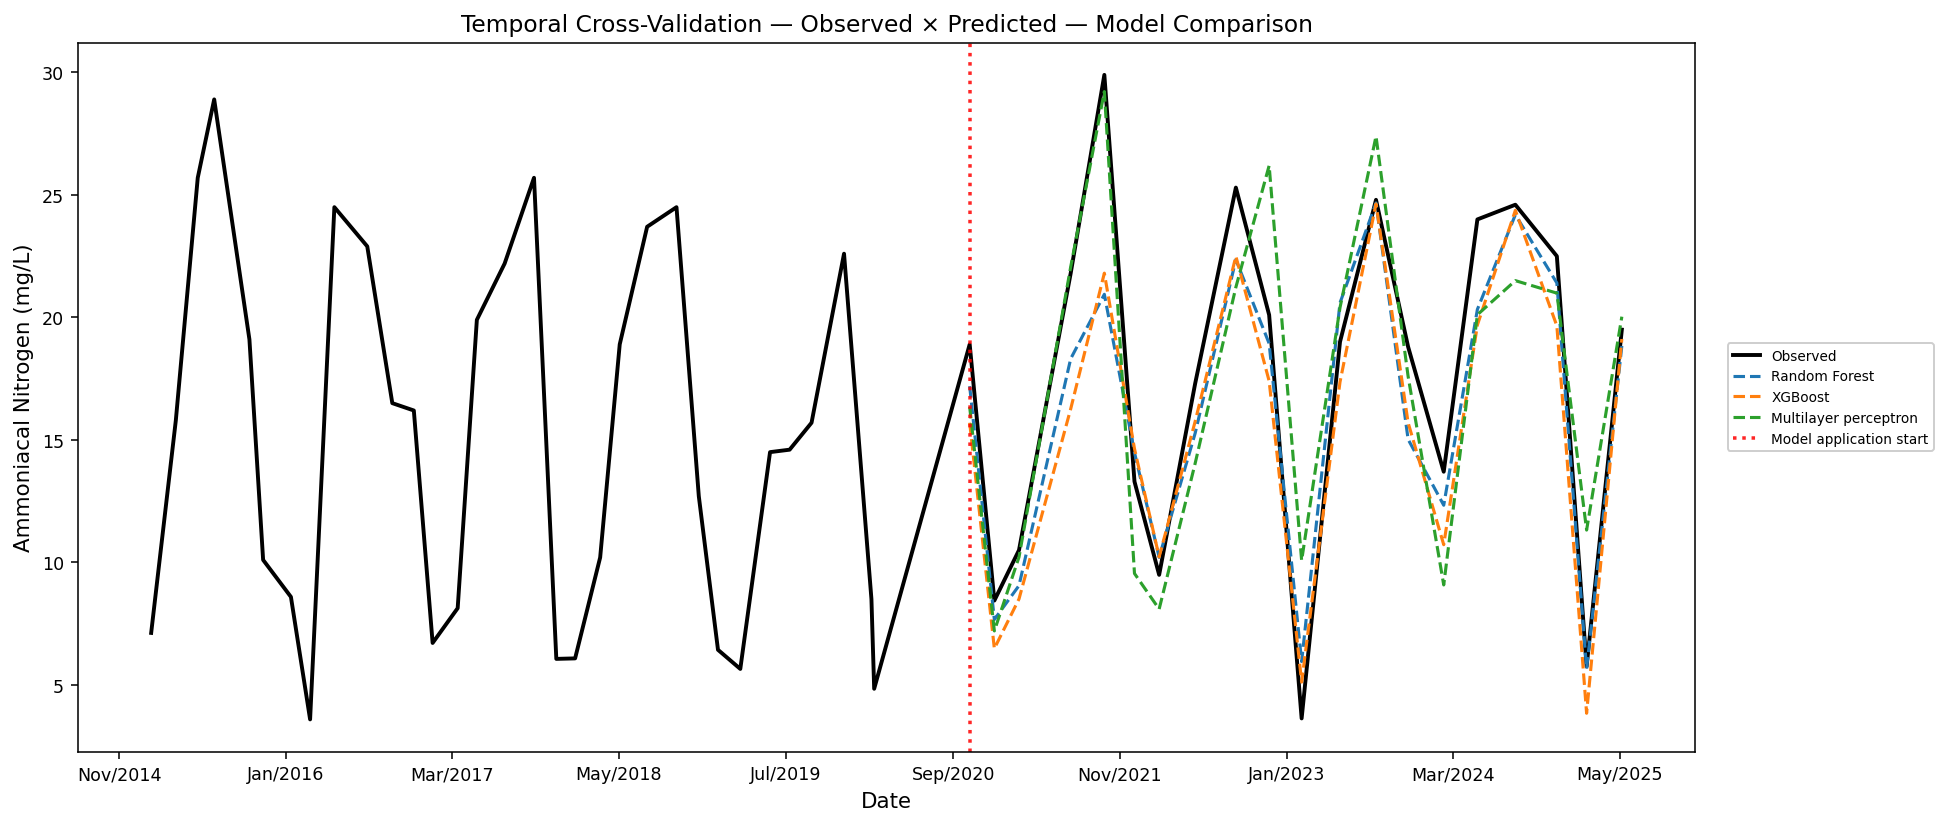

[INFO] Dynamic backtesting — Window 1: train up to 2021-09-21 and predict from 2021-09-22 to 2025-05-06


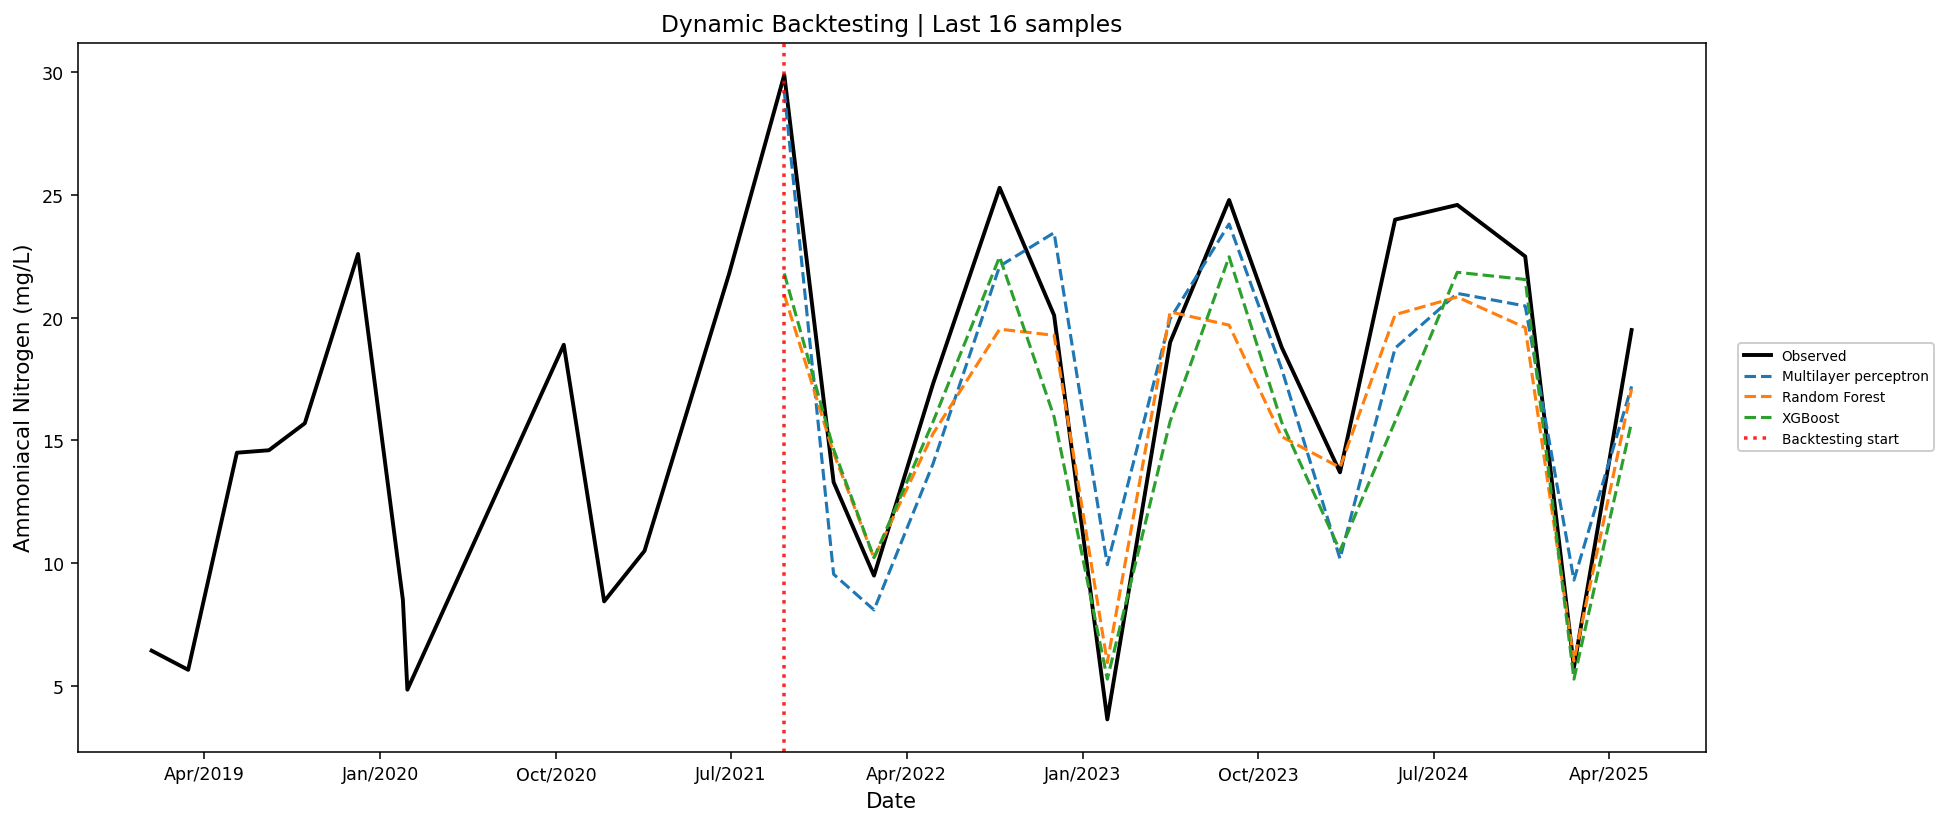

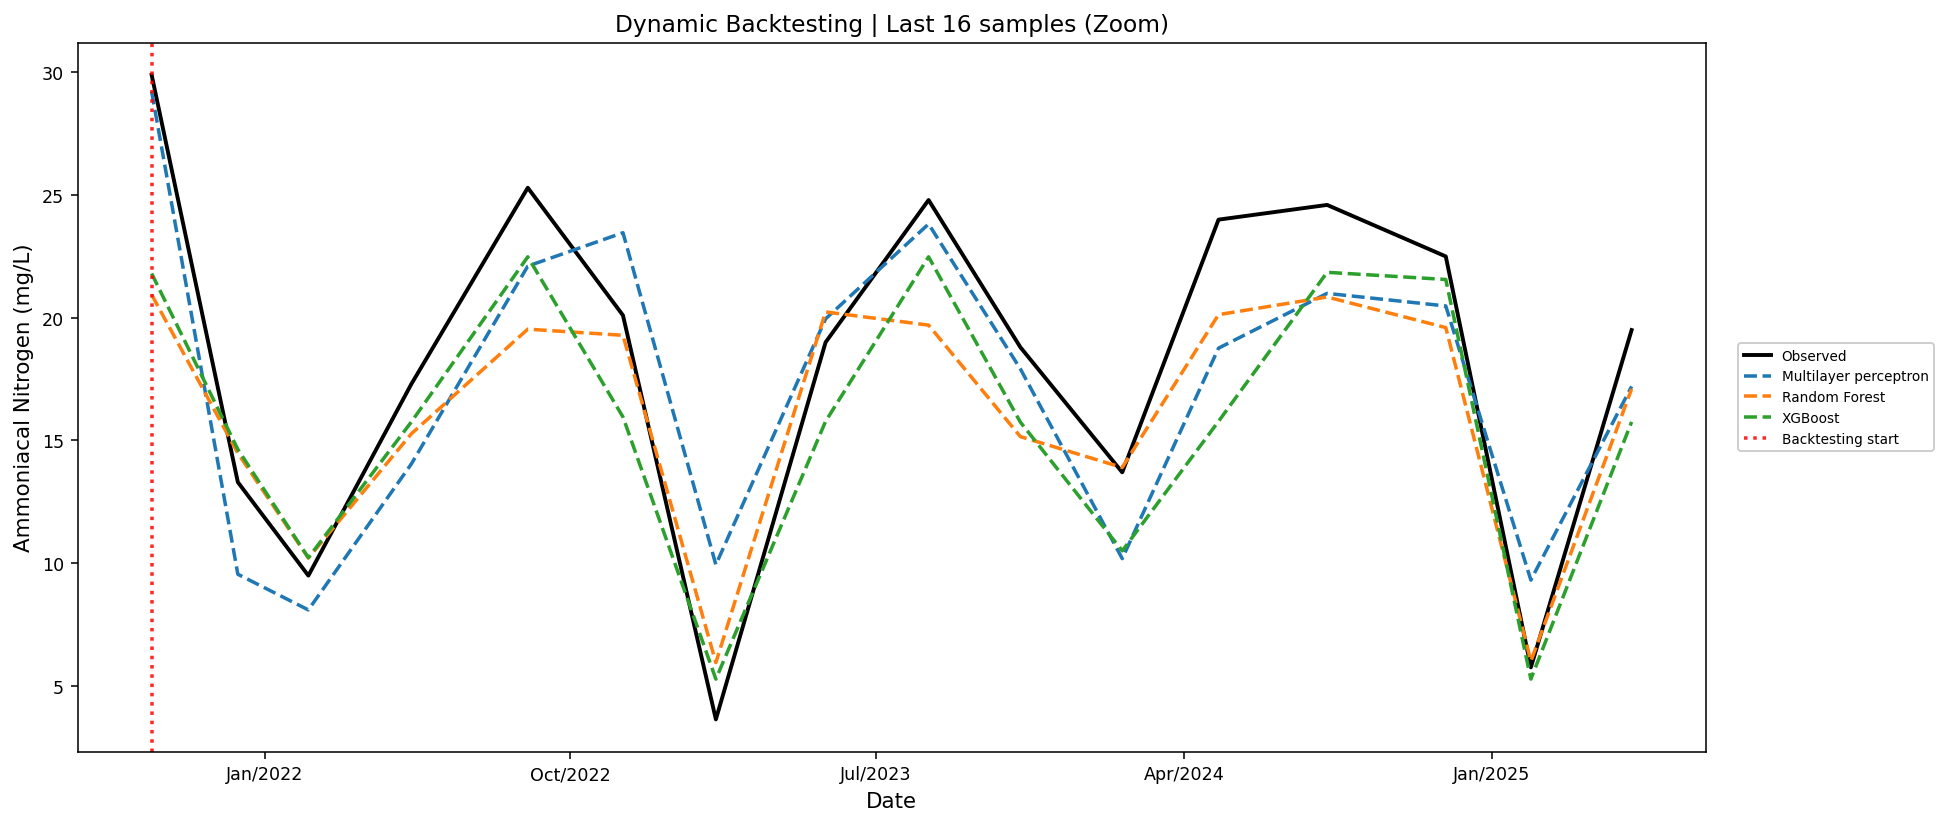


=== BACKTESTING METRICS (dynamic — last points) ===
   Window       Start         End Model        R2         R   R_spear  \
0       1  2021-09-22  2025-05-06   MLP  0.797310  0.905926  0.920588   
1       1  2021-09-22  2025-05-06    RF  0.743830  0.950085  0.888235   
2       1  2021-09-22  2025-05-06   XGB  0.726849  0.940975  0.959529   

        CCC      RMSE       MAE       MAPE        MSE  
0  0.885376  3.219989  2.813142  26.599202  10.368330  
1  0.837011  3.619947  2.821120  16.105514  13.104017  
2  0.844216  3.738004  3.014138  17.107568  13.972671  


In [15]:
# -*- coding: utf-8 -*-
"""
TCC/Thesis – Ammoniacal Nitrogen Prediction (TIET04200)
RF / XGB (optional) / MLP + leakage-free temporal pipeline
Pearson + Spearman + Dynamic backtesting (last N points)

All labels (titles, axes, legends) are in ENGLISH.
Parameter names coming from Excel remain in PT (as in your sheet), but are DISPLAYED in English via label_param().

LATEST ADJUSTMENTS (requested):
1) Legend text:
   - "Observed (Ammoniacal Nitrogen)" -> "Observed"
   - "Predicted — MLP" -> "Multilayer perceptron"
   - "Predicted — RF"  -> "Random Forest"
   - "Predicted — XGB" -> "XGBoost"
2) Backtesting plots: VISUAL context since 2019 (training unchanged).
3) Keep: no gridlines; red marker visible; legend smaller and always on the right.
"""

import os, warnings, re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# =========================
# XGBoost (optional)
# =========================
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    warnings.warn("xgboost not found. The XGB model will be skipped.")

# =========================
# PARAMETERS
# =========================
FILE_PATH   = r"C:\Users\Gustavo\Desktop\DataScience\projeto_modelopreditivos\TIET04200_completo.xlsx"
SHEET_NAME  = "Planilha1"

TARGET_PARAM_PT = "Nitrogênio Amoniacal"          # as in Excel
TARGET_LABEL_EN = "Ammoniacal Nitrogen"           # display label

# Modeling starts here (UNCHANGED)
MIN_YEAR = 2019

# ---- PLOTTING ONLY
PLOT_SERIES_START_DATE = "2015-01-01"   # OOF plots: observed context only
BACKTEST_VIS_START_DATE = "2019-01-01"  # Backtesting plots: observed context only
PLOT_START_DATE = "2019-01-01"          # residuals/monthly error etc.

N_SPLITS = 5
TOP_K = 5
USE_SEASON_DUMMIES = True

# Feature selector correlation method: 'pearson' or 'spearman'
CORR_SELECTOR_METHOD = "spearman"

# Dynamic backtesting
BACKTEST_POINTS = 16

OUTPUT_DIR = "tcc_results"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# Full names (titles)
MODEL_NAME_MAP = {
    "MLP": "Multilayer Perceptron (MLP)",
    "RF":  "Random Forest (RF)",
}
if HAS_XGB:
    MODEL_NAME_MAP["XGB"] = "XGBoost (XGB)"

# Legend names (requested)
LEGEND_MODEL_MAP = {
    "MLP": "Multilayer perceptron",
    "RF":  "Random Forest",
    "XGB": "XGBoost"
}

# =========================
# PARAMETER TRANSLATION (PT -> EN) FOR PLOTS
# =========================
def _normalize_key(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.strip()
    s = s.replace("–", "-").replace("—", "-").replace("−", "-")
    s = re.sub(r"\s+", " ", s)
    s_nfkd = unicodedata.normalize("NFKD", s)
    s_noacc = "".join(ch for ch in s_nfkd if not unicodedata.combining(ch))
    return s_noacc.lower().strip()

_NORM_TRANSLATIONS = {
    _normalize_key("Chuvas nas últimas 24h"): "Rainfall (last 24 h)",
    _normalize_key("Condutividade"): "Electrical Conductivity",
    _normalize_key("OD"): "Dissolved Oxygen (DO)",
    _normalize_key("pH"): "pH",
    _normalize_key("Fósforo Total"): "Total Phosphorus",
    _normalize_key("Nitrogênio Amoniacal"): "Ammoniacal Nitrogen",
    _normalize_key("Sólido Dissolvido Total"): "Total Dissolved Solids (TDS)",
}

def label_param(name: str) -> str:
    raw = "" if name is None else str(name)
    k = _normalize_key(raw)

    if k in _NORM_TRANSLATIONS:
        return _NORM_TRANSLATIONS[k]

    # Fallbacks
    if ("chuva" in k or "chuvas" in k) and ("24" in k):
        return "Rainfall (last 24 h)"
    if ("solido" in k or "solidos" in k) and ("dissolv" in k):
        return "Total Dissolved Solids (TDS)"
    if k in {"od", "do"}:
        return "Dissolved Oxygen (DO)"

    return raw

# =========================
# FIGURE STYLE (NO GRIDLINES)
# =========================
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "axes.grid": False,      # remove grid
    "grid.alpha": 0.0,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.frameon": True,
    "legend.framealpha": 0.95,
    "legend.facecolor": "white",
})

# Legend font smaller
LEGEND_FONTSIZE = 7

# =========================
# Date axis in EN (Month/Year)
# =========================
EN_MONTHS = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def format_time_axis_en(ax, month_interval=3, auto=True, max_ticks=8):
    if auto:
        xmin, xmax = ax.get_xlim()
        dmin = mdates.num2date(xmin)
        dmax = mdates.num2date(xmax)
        months = max(1, (dmax.year - dmin.year) * 12 + (dmax.month - dmin.month) + 1)
        interval = max(1, int(np.ceil(months / max_ticks)))
    else:
        interval = month_interval

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))

    def _fmt(x, pos=None):
        d = mdates.num2date(x)
        return f"{EN_MONTHS[d.month-1]}/{d.year}"

    ax.xaxis.set_major_formatter(FuncFormatter(_fmt))

# =========================
# RED VERTICAL MARKER (visible)
# =========================
def add_red_marker(ax, x, label="Model application start"):
    if x is None:
        return
    x = pd.to_datetime(x)
    ax.axvline(
        x,
        color="red",
        linewidth=1.8,
        alpha=0.85,
        linestyle=":",
        label=label
    )

# =========================
# Legend always to the right
# =========================
def legend_right(ax, ncol=1):
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        ncol=ncol,
        fontsize=LEGEND_FONTSIZE
    )

# =========================
# HELPERS
# =========================
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def pearson_r(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size < 2:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def spearman_rho(a, b):
    """Spearman without scipy: Pearson over ranks."""
    a = pd.Series(np.asarray(a, dtype=float))
    b = pd.Series(np.asarray(b, dtype=float))
    if a.size < 2:
        return np.nan
    ra = a.rank(method="average")
    rb = b.rank(method="average")
    return float(np.corrcoef(ra, rb)[0, 1])

def ccc_lin(y_true, y_pred):
    """Concordance Correlation Coefficient (Lin, 1989)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.size < 2:
        return np.nan
    mu_x, mu_y = np.mean(y_true), np.mean(y_pred)
    var_x, var_y = np.var(y_true, ddof=1), np.var(y_pred, ddof=1)
    r = pearson_r(y_true, y_pred)
    denom = var_x + var_y + (mu_x - mu_y) ** 2
    if denom == 0:
        return np.nan
    return float((2 * r * np.sqrt(var_x) * np.sqrt(var_y)) / denom)

def forward_fill_train_test(X_train, X_test):
    X_train = X_train.sort_index()
    X_test = X_test.sort_index()

    X_train_ff = X_train.ffill()
    med = X_train_ff.median(numeric_only=True)
    X_train_ff = X_train_ff.fillna(med)

    if len(X_train_ff) > 0:
        seed = X_train_ff.tail(1)
        X_test_ff = pd.concat([seed, X_test]).ffill().iloc[1:]
    else:
        X_test_ff = X_test.copy()

    X_test_ff = X_test_ff.fillna(med)

    na_cols = list(set(
        X_train_ff.columns[X_train_ff.isna().any()].tolist() +
        X_test_ff.columns[X_test_ff.isna().any()].tolist()
    ))
    if na_cols:
        X_train_ff = X_train_ff.drop(columns=na_cols, errors="ignore")
        X_test_ff  = X_test_ff.drop(columns=na_cols, errors="ignore")

    return X_train_ff, X_test_ff

class RobustClipper(BaseEstimator, TransformerMixin):
    """Column-wise clipping at mean ± lim_std * std (fit on train only)."""
    def __init__(self, lim_std=3.0): self.lim_std = lim_std
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("RobustClipper requires a DataFrame.")
        self.means_ = X.mean()
        stds = X.std().replace(0, 1e-9)
        self.lower_ = self.means_ - self.lim_std * stds
        self.upper_ = self.means_ + self.lim_std * stds
        return self
    def transform(self, X):
        return X.clip(self.lower_, self.upper_, axis=1)

class CorrKSelector(BaseEstimator, TransformerMixin):
    """Select TOP_K base features by |corr| with target (train only). Keeps dummies."""
    def __init__(self, base_cols, dummy_cols, k=5, method="pearson"):
        self.base_cols = base_cols
        self.dummy_cols = dummy_cols
        self.k = k
        self.method = method

    def fit(self, X, y):
        Xb = X[[c for c in self.base_cols if c in X.columns]].copy()
        y_arr = np.asarray(y, dtype=float)
        y_series = pd.Series(y_arr)

        corrs = {}
        for c in Xb.columns:
            x = pd.Series(np.asarray(Xb[c], dtype=float))
            if x.std(ddof=0) < 1e-12:
                corrs[c] = 0.0
            else:
                corrs[c] = spearman_rho(x, y_series) if self.method == "spearman" else pearson_r(x, y_series)

        s = pd.Series(corrs).abs().sort_values(ascending=False)
        self.selected_base_ = s.head(self.k).index.tolist()

        kept_dummies = [c for c in self.dummy_cols if c in X.columns]
        self.out_cols_ = self.selected_base_ + kept_dummies
        return self

    def transform(self, X):
        cols = [c for c in self.out_cols_ if c in X.columns]
        return X[cols]

def build_wide_dataset(filepath, sheet_name, target_param_pt, min_year=2019, use_dummies=True):
    """
    Expected Excel columns (PT):
      - Data (date)
      - Parametro (parameter name)
      - Valor (value)
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    df["Data"] = pd.to_datetime(df["Data"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Data", "Parametro", "Valor"])
    df["Valor"] = df["Valor"].astype(str).str.replace(",", ".", regex=False).astype(float)
    df = df[df["Data"].dt.year >= min_year]

    wide = df.pivot_table(index="Data", columns="Parametro", values="Valor", aggfunc="mean").sort_index()

    if use_dummies:
        wide["Month"] = wide.index.month
        wide["Season"] = wide.index.month % 12 // 3 + 1
        wide = pd.get_dummies(wide, columns=["Month", "Season"], drop_first=True)

    if target_param_pt not in wide.columns:
        raise ValueError(f"Target parameter '{target_param_pt}' not found after pivot.")

    wide = wide.dropna(subset=[target_param_pt])
    y = wide[target_param_pt].copy()
    X = wide.drop(columns=[target_param_pt]).copy()

    dummy_cols = [c for c in X.columns if c.startswith("Month_") or c.startswith("Season_")]
    base_cols = [c for c in X.columns if c not in dummy_cols]

    return X, y, base_cols, dummy_cols

def evaluate_model(y_true, y_pred):
    y_true = pd.Series(y_true).astype(float)
    y_pred = pd.Series(y_pred).astype(float)

    common = y_true.index.intersection(y_pred.index)
    y_true = y_true.loc[common]
    y_pred = y_pred.loc[common]

    m = y_true.notna() & y_pred.notna()
    y_true = y_true[m].to_numpy()
    y_pred = y_pred[m].to_numpy()

    if y_true.size == 0:
        return dict(MSE=np.nan, RMSE=np.nan, MAE=np.nan, R2=np.nan, MAPE=np.nan,
                    R=np.nan, R_spear=np.nan, CCC=np.nan)

    mse = mean_squared_error(y_true, y_pred)
    return dict(
        MSE=mse,
        RMSE=np.sqrt(mse),
        MAE=mean_absolute_error(y_true, y_pred),
        R2=r2_score(y_true, y_pred),
        MAPE=mape_safe(y_true, y_pred),
        R=pearson_r(y_true, y_pred),
        R_spear=spearman_rho(y_true, y_pred),
        CCC=ccc_lin(y_true, y_pred)
    )

# =========================
# DATA PREP (MODEL DATA) — unchanged
# =========================
X_all, y_all, base_cols_all, dummy_cols_all = build_wide_dataset(
    FILE_PATH, SHEET_NAME, TARGET_PARAM_PT, min_year=MIN_YEAR, use_dummies=USE_SEASON_DUMMIES
)

# =========================
# OBSERVED SERIES FOR CONTEXT PLOTS
# (build without dummies; this does NOT change training)
# =========================
_, y_obs_2015, _, _ = build_wide_dataset(
    FILE_PATH, SHEET_NAME, TARGET_PARAM_PT, min_year=2015, use_dummies=False
)
y_obs_2015 = y_obs_2015.sort_index()

plot_cut_full = pd.to_datetime(PLOT_SERIES_START_DATE)
plot_cut = pd.to_datetime(PLOT_START_DATE)
bt_vis_cut = pd.to_datetime(BACKTEST_VIS_START_DATE)

data_min = pd.to_datetime(y_all.index.min()).date() if len(y_all) else None
data_max = pd.to_datetime(y_all.index.max()).date() if len(y_all) else None
print(f"[INFO] Data (MODEL, after MIN_YEAR={MIN_YEAR} and non-null target): {data_min} to {data_max}")
print(f"[INFO] OOF series plots (Observed context): from {pd.to_datetime(PLOT_SERIES_START_DATE).date()} (visual only)")
print(f"[INFO] Backtesting plots (Observed context): from {pd.to_datetime(BACKTEST_VIS_START_DATE).date()} (visual only; training unchanged)")
print(f"[INFO] Other plots (residuals/monthly error): from {pd.to_datetime(PLOT_START_DATE).date()}")

# =========================
# CORRELATIONS (Pearson & Spearman)
# =========================
from matplotlib.colors import ListedColormap
import numpy.ma as ma

def pastelize_cmap(base_cmap="RdBu_r", mix_with=(1,1,1), factor=0.25):
    cmap = plt.get_cmap(base_cmap, 256)
    colors = cmap(np.linspace(0,1,256))
    mix = np.array(list(mix_with) + [1.0])
    colors = (1-factor)*colors + factor*mix
    return ListedColormap(colors)

PASTEL_CMAP = pastelize_cmap("RdBu_r", factor=0.25)

def triangular_corr_plot(df_vars, target_col, method="pearson", top_m=8,
                         title="Correlation", fname="tri_corr.png"):
    corr_full = df_vars.corr(numeric_only=True, method=method)
    if target_col not in corr_full.columns:
        raise ValueError(f"Target '{target_col}' not present in correlation base.")

    abs_corr = corr_full[target_col].drop(index=target_col).abs().sort_values(ascending=False)
    sel = list(abs_corr.head(top_m).index)

    cols_order = sel + [target_col]
    C = df_vars[cols_order].corr(numeric_only=True, method=method).values

    mask = np.triu(np.ones_like(C, dtype=bool), k=1)
    C_masked = ma.array(C, mask=mask)

    disp_labels = [label_param(c) for c in cols_order[:-1]] + [TARGET_LABEL_EN]

    fig, ax = plt.subplots(figsize=(8.8, 7.2))
    im = ax.imshow(C_masked, cmap=PASTEL_CMAP, vmin=-1, vmax=1)

    ax.set_xticks(range(len(cols_order)))
    ax.set_yticks(range(len(cols_order)))
    ax.set_xticklabels(disp_labels, rotation=45, ha="right")
    ax.set_yticklabels(disp_labels)
    ax.set_title(title)
    ax.grid(False)

    n = len(cols_order)
    for i in range(n):
        for j in range(n):
            if j > i:
                continue
            val = C[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8,
                    color="#111" if abs(val) < 0.6 else "white")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation" + (" (r)" if method == "pearson" else " (ρ)"))

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, fname.replace(".png", ".svg")), bbox_inches="tight")
    plt.show()

df_corr_base = pd.concat([X_all[base_cols_all], y_all.rename(TARGET_PARAM_PT)], axis=1).dropna()
top_k_corr = 6

pearson_series = df_corr_base.corr(numeric_only=True, method="pearson")[TARGET_PARAM_PT].drop(TARGET_PARAM_PT)
pearson_abs = pearson_series.abs().sort_values(ascending=False)
top_names_p = pearson_abs.head(top_k_corr).index
top_vals_p = pearson_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed([label_param(n) for n in top_names_p])), list(reversed(top_vals_p)))
ax.set_xlabel("|Pearson correlation| with target")
ax.set_title(f"Correlation (|r|) with {TARGET_LABEL_EN} — Pearson")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "01_pearson_top6_bar.png"), bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "01_pearson_top6_bar.svg"), bbox_inches="tight")
plt.show()

triangular_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM_PT,
    method="pearson",
    top_m=8,
    title=f"Pearson Correlation — {TARGET_LABEL_EN}",
    fname="02_pearson_triangle_pastel.png"
)

spearman_series = df_corr_base.corr(numeric_only=True, method="spearman")[TARGET_PARAM_PT].drop(TARGET_PARAM_PT)
spearman_abs = spearman_series.abs().sort_values(ascending=False)
top_names_s = spearman_abs.head(top_k_corr).index
top_vals_s = spearman_abs.head(top_k_corr).values

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(list(reversed([label_param(n) for n in top_names_s])), list(reversed(top_vals_s)))
ax.set_xlabel("|Spearman correlation| with target")
ax.set_title(f"Correlation (|ρ|) with {TARGET_LABEL_EN} — Spearman")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "03_spearman_top6_bar.png"), bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "03_spearman_top6_bar.svg"), bbox_inches="tight")
plt.show()

triangular_corr_plot(
    df_vars=df_corr_base,
    target_col=TARGET_PARAM_PT,
    method="spearman",
    top_m=8,
    title="Spearman Correlation",
    fname="04_spearman_triangle_pastel.png"
)

# =========================
# MODELS
# =========================
models = {
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42),
    "RF": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
}
if HAS_XGB:
    models["XGB"] = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    )

# =========================
# TEMPORAL CV (OOF)
# =========================
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
metrics_by_model = {name: [] for name in models}
oof_preds_by_model = {name: pd.Series(dtype=float) for name in models}
oof_truth = pd.Series(dtype=float)

print("\n=== TIME SERIES SPLITS (DATES) ===")
print(f"Total modeling window: {X_all.index.min().date()} to {X_all.index.max().date()}")
print(f"Total samples used (after non-null target): {len(X_all)}\n")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all), start=1):
    train_dates = X_all.index[train_idx]
    test_dates  = X_all.index[test_idx]
    print(f"Fold {fold}:")
    print(f"  Train: {train_dates.min().date()} -> {train_dates.max().date()}  (n={len(train_dates)})")
    print(f"  Test : {test_dates.min().date()}  -> {test_dates.max().date()}   (n={len(test_dates)})\n")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_all), start=1):
    X_train_raw = X_all.iloc[train_idx].copy()
    X_test_raw  = X_all.iloc[test_idx].copy()
    y_train = y_all.iloc[train_idx].copy()
    y_test  = y_all.iloc[test_idx].copy()

    if y_test.isna().any():
        y_test = y_test.dropna()
        X_test_raw = X_test_raw.loc[y_test.index]
    if len(y_test) < 2:
        continue

    X_train_filled, X_test_filled = forward_fill_train_test(X_train_raw, X_test_raw)

    clipper = RobustClipper(lim_std=3.0).fit(X_train_filled)
    X_train_clip = clipper.transform(X_train_filled)
    X_test_clip  = clipper.transform(X_test_filled)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_train_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_train_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_train_clip, y_train)

    X_train_sel = selector.transform(X_train_clip)
    X_test_sel  = selector.transform(X_test_clip)

    scaler = StandardScaler().fit(X_train_sel)
    X_train_scaled = scaler.transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

    for name, model in models.items():
        mdl = clone(model)
        mdl.fit(X_train_scaled, y_train)

        if len(X_test_sel) == 0 or len(y_test) == 0:
            continue

        y_pred = mdl.predict(X_test_scaled)
        fold_metrics = evaluate_model(y_test, y_pred)

        if not np.isnan(fold_metrics["R2"]):
            metrics_by_model[name].append(fold_metrics)

        idx_test = X_test_sel.index
        oof_preds_by_model[name] = pd.concat([oof_preds_by_model[name], pd.Series(y_pred, index=idx_test)])

    oof_truth = pd.concat([oof_truth, pd.Series(y_test.values, index=y_test.index)])

# =========================
# METRIC AGGREGATION
# =========================
rows = []
for name in models.keys():
    lst = metrics_by_model.get(name, [])
    def _avg(k): return np.mean([d[k] for d in lst]) if lst else np.nan
    def _std(k): return np.std([d[k] for d in lst]) if lst else np.nan

    y_pred_oof = oof_preds_by_model[name].sort_index()
    y_true_oof = oof_truth.loc[y_pred_oof.index].sort_index()
    oof_metrics = evaluate_model(y_true_oof, y_pred_oof)

    last_topk = ", ".join(getattr(selector, "selected_base_", [])) if "selector" in locals() else ""

    rows.append({
        "Model": name,
        "R2_mean": _avg("R2"), "R2_std": _std("R2"), "R2_OOF": oof_metrics["R2"],
        "RMSE_mean": _avg("RMSE"), "RMSE_std": _std("RMSE"), "RMSE_OOF": oof_metrics["RMSE"],
        "MAE_mean": _avg("MAE"), "MAE_std": _std("MAE"), "MAE_OOF": oof_metrics["MAE"],
        "MSE_mean": _avg("MSE"), "MSE_std": _std("MSE"), "MSE_OOF": oof_metrics["MSE"],
        "MAPE_mean(%)": _avg("MAPE"), "MAPE_std(%)": _std("MAPE"), "MAPE_OOF(%)": oof_metrics["MAPE"],
        "R_mean(Pearson)": _avg("R"), "R_std(Pearson)": _std("R"), "R_OOF(Pearson)": oof_metrics["R"],
        "R_mean(Spearman)": _avg("R_spear"), "R_std(Spearman)": _std("R_spear"), "R_OOF(Spearman)": oof_metrics["R_spear"],
        "CCC_mean": _avg("CCC"), "CCC_std": _std("CCC"), "CCC_OOF": oof_metrics["CCC"],
        "TopK_features(last_fold)": last_topk,
        "Selector_corr": CORR_SELECTOR_METHOD
    })

df_metrics = pd.DataFrame(rows)
sort_key = "RMSE_mean" if ("RMSE_mean" in df_metrics.columns and not df_metrics["RMSE_mean"].isna().all()) else "RMSE_OOF"
df_metrics = df_metrics.sort_values(by=sort_key)

os.makedirs(OUTPUT_DIR, exist_ok=True)
df_metrics.to_csv(os.path.join(OUTPUT_DIR, "model_metrics.csv"), index=False, sep=";")
try:
    df_fmt = df_metrics.copy()
    for c in df_fmt.columns:
        if c not in ["Model", "TopK_features(last_fold)", "Selector_corr"]:
            df_fmt[c] = pd.to_numeric(df_fmt[c], errors="ignore")
            if pd.api.types.is_float_dtype(df_fmt[c]):
                df_fmt[c] = df_fmt[c].round(4)
    df_fmt.to_excel(os.path.join(OUTPUT_DIR, "model_metrics.xlsx"), index=False)
except Exception:
    pass

print("\n=== METRICS (mean ± std; and OOF) ===")
cols_print = [
    "Model","Selector_corr","R2_mean","R2_std","R2_OOF",
    "RMSE_mean","RMSE_std","RMSE_OOF",
    "MAE_mean","MAE_std","MAE_OOF",
    "MAPE_mean(%)","MAPE_std(%)","MAPE_OOF(%)",
    "R_mean(Pearson)","R_std(Pearson)","R_OOF(Pearson)",
    "R_mean(Spearman)","R_std(Spearman)","R_OOF(Spearman)",
    "CCC_mean","CCC_std","CCC_OOF"
]
print(df_metrics[cols_print])

# =========================
# OOF PLOTS — Observed × Predicted (legend labels updated)
# =========================
def plot_model_series_oof(model_key, pred_series):
    if pred_series.empty:
        return

    dfp = pd.DataFrame({"Predicted": pred_series}).sort_index()
    dfp = dfp[dfp.index >= plot_cut_full]
    if dfp.empty:
        return

    y_plot = y_obs_2015[y_obs_2015.index >= plot_cut_full]
    if y_plot.empty:
        return

    full_name = MODEL_NAME_MAP.get(model_key, model_key)
    title = f"Temporal Cross-Validation — Observed × Predicted — {full_name}"

    pred_start = dfp.index.min()

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(y_plot.index, y_plot.values, label="Observed", linewidth=2, color="black")
    ax.plot(dfp.index, dfp["Predicted"], label=LEGEND_MODEL_MAP.get(model_key, model_key),
            linewidth=1.8, linestyle="--")

    add_red_marker(ax, pred_start, label="Model application start")

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
    format_time_axis_en(ax, auto=True, max_ticks=10)

    legend_right(ax, ncol=1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{model_key}_observed_vs_predicted_OOF.png"), bbox_inches="tight")
    plt.savefig(os.path.join(FIG_DIR, f"{model_key}_observed_vs_predicted_OOF.svg"), bbox_inches="tight")
    plt.show()

for name, preds in oof_preds_by_model.items():
    plot_model_series_oof(name, preds)

# =========================
# OOF — Model Comparison (legend labels updated)
# =========================
preds_dict = {k: v for k, v in oof_preds_by_model.items() if not v.empty}
if preds_dict:
    base = pd.DataFrame({"Observed": y_obs_2015}).sort_index()
    for name in df_metrics["Model"]:
        if name in preds_dict:
            base[name] = preds_dict[name]
    base = base[base.index >= plot_cut_full]

    if not base.empty and base["Observed"].notna().any():
        pred_start_all = min([s.index.min() for s in preds_dict.values() if len(s) > 0])

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(base.index, base["Observed"], label="Observed", linewidth=2, color="black")
        for name in df_metrics["Model"]:
            if name in base.columns:
                ax.plot(base.index, base[name],
                        label=LEGEND_MODEL_MAP.get(name, name),
                        linewidth=1.6, linestyle="--")

        add_red_marker(ax, pred_start_all, label="Model application start")

        ax.set_title("Temporal Cross-Validation — Observed × Predicted — Model Comparison")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
        format_time_axis_en(ax, auto=True, max_ticks=10)

        legend_right(ax, ncol=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, "10_OOF_model_comparison_observed_vs_predicted.png"), bbox_inches="tight")
        plt.savefig(os.path.join(FIG_DIR, "10_OOF_model_comparison_observed_vs_predicted.svg"), bbox_inches="tight")
        plt.show()

# =========================
# BACKTESTING — Dynamic (last N points)
# Visual context since 2019 (requested). Legend labels updated.
# =========================
def fit_predict_window(X_all, y_all, start, end, models, base_cols_all, dummy_cols_all):
    """Train up to (start - 1) and predict within [start, end]."""
    X_all = X_all.sort_index()
    y_all = y_all.sort_index()

    train_mask = (X_all.index < start)
    test_mask  = (X_all.index >= start) & (X_all.index <= end)

    X_tr_raw, X_te_raw = X_all.loc[train_mask].copy(), X_all.loc[test_mask].copy()
    y_tr, y_te = y_all.loc[train_mask].copy(), y_all.loc[test_mask].copy()

    if y_te.isna().any():
        y_te = y_te.dropna()
        X_te_raw = X_te_raw.loc[y_te.index]

    if len(X_tr_raw) == 0 or len(X_te_raw) == 0:
        return {}, y_te

    X_tr_ff, X_te_ff = forward_fill_train_test(X_tr_raw, X_te_raw)

    clipper = RobustClipper(3.0).fit(X_tr_ff)
    X_tr_clip = clipper.transform(X_tr_ff)
    X_te_clip = clipper.transform(X_te_ff)

    selector = CorrKSelector(
        base_cols=[c for c in base_cols_all if c in X_tr_clip.columns],
        dummy_cols=[c for c in dummy_cols_all if c in X_tr_clip.columns],
        k=TOP_K,
        method=CORR_SELECTOR_METHOD
    ).fit(X_tr_clip, y_tr)

    X_tr_sel = selector.transform(X_tr_clip)
    X_te_sel = selector.transform(X_te_clip)

    scaler = StandardScaler().fit(X_tr_sel)
    X_tr_scaled = scaler.transform(X_tr_sel)
    X_te_scaled = scaler.transform(X_te_sel)

    preds = {}
    for name, model in models.items():
        mdl = clone(model)
        mdl.fit(X_tr_scaled, y_tr)
        preds[name] = pd.Series(mdl.predict(X_te_scaled), index=X_te_sel.index)

    return preds, y_te

def build_backtest_window_last_points(idx, n_points=5):
    ts = pd.to_datetime(pd.Index(idx)).sort_values()
    ts_unique = pd.Index(ts).unique()
    if len(ts_unique) == 0:
        return []
    n = min(n_points, len(ts_unique))
    start = pd.Timestamp(ts_unique[-n])
    end   = pd.Timestamp(ts_unique[-1])
    title = f"Dynamic Backtesting | Last {n} samples"
    return [(1, start, end, title)]

bt_windows_info = build_backtest_window_last_points(X_all.index, n_points=BACKTEST_POINTS)

bt_rows = []
for (i, w_start, w_end, _) in bt_windows_info:
    day_before = (pd.to_datetime(w_start) - pd.Timedelta(days=1)).date()
    print(f"[INFO] Dynamic backtesting — Window {i}: train up to {day_before} and predict from {w_start.date()} to {w_end.date()}")

    preds_bt, y_true = fit_predict_window(X_all, y_all, w_start, w_end, models, base_cols_all, dummy_cols_all)

    if preds_bt and len(y_true) > 0:
        df_bt = pd.DataFrame({"Observed": y_true}).sort_index()
        for name, s in preds_bt.items():
            df_bt[name] = s

        os.makedirs(OUTPUT_DIR, exist_ok=True)
        df_bt.to_csv(os.path.join(OUTPUT_DIR, f"backtest_{i}_predictions.csv"), sep=";", index=True)

        for name, s in preds_bt.items():
            met = evaluate_model(y_true.loc[s.index], s)
            met.update({
                "Window": i,
                "Start": str(pd.to_datetime(w_start).date()),
                "End": str(pd.to_datetime(w_end).date()),
                "Model": name
            })
            bt_rows.append(met)

        # Context plot: observed since 2019 (visual), predictions in window
        y_ctx = y_obs_2015[y_obs_2015.index >= bt_vis_cut]
        y_ctx = y_ctx[y_ctx.index <= w_end]

        if not y_ctx.empty:
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(y_ctx.index, y_ctx.values, label="Observed", linewidth=2, color="black")

            for name, s in preds_bt.items():
                ax.plot(s.index, s.values,
                        label=LEGEND_MODEL_MAP.get(name, name),
                        linewidth=1.6, linestyle="--")

            add_red_marker(ax, w_start, label="Backtesting start")

            ax.set_title(f"Dynamic Backtesting | Last {BACKTEST_POINTS} samples")
            ax.set_xlabel("Date")
            ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
            format_time_axis_en(ax, auto=True, max_ticks=10)

            legend_right(ax, ncol=1)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_context.png"), bbox_inches="tight")
            plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_context.svg"), bbox_inches="tight")
            plt.show()

        # Zoom plot: only window
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(y_true.index, y_true.values, label="Observed", linewidth=2, color="black")
        for name, s in preds_bt.items():
            ax.plot(s.index, s.values,
                    label=LEGEND_MODEL_MAP.get(name, name),
                    linewidth=1.8, linestyle="--")

        add_red_marker(ax, w_start, label="Backtesting start")

        ax.set_title(f"Dynamic Backtesting | Last {BACKTEST_POINTS} samples (Zoom)")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"{TARGET_LABEL_EN} (mg/L)")
        format_time_axis_en(ax, auto=True, max_ticks=6)

        legend_right(ax, ncol=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"backtest_{i}_zoom.png"), bbox_inches="tight")
        plt.savefig(os.path.join(FIG_DIR, "03_spearman_top6_bar.svg"), bbox_inches="tight")
        plt.show()

# Backtesting summary
if bt_rows:
    df_bt = pd.DataFrame(bt_rows)[[
        "Window", "Start", "End", "Model",
        "R2", "R", "R_spear", "CCC", "RMSE", "MAE", "MAPE", "MSE"
    ]].sort_values(["Window", "Model"])

    df_bt.to_csv(os.path.join(OUTPUT_DIR, "backtesting_metrics.csv"), index=False, sep=";")
    try:
        df_bt.to_excel(os.path.join(OUTPUT_DIR, "backtesting_metrics.xlsx"), index=False)
    except Exception:
        pass

    print("\n=== BACKTESTING METRICS (dynamic — last points) ===")
    print(df_bt)
